In [1]:
# 1. 安裝字體
!apt-get -qy install fonts-noto-cjk

# 2. 清除 Matplotlib 的快取 (這是最關鍵的一步，不然它找不到新裝的字體)
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 清除舊快取
!rm -rf ~/.cache/matplotlib

# 3. 設定中文字體
# 這裡使用 'Noto Sans CJK JP' (Colab 預設路徑常見名稱)
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.rcParams['axes.unicode_minus'] = False # 解決負號顯示為方塊的問題

print("字體設定完成！")

Reading package lists...
Building dependency tree...
Reading state information...
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 2 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 3s (23.9 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 117540 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
字體設定完成！


# 資料

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from pathlib import Path
# 資料路徑設定
# path_vol_dir = Path(r"/content/drive/MyDrive/實驗資料/秒_資料/波動/parquet")
# path_vol_dir = Path(r"G:\OneDrive - National Pingtung University\code\data\秒_資料\波動\parquet")
OUT = Path("./output_v全域版")
OUT.mkdir(exist_ok=True, parents=True)

In [4]:
# @title
# ============================================================
# Cell 1: 參數設定 + 工具函數
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import gc

from datetime import date, datetime
import numpy as np
import polars as pl
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
import seaborn as sns

# --- 全域參數設定 ---
FREQ = "1m"
WINDOW_R = 5
WINDOW_E = 15
EPSILON = 1e-6

# 清洗設定
MIN_VOL_THRESHOLD = 5.0      # 死魚盤過濾：總量小於此數值視為無效
MAX_RET_THRESHOLD = 0.1      # 異常波動過濾：單分鐘漲跌幅超過 10% 視為異常數據



# --- Logging 工具 ---
def log(msg):
    print(f"[{datetime.now().strftime('%H:%M:%S')}] 🔹 {msg}")

# --- 日期解析工具 ---
def get_short_long_labels(fdate):
    """判斷週三與週五結算日的標籤映射"""
    wd = fdate.weekday()
    if wd in (0, 1): return ("Wed", "Fri") # 週一、週二 -> 近:Wed, 遠:Fri
    if wd in (2, 3): return ("Fri", "Wed") # 週三、週四 -> 近:Fri, 遠:Wed (週三換倉後)
    if wd == 4:      return ("Fri", "Wed") # 週五
    raise ValueError(f"非交易日或無法判斷: {fdate} (weekday={wd})")

def parse_date(stem):
    """
    從檔名解析日期
    修正邏輯：針對 MMDD 格式，若月份 < 9，自動視為 2026 年，否則為 2025 年。
    """
    try:
        # 嘗試直接解析 YYYY-MM-DD
        return datetime.strptime(stem, "%Y-%m-%d").date()
    except:
        pass

    # 備用方案：抓取檔名中的數字
    digits = "".join([c for c in stem if c.isdigit()])

    # 格式 1: YYYYMMDD (8碼)
    if len(digits) == 8:
        return date(int(digits[:4]), int(digits[4:6]), int(digits[6:]))

    # 格式 2: MMDD (4碼) -> 需判斷年份
    if len(digits) == 4:
        month = int(digits[:2])
        day = int(digits[2:])

        # 🔧 邏輯修正：假設資料從 2025/09 開始
        # 如果月份是 1~8月，判定為跨年後的 2026
        # 如果月份是 9~12月，判定為 2025
        year = 2026 if month < 9 else 2025

        return date(year, month, day)

    return None

# --- Polars 數值處理工具 ---
def safe_log_diff(col_name):
    """計算 Log Return，並處理 Log(0) 與 Inf 問題"""
    return (
        pl.when(pl.col(col_name) <= EPSILON)
        .then(EPSILON)
        .otherwise(pl.col(col_name))
        .log()
        .diff()
        .fill_nan(0.0)
        .fill_null(0.0)
    )

# --- 單日處理函數 ---
def process_single_day(fp):
    """讀取並處理單日 Parquet 檔案"""
    try:
        fdate = parse_date(fp.stem)
        if fdate is None:
            return None

        # 讀取檔案
        df_vol = pl.read_parquet(fp)

        # 統一欄位名稱
        if "時間" in df_vol.columns:
            df_vol = df_vol.rename({"時間": "SnapshotTime"})

        # 確保必要欄位存在
        required_cols = ["現貨", "權值股_總瞬間量", "權值股_買進", "權值股_賣出"]
        if not all(col in df_vol.columns for col in required_cols):
            return None

        # 聚合為 K 棒 (Resample)
        q = (
            df_vol.lazy()
            .group_by_dynamic("SnapshotTime", every=FREQ)
            .agg([
                pl.col("現貨").last().alias("Price"),
                pl.col("Wed_Call波動").last().alias("Wed_Call"),
                pl.col("Wed_Put波動").last().alias("Wed_Put"),
                pl.col("Fri_Call波動").last().alias("Fri_Call"),
                pl.col("Fri_Put波動").last().alias("Fri_Put"),
                pl.col("權值股_總瞬間量").sum().alias("Vol_Total"),
                pl.col("權值股_買進").sum().alias("Vol_Buy"),
                pl.col("權值股_賣出").sum().alias("Vol_Sell"),
            ])
            .filter(
                (pl.col("SnapshotTime").dt.time() >= pl.time(8, 45)) &
                (pl.col("SnapshotTime").dt.time() <= pl.time(13, 45))
            )
        )

        df_agg = q.collect()
        if df_agg.is_empty():
            return None

        # 取得期權標籤 (近月/遠月)
        try:
            short, long = get_short_long_labels(fdate)
        except ValueError:
            return None

        def vc(day, cp): return f"{day}_{cp}"

        df_agg = df_agg.with_columns([
            safe_log_diff("Price").alias("Ret_t"),
            safe_log_diff(vc(short, "Call")).alias("Emo_Short_Call_diff"),
            safe_log_diff(vc(short, "Put")).alias("Emo_Short_Put_diff"),
            safe_log_diff(vc(long, "Call")).alias("Emo_Long_Call_diff"),
            safe_log_diff(vc(long, "Put")).alias("Emo_Long_Put_diff"),
            pl.lit(fdate).alias("date_group")
        ])

        keep_cols = [
            "SnapshotTime", "date_group", "Price", "Vol_Total", "Vol_Buy", "Vol_Sell",
            "Ret_t", "Emo_Short_Call_diff", "Emo_Short_Put_diff",
            "Emo_Long_Call_diff", "Emo_Long_Put_diff"
        ]
        return df_agg.select([c for c in keep_cols if c in df_agg.columns])

    except Exception as e:
        log(f"處理檔案 {fp.name} 時發生錯誤: {e}")
        return None


# ============================================================
# Cell 2: 特徵工程函數
# ============================================================

def perform_feature_engineering(df):
    """
    分階段構建特徵工程：
    1️⃣ 資金動向 (Buy_pressure_t)
    2️⃣ 滾動 ICA 情緒因子
    3️⃣ 價格特徵
    """
    log("開始執行特徵工程...")

    # ==========================================================
    # 1️⃣ 資金動向
    # ==========================================================
    log("執行 1️⃣ 資金動向特徵...")

    df = df.sort(["date_group", "SnapshotTime"])
    df = df.filter(
        (pl.col("Vol_Total") >= MIN_VOL_THRESHOLD) &
        (pl.col("Ret_t").abs() <= MAX_RET_THRESHOLD)
    )

    df = df.with_columns([
        ((pl.col("Vol_Buy") - pl.col("Vol_Sell")) /
         (pl.col("Vol_Buy") + pl.col("Vol_Sell") + 1))
        .alias("Buy_pressure_t")
    ])

    # 雙重平滑（長期意圖）
    df = df.with_columns([
        pl.col("Buy_pressure_t")
          .ewm_mean(span=30, adjust=False)
          .ewm_mean(span=30, adjust=False)
          .alias("Buy_pressure_trend_30m"),

        pl.col("Buy_pressure_t")
          .ewm_mean(span=60, adjust=False)
          .ewm_mean(span=60, adjust=False)
          .alias("Buy_pressure_trend_60m"),
    ])

    # ==========================================================
    # 2️⃣ 滾動 ICA 情緒因子
    # ==========================================================
    log("執行 2️⃣ 滾動 ICA（情緒因子萃取）")

    emo_cols = [
        "Emo_Short_Call_diff",
        "Emo_Short_Put_diff",
        "Emo_Long_Call_diff",
        "Emo_Long_Put_diff"
    ]

    unique_dates = sorted(df["date_group"].unique().to_list())
    df = df.with_columns(pl.lit(0.0).alias("Emo_score"))

    results = []
    ica_window_size = 10  # 滾動窗口：過去 10 個交易日

    for i, d in enumerate(unique_dates):
        # 構建訓練集：過去 ica_window_size 個日期 + 當前日期
        train_dates = unique_dates[max(0, i - ica_window_size): i + 1]

        df_train = df.filter(pl.col("date_group").is_in(train_dates))
        df_cur = df.filter(pl.col("date_group") == d)

        X_train = df_train.select(emo_cols).fill_null(0).fill_nan(0).to_numpy()
        X_cur = df_cur.select(emo_cols).fill_null(0).fill_nan(0).to_numpy()

        # ICA 訓練與預測
        if X_train.shape[0] > 50:
            try:
                ica = FastICA(n_components=1, random_state=42, max_iter=1000)
                ica.fit(X_train)
                emo = ica.transform(X_cur).ravel()

                # 方向校準：與報酬率相關性
                ret_arr = df_cur["Ret_t"].to_numpy()
                if len(emo) > 1 and not np.all(np.isnan(ret_arr)):
                    corr = np.corrcoef(emo, ret_arr)[0, 1]
                    # 若相關性為負，翻轉情緒分數
                    if not np.isnan(corr) and corr < 0:
                        emo = -emo

                df_cur = df_cur.with_columns(pl.Series("Emo_score", emo))
            except Exception as e:
                log(f"  ⚠️  日期 {d} ICA 計算失敗，保留預設值：{e}")

        results.append(df_cur)

    df = pl.concat(results)

    # 情緒次級特徵
    df = df.with_columns([
        pl.col("Emo_score").diff().fill_null(0).alias("Emo_score_delta"),
        pl.col("Emo_score").rolling_std(WINDOW_E, min_periods=1).alias("Emo_score_15std"),
        pl.col("Emo_score").shift(1).alias("Emo_score_lag1"),
    ])

    # ==========================================================
    # 3️⃣ 價格特徵
    # ==========================================================
    log("執行 3️⃣ 價格特徵...")

    df = df.with_columns([
        pl.col("Ret_t").rolling_mean(WINDOW_R, min_periods=1).alias("Ret_ma_5m"),
        pl.col("Ret_t").rolling_std(WINDOW_R, min_periods=1).alias("Ret_std_5m"),
        pl.col("Ret_t").shift(1).fill_null(0).alias("Ret_lag1"),
    ])

    # 清理記憶體
    gc.collect()

    log("✔ 核心變數建構完成（無雜訊指標）")
    return df


# ============================================================
# Cell 3: 資料讀取 + 特徵工程執行
# ============================================================

if __name__ == "__main__":
    log(f"資料來源路徑：{path_vol_dir}")

    if not path_vol_dir.exists():
        log(f"❌ 路徑不存在，請修改 path_vol_dir")
        exit()

    # =========== 步驟 1: 讀取所有 Parquet 檔案 ===========
    log("=" * 60)
    log("【步驟 1】讀取原始資料...")
    log("=" * 60)

    files = sorted(path_vol_dir.glob("*.parquet"))
    log(f"✔ 發現 {len(files)} 個檔案，準備處理...")

    df_list = []

    for i, fp in enumerate(files):
        df_day = process_single_day(fp)

        if df_day is not None:
            # 🔧 修正：只轉換「非日期」欄位為 Float64
            cols_to_cast = [
                c for c in df_day.columns
                if c not in ["date_group", "SnapshotTime"]
            ]
            df_day = df_day.with_columns([
                pl.col(c).cast(pl.Float64) for c in cols_to_cast
            ])

            df_list.append(df_day)

        if (i + 1) % 50 == 0:
            log(f"  已處理 {i + 1}/{len(files)} 個檔案...")

    # =========== 步驟 2: 合併所有資料 ===========
    log("=" * 60)
    log("【步驟 2】合併資料...")
    log("=" * 60)

    if df_list:
        df_all = pl.concat(df_list, how="vertical_relaxed")
        del df_list
        gc.collect()

        log(f"✔ 合併後原始筆數：{df_all.height:,}")
        log(f"✔ 時間範圍：{df_all['SnapshotTime'].min()} ~ {df_all['SnapshotTime'].max()}")
        log(f"✔ 交易日期數：{df_all['date_group'].n_unique()}")

        # =========== 步驟 3: 執行特徵工程 ===========
        log("=" * 60)
        log("【步驟 3】執行特徵工程...")
        log("=" * 60)

        df_final = perform_feature_engineering(df_all)

        log(f"✔ 清洗與處理後最終筆數：{df_final.height:,}")

        # =========== 步驟 4: 資料檢查與統計 ===========
        log("=" * 60)
        log("【步驟 4】資料檢查...")
        log("=" * 60)

        log(f"✔ 最終欄位數：{len(df_final.columns)}")
        log(f"✔ 欄位列表：{df_final.columns}")

        # 檢查缺失值
        missing_counts = df_final.null_count()
        total_nulls = missing_counts.sum_horizontal()[0]

        if total_nulls > 0:
            log(f"⚠️  發現缺失值：")
            missing_dict = missing_counts.to_dict(as_series=False)
            for col, count in missing_dict.items():
                if count[0] > 0:
                    log(f"    - {col}: {count[0]} 筆")
        else:
            log(f"✔ 無缺失值")

        # =========== 步驟 5: 輸出檔案 ===========
        log("=" * 60)
        log("【步驟 5】輸出結果...")
        log("=" * 60)

        out_file = OUT / "step1_features_optimized.parquet"
        df_final.write_parquet(out_file)
        log(f"✅ 檔案已輸出至：{out_file}")

        # 輸出統計資訊
        log("\n【資料統計摘要】")
        log(f"  - 總筆數：{df_final.height:,}")
        log(f"  - 交易日數：{df_final['date_group'].n_unique()}")
        log(f"  - 時間跨度：{df_final['SnapshotTime'].min()} ~ {df_final['SnapshotTime'].max()}")

        # 各欄位統計
        numeric_cols = [c for c in df_final.columns if c not in ["date_group", "SnapshotTime"]]
        stats = df_final.select(numeric_cols).describe()
        log("\n【關鍵欄位統計】")
        print(stats)

    else:
        log("❌ 錯誤：未讀取到任何有效資料。")
        log("   請檢查：")
        log("   1. 資料路徑是否正確")
        log("   2. Parquet 檔案是否損毀")
        log("   3. 必要欄位是否存在")

[03:25:12] 🔹 資料來源路徑：/content/drive/MyDrive/實驗資料/秒_資料/波動/parquet
[03:25:13] 🔹 ============================================================
[03:25:13] 🔹 【步驟 1】讀取原始資料...
[03:25:13] 🔹 ============================================================
[03:25:13] 🔹 ✔ 發現 86 個檔案，準備處理...
[03:26:24] 🔹   已處理 50/86 個檔案...
[03:27:11] 🔹 ============================================================
[03:27:11] 🔹 【步驟 2】合併資料...
[03:27:11] 🔹 ============================================================
[03:27:11] 🔹 ✔ 合併後原始筆數：24,347
[03:27:11] 🔹 ✔ 時間範圍：2025-09-05 08:45:00 ~ 2026-01-21 13:45:00
[03:27:11] 🔹 ✔ 交易日期數：86
[03:27:11] 🔹 ============================================================
[03:27:11] 🔹 【步驟 3】執行特徵工程...
[03:27:11] 🔹 ============================================================
[03:27:11] 🔹 開始執行特徵工程...
[03:27:11] 🔹 執行 1️⃣ 資金動向特徵...
[03:27:11] 🔹 執行 2️⃣ 滾動 ICA（情緒因子萃取）
[03:27:12] 🔹 執行 3️⃣ 價格特徵...
[03:27:12] 🔹 ✔ 核心變數建構完成（無雜訊指標）
[03:27:12] 🔹 ✔ 清洗與處理後最終筆數：20,606
[03:27:12] 🔹 ===============================

In [5]:
# @title
# ============================================================
# Cell 4: 特徵標準化 (RobustScaler with 5-Day Rolling Window)
# ============================================================

from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings("ignore")

log("=" * 60)
log("【步驟 6】特徵標準化（RobustScaler with 5-Day Rolling Window）...")
log("=" * 60)

# 讀取之前輸出的特徵檔案
out_file = OUT / "step1_features_optimized.parquet"
df_final = pl.read_parquet(out_file)

# 定義需要標準化的欄位（排除時間和分組欄位）
exclude_cols = ["SnapshotTime", "date_group"]
feature_cols = [c for c in df_final.columns if c not in exclude_cols]

log(f"✔ 讀取特徵資料：{out_file}")
log(f"✔ 待標準化欄位數：{len(feature_cols)}")
log(f"✔ 欄位列表：{feature_cols}")

# 初始化標準化欄位
df_scaled = df_final.with_columns([
    pl.lit(None).cast(pl.Float64).alias(f"{c}_scaled")
    for c in feature_cols
])

# 取得所有唯一日期並排序
unique_dates = sorted(df_final["date_group"].unique().to_list())
log(f"✔ 總交易日數：{len(unique_dates)}")

# ==========================================================
# 執行滾動窗口標準化 (5-Day Rolling Window)
# ==========================================================
log("\n開始執行 5 日滾動窗口標準化...")

results = []
window_size = 5

for i, current_date in enumerate(unique_dates):
    # 構建訓練窗口：過去 5 天 + 當前日期
    train_start_idx = max(0, i - window_size + 1)
    train_dates = unique_dates[train_start_idx : i + 1]

    # 取得訓練資料（用於計算 scaler 的 median 和 IQR）
    df_train = df_final.filter(pl.col("date_group").is_in(train_dates))

    # 取得當前日期資料（待標準化）
    df_current = df_final.filter(pl.col("date_group") == current_date)

    # 提取特徵矩陣
    X_train = df_train.select(feature_cols).fill_null(0.0).to_numpy()
    X_current = df_current.select(feature_cols).fill_null(0.0).to_numpy()

    # 訓練 RobustScaler（基於訓練窗口）
    scaler = RobustScaler(quantile_range=(25.0, 75.0))
    scaler.fit(X_train)

    # 標準化當前日期數據
    X_scaled = scaler.transform(X_current)

    # 將標準化後的數據併回到當前日期 DataFrame
    df_current_scaled = df_current.clone()
    for j, col in enumerate(feature_cols):
        df_current_scaled = df_current_scaled.with_columns(
            pl.Series(f"{col}_scaled", X_scaled[:, j])
        )

    results.append(df_current_scaled)

    if (i + 1) % 10 == 0 or i == 0:
        log(f"  ✔ 已處理 {i + 1}/{len(unique_dates)} 天（訓練窗口：{len(train_dates)} 天）")

# 合併所有標準化結果
df_scaled_final = pl.concat(results)

log("\n✔ 滾動窗口標準化完成")

# ==========================================================
# 驗證標準化結果
# ==========================================================
log("\n" + "=" * 60)
log("【驗證標準化結果】")
log("=" * 60)

# 選擇幾個關鍵欄位進行驗證
check_cols = ["Price", "Ret_t", "Buy_pressure_t", "Emo_score"]
check_scaled_cols = [f"{c}_scaled" for c in check_cols]

log("\n原始特徵統計：")
stats_original = df_final.select(check_cols).describe()
print(stats_original)

log("\n標準化特徵統計：")
stats_scaled = df_scaled_final.select(check_scaled_cols).describe()
print(stats_scaled)

# ==========================================================
# 保留原始欄位 + 添加標準化欄位
# ==========================================================
log("\n" + "=" * 60)
log("【輸出最終資料集】")
log("=" * 60)

# 最終資料集：保留原始欄位 + 所有標準化欄位
scaled_feature_cols = [f"{c}_scaled" for c in feature_cols]
final_cols = exclude_cols + feature_cols + scaled_feature_cols

df_final_output = df_scaled_final.select(final_cols)

log(f"✔ 最終資料集欄位數：{len(df_final_output.columns)}")
log(f"✔ 原始欄位：{len(exclude_cols) + len(feature_cols)}")
log(f"✔ 標準化欄位：{len(scaled_feature_cols)}")
log(f"✔ 總筆數：{df_final_output.height:,}")

# 輸出檔案
out_scaled_file = OUT / "step2_features_scaled.parquet"
df_final_output.write_parquet(out_scaled_file)

log(f"\n✅ 標準化資料已輸出至：{out_scaled_file}")

# 輸出欄位列表
log("\n【最終欄位列表】")
log("原始 + 標準化欄位：")
for col in df_final_output.columns:
    log(f"  - {col}")

log("\n✔ 特徵標準化流程完成！")

[03:27:12] 🔹 ============================================================
[03:27:12] 🔹 【步驟 6】特徵標準化（RobustScaler with 5-Day Rolling Window）...
[03:27:12] 🔹 ============================================================
[03:27:12] 🔹 ✔ 讀取特徵資料：output_v全域版/step1_features_optimized.parquet
[03:27:12] 🔹 ✔ 待標準化欄位數：19
[03:27:12] 🔹 ✔ 欄位列表：['Price', 'Vol_Total', 'Vol_Buy', 'Vol_Sell', 'Ret_t', 'Emo_Short_Call_diff', 'Emo_Short_Put_diff', 'Emo_Long_Call_diff', 'Emo_Long_Put_diff', 'Buy_pressure_t', 'Buy_pressure_trend_30m', 'Buy_pressure_trend_60m', 'Emo_score', 'Emo_score_delta', 'Emo_score_15std', 'Emo_score_lag1', 'Ret_ma_5m', 'Ret_std_5m', 'Ret_lag1']
[03:27:12] 🔹 ✔ 總交易日數：83
[03:27:12] 🔹 
開始執行 5 日滾動窗口標準化...
[03:27:12] 🔹   ✔ 已處理 1/83 天（訓練窗口：1 天）
[03:27:12] 🔹   ✔ 已處理 10/83 天（訓練窗口：5 天）
[03:27:12] 🔹   ✔ 已處理 20/83 天（訓練窗口：5 天）
[03:27:12] 🔹   ✔ 已處理 30/83 天（訓練窗口：5 天）
[03:27:12] 🔹   ✔ 已處理 40/83 天（訓練窗口：5 天）
[03:27:12] 🔹   ✔ 已處理 50/83 天（訓練窗口：5 天）
[03:27:12] 🔹   ✔ 已處理 60/83 天（訓練窗口：5 天）
[03:27:12] 🔹   ✔ 已處理 

In [6]:
# @title
# ============================================================
# Cell 5: PCA 降維分析 (全欄位整合)
# ============================================================

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

log("=" * 60)
log("【步驟 7】PCA 降維分析（全欄位整合）...")
log("=" * 60)

# 讀取標準化後的資料
out_scaled_file = OUT / "step2_features_scaled.parquet"
df_pca = pl.read_parquet(out_scaled_file)

log(f"✔ 讀取標準化資料：{out_scaled_file}")

# ==========================================================
# 1️⃣ 選擇所有標準化欄位進行 PCA
# ==========================================================
log("\n【特徵選擇】")

# 排除時間和分組欄位，選擇所有標準化欄位
exclude_cols = ["SnapshotTime", "date_group"]
all_feature_cols = [c for c in df_pca.columns if c not in exclude_cols]

# 篩選標準化後的欄位（_scaled 結尾）
all_scaled = [c for c in all_feature_cols if c.endswith("_scaled")]
pca_input_cols= all_scaled[9:15]

log(f"✔ 參與 PCA 的標準化欄位數：{len(pca_input_cols)}")
log(f"✔ 欄位列表：")
for i, col in enumerate(pca_input_cols, 1):
    log(f"   {i}. {col}")

# 提取特徵矩陣
X_pca_input = df_pca.select(pca_input_cols).fill_null(0.0).to_numpy()

log(f"✔ 特徵矩陣形狀：{X_pca_input.shape[0]} x {X_pca_input.shape[1]}")

# ==========================================================
# 2️⃣ 執行 PCA（保留所有主成分）
# ==========================================================
log("\n【執行 PCA】")

n_components_max = min(X_pca_input.shape[1], X_pca_input.shape[0])
pca_full = PCA(n_components=n_components_max)
X_pca_transformed = pca_full.fit_transform(X_pca_input)

explained_var = pca_full.explained_variance_ratio_
cumsum_var = np.cumsum(explained_var)

log(f"✔ 成功執行 PCA，共 {len(explained_var)} 個主成分")

# 顯示前 15 個主成分的解釋方差
log(f"\n主成分解釋方差比例（前 15 個）：")
for i in range(min(15, len(explained_var))):
    log(f"  PC{i+1}: {explained_var[i]*100:6.2f}% | 累積：{cumsum_var[i]*100:6.2f}%")

if len(explained_var) > 15:
    log(f"  ... (共 {len(explained_var)} 個主成分)")

# ==========================================================
# 3️⃣ 確定保留的主成分數
# ==========================================================
log("\n【確定保留的主成分數】")

# 尋找達到 85% 累積解釋方差的主成分數
n_components_85 = np.argmax(cumsum_var >= 0.85) + 1
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

log(f"✔ 達到 85% 方差需要：{n_components_85} 個主成分")
log(f"✔ 達到 90% 方差需要：{n_components_90} 個主成分")
log(f"✔ 達到 95% 方差需要：{n_components_95} 個主成分")

# 使用 85% 作為預設選擇
n_components_final = n_components_95

log(f"\n✨ 建議保留：{n_components_final} 個主成分（解釋 {cumsum_var[n_components_final-1]*100:.2f}% 的方差）")
log(f"✨ 降維率：{len(pca_input_cols)} → {n_components_final} ({(1-n_components_final/len(pca_input_cols))*100:.1f}% 減少）")

# ==========================================================
# 4️⃣ 繪製可視化圖表
# ==========================================================
log("\n【繪製可視化圖表】")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 圖 1: 前 20 個主成分的解釋方差
ax1 = axes[0, 0]
n_display = min(20, len(explained_var))
ax1.bar(range(1, n_display + 1), explained_var[:n_display],
        alpha=0.6, color='steelblue', label='Individual')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
ax1.set_title('前 20 個主成分的解釋方差', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# 圖 2: 累積解釋方差曲線
ax2 = axes[0, 1]
ax2.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'o-', linewidth=2, markersize=5, color='coral')
ax2.axhline(y=0.85, color='green', linestyle='--', linewidth=2, alpha=0.7, label='85% Threshold')
ax2.axhline(y=0.90, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='90% Threshold')
ax2.axvline(x=n_components_85, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'PC{n_components_85}')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax2.set_title('累積解釋方差曲線', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 1.05])
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# 圖 3: Scree Plot（前 20 個）
ax3 = axes[1, 0]
ax3.plot(range(1, n_display + 1), explained_var[:n_display], 'go-', linewidth=2, markersize=6)
ax3.fill_between(range(1, n_display + 1), explained_var[:n_display], alpha=0.3, color='green')
ax3.set_xlabel('Principal Component', fontsize=12)
ax3.set_ylabel('Explained Variance Ratio', fontsize=12)
ax3.set_title('Scree Plot（前 20 個主成分）', fontsize=13, fontweight='bold')
ax3.grid(alpha=0.3)

# 圖 4: 前 3 個主成分的 Loading (Top 10 特徵)
ax4 = axes[1, 1]
n_top_features = min(10, len(pca_input_cols))
top_indices = np.argsort(np.abs(pca_full.components_[0]))[-n_top_features:][::-1]
loadings_top = pca_full.components_[:3, top_indices].T

feature_names_short = [pca_input_cols[i].replace('_scaled', '').replace('Emo_', 'E_').replace('Buy_pressure', 'BP')
                       for i in top_indices]
sns.heatmap(loadings_top, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            xticklabels=['PC1', 'PC2', 'PC3'], yticklabels=feature_names_short,
            cbar_kws={'label': 'Loading'}, ax=ax4)
ax4.set_title('前 3 個主成分 - Top 10 特徵 Loading', fontsize=13, fontweight='bold')

plt.tight_layout()
pca_plot_path = OUT / "pca_analysis_full.png"
plt.savefig(pca_plot_path, dpi=300, bbox_inches='tight')
plt.close()

log(f"✔ PCA 分析圖已輸出：{pca_plot_path}")

# ==========================================================
# 5️⃣ Loading 矩陣分析（前 5 個主成分）
# ==========================================================
log("\n【主成分 Loading 分析】")

for pc_idx in range(min(5, len(explained_var))):
    log(f"\nPC{pc_idx+1} (解釋方差：{explained_var[pc_idx]*100:.2f}%)")
    log(f"  Top 5 正向貢獻：")
    top_pos_idx = np.argsort(pca_full.components_[pc_idx])[-5:][::-1]
    for rank, idx in enumerate(top_pos_idx, 1):
        log(f"    {rank}. {pca_input_cols[idx]}: {pca_full.components_[pc_idx, idx]:.4f}")

    log(f"  Top 5 負向貢獻：")
    top_neg_idx = np.argsort(pca_full.components_[pc_idx])[:5]
    for rank, idx in enumerate(top_neg_idx, 1):
        log(f"    {rank}. {pca_input_cols[idx]}: {pca_full.components_[pc_idx, idx]:.4f}")

# ==========================================================
# 6️⃣ 構建降維後的資料集
# ==========================================================
log("\n【構建降維資料集】")

# 只保留前 n_components_final 個主成分
X_pca_final = X_pca_transformed[:, :n_components_final]

# 建立 PCA 特徵列名
pca_feature_names = [f"PC{i+1}" for i in range(n_components_final)]

# 添加到資料框
df_with_pca_final = df_pca.clone()
for i, pc_name in enumerate(pca_feature_names):
    df_with_pca_final = df_with_pca_final.with_columns(
        pl.Series(pc_name, X_pca_final[:, i])
    )

log(f"✔ 新增 {n_components_final} 個 PCA 特徵：{pca_feature_names}")

# ==========================================================
# 7️⃣ 輸出最終資料集
# ==========================================================
log("\n" + "=" * 60)
log("【輸出降維後的資料集】")
log("=" * 60)

# 選擇欄位：時間、分組、所有原始特徵、所有標準化特徵、PCA 特徵
final_cols = ["SnapshotTime", "date_group"] + all_feature_cols + pca_feature_names

final_df_with_pca = df_with_pca_final.select(final_cols)

log(f"✔ 最終資料集欄位數：{len(final_df_with_pca.columns)}")
log(f"  - 時間/分組欄位：2")
log(f"  - 原始特徵欄位：{len([c for c in all_feature_cols if not c.endswith('_scaled')])}")
log(f"  - 標準化特徵欄位：{len(pca_input_cols)}")
log(f"  - PCA 特徵欄位：{len(pca_feature_names)}")
log(f"✔ 總筆數：{final_df_with_pca.height:,}")

# 輸出檔案
out_pca_file = OUT / "step3_features_with_pca.parquet"
final_df_with_pca.write_parquet(out_pca_file)

log(f"\n✅ 降維資料已輸出至：{out_pca_file}")

# ==========================================================
# 8️⃣ PCA 特徵統計
# ==========================================================
log("\n【PCA 特徵統計】")

pca_stats = final_df_with_pca.select(pca_feature_names).describe()
print(pca_stats)

log("\n✔ PCA 降維分析完成！")

# 清理記憶體
del X_pca_input, X_pca_transformed, X_pca_final
gc.collect()

[03:27:13] 🔹 ============================================================
[03:27:13] 🔹 【步驟 7】PCA 降維分析（全欄位整合）...
[03:27:13] 🔹 ============================================================
[03:27:13] 🔹 ✔ 讀取標準化資料：output_v全域版/step2_features_scaled.parquet
[03:27:13] 🔹 
【特徵選擇】
[03:27:13] 🔹 ✔ 參與 PCA 的標準化欄位數：6
[03:27:13] 🔹 ✔ 欄位列表：
[03:27:13] 🔹    1. Buy_pressure_t_scaled
[03:27:13] 🔹    2. Buy_pressure_trend_30m_scaled
[03:27:13] 🔹    3. Buy_pressure_trend_60m_scaled
[03:27:13] 🔹    4. Emo_score_scaled
[03:27:13] 🔹    5. Emo_score_delta_scaled
[03:27:13] 🔹    6. Emo_score_15std_scaled
[03:27:13] 🔹 ✔ 特徵矩陣形狀：20606 x 6
[03:27:13] 🔹 
【執行 PCA】
[03:27:13] 🔹 ✔ 成功執行 PCA，共 6 個主成分
[03:27:13] 🔹 
主成分解釋方差比例（前 15 個）：
[03:27:13] 🔹   PC1:  90.65% | 累積： 90.65%
[03:27:13] 🔹   PC2:   7.29% | 累積： 97.94%
[03:27:13] 🔹   PC3:   1.92% | 累積： 99.86%
[03:27:13] 🔹   PC4:   0.11% | 累積： 99.97%
[03:27:13] 🔹   PC5:   0.03% | 累積：100.00%
[03:27:13] 🔹   PC6:   0.00% | 累積：100.00%
[03:27:13] 🔹 
【確定保留的主成分數】
[03:27:13] 🔹 ✔ 達到 85% 方

[03:27:16] 🔹 ✔ PCA 分析圖已輸出：output_v全域版/pca_analysis_full.png
[03:27:16] 🔹 
【主成分 Loading 分析】
[03:27:16] 🔹 
PC1 (解釋方差：90.65%)
[03:27:16] 🔹   Top 5 正向貢獻：
[03:27:16] 🔹     1. Emo_score_scaled: 0.8229
[03:27:16] 🔹     2. Emo_score_delta_scaled: 0.5682
[03:27:16] 🔹     3. Buy_pressure_t_scaled: 0.0002
[03:27:16] 🔹     4. Buy_pressure_trend_60m_scaled: 0.0000
[03:27:16] 🔹     5. Buy_pressure_trend_30m_scaled: 0.0000
[03:27:16] 🔹   Top 5 負向貢獻：
[03:27:16] 🔹     1. Emo_score_15std_scaled: -0.0007
[03:27:16] 🔹     2. Buy_pressure_trend_30m_scaled: 0.0000
[03:27:16] 🔹     3. Buy_pressure_trend_60m_scaled: 0.0000
[03:27:16] 🔹     4. Buy_pressure_t_scaled: 0.0002
[03:27:16] 🔹     5. Emo_score_delta_scaled: 0.5682
[03:27:16] 🔹 
PC2 (解釋方差：7.29%)
[03:27:16] 🔹   Top 5 正向貢獻：
[03:27:16] 🔹     1. Emo_score_delta_scaled: 0.8229
[03:27:16] 🔹     2. Emo_score_15std_scaled: 0.0004
[03:27:16] 🔹     3. Buy_pressure_trend_30m_scaled: -0.0000
[03:27:16] 🔹     4. Buy_pressure_trend_60m_scaled: -0.0001
[03:27:16] 🔹  

27

# HMM 5M tied

## 滾動+不切資料

In [7]:
! pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 12.4 MB/s eta 0:00:00


【步驟 8c】擴充視窗 HMM (Expanding Window + Warm Start)

【1. 讀取資料】
✔ PCA 特徵：['PC1', 'PC2']
✔ 樣本數：20,606
✔ 隱狀態數：7
✔ 協方差類型：tied
✔ 訓練模式：Expanding Window (累積歷史資料)
✔ 初始視窗: 6000 筆 (20 天)
✔ 滾動步長: 1500 筆 (5 天)

【2. 開始滾動訓練】


Expanding Training:   0%|          | 0/10 [00:00<?, ?step/s]

✔ 滾動訓練完成

【3. 生成最終全域狀態】
✔ 最終模型 Log-Likelihood: -162774.94

【4. 產生視覺化報告】


✔ 圖片已儲存: hmm_tied_expanding.png

【5. 輸出結果與統計】
✔ Parquet 輸出: output_v全域版/step4_features_with_hmm.parquet
✔ 統計數據輸出: output_v全域版/hmm_state_stats.csv
shape: (7, 13)
┌────────────┬───────┬──────────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ HMM_State_ ┆ Count ┆ Ratio    ┆ PC1_Mean   ┆ … ┆ Buy_pressu ┆ Emo_score_ ┆ Emo_score ┆ Emo_score │
│ Final      ┆ ---   ┆ ---      ┆ ---        ┆   ┆ re_t_scale ┆ scaled_Mea ┆ _scaled_M ┆ _scaled_S │
│ ---        ┆ u32   ┆ f64      ┆ f64        ┆   ┆ d_Std      ┆ n          ┆ edian     ┆ td        │
│ i32        ┆       ┆          ┆            ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│            ┆       ┆          ┆            ┆   ┆ f64        ┆ f64        ┆ f64       ┆ f64       │
╞════════════╪═══════╪══════════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 0          ┆ 642   ┆ 0.031156 ┆ -104.01222 ┆ … ┆ 0.673927   ┆ -88.305287 ┆ -72.56154 ┆ 54.085822 │
│            ┆       ┆         

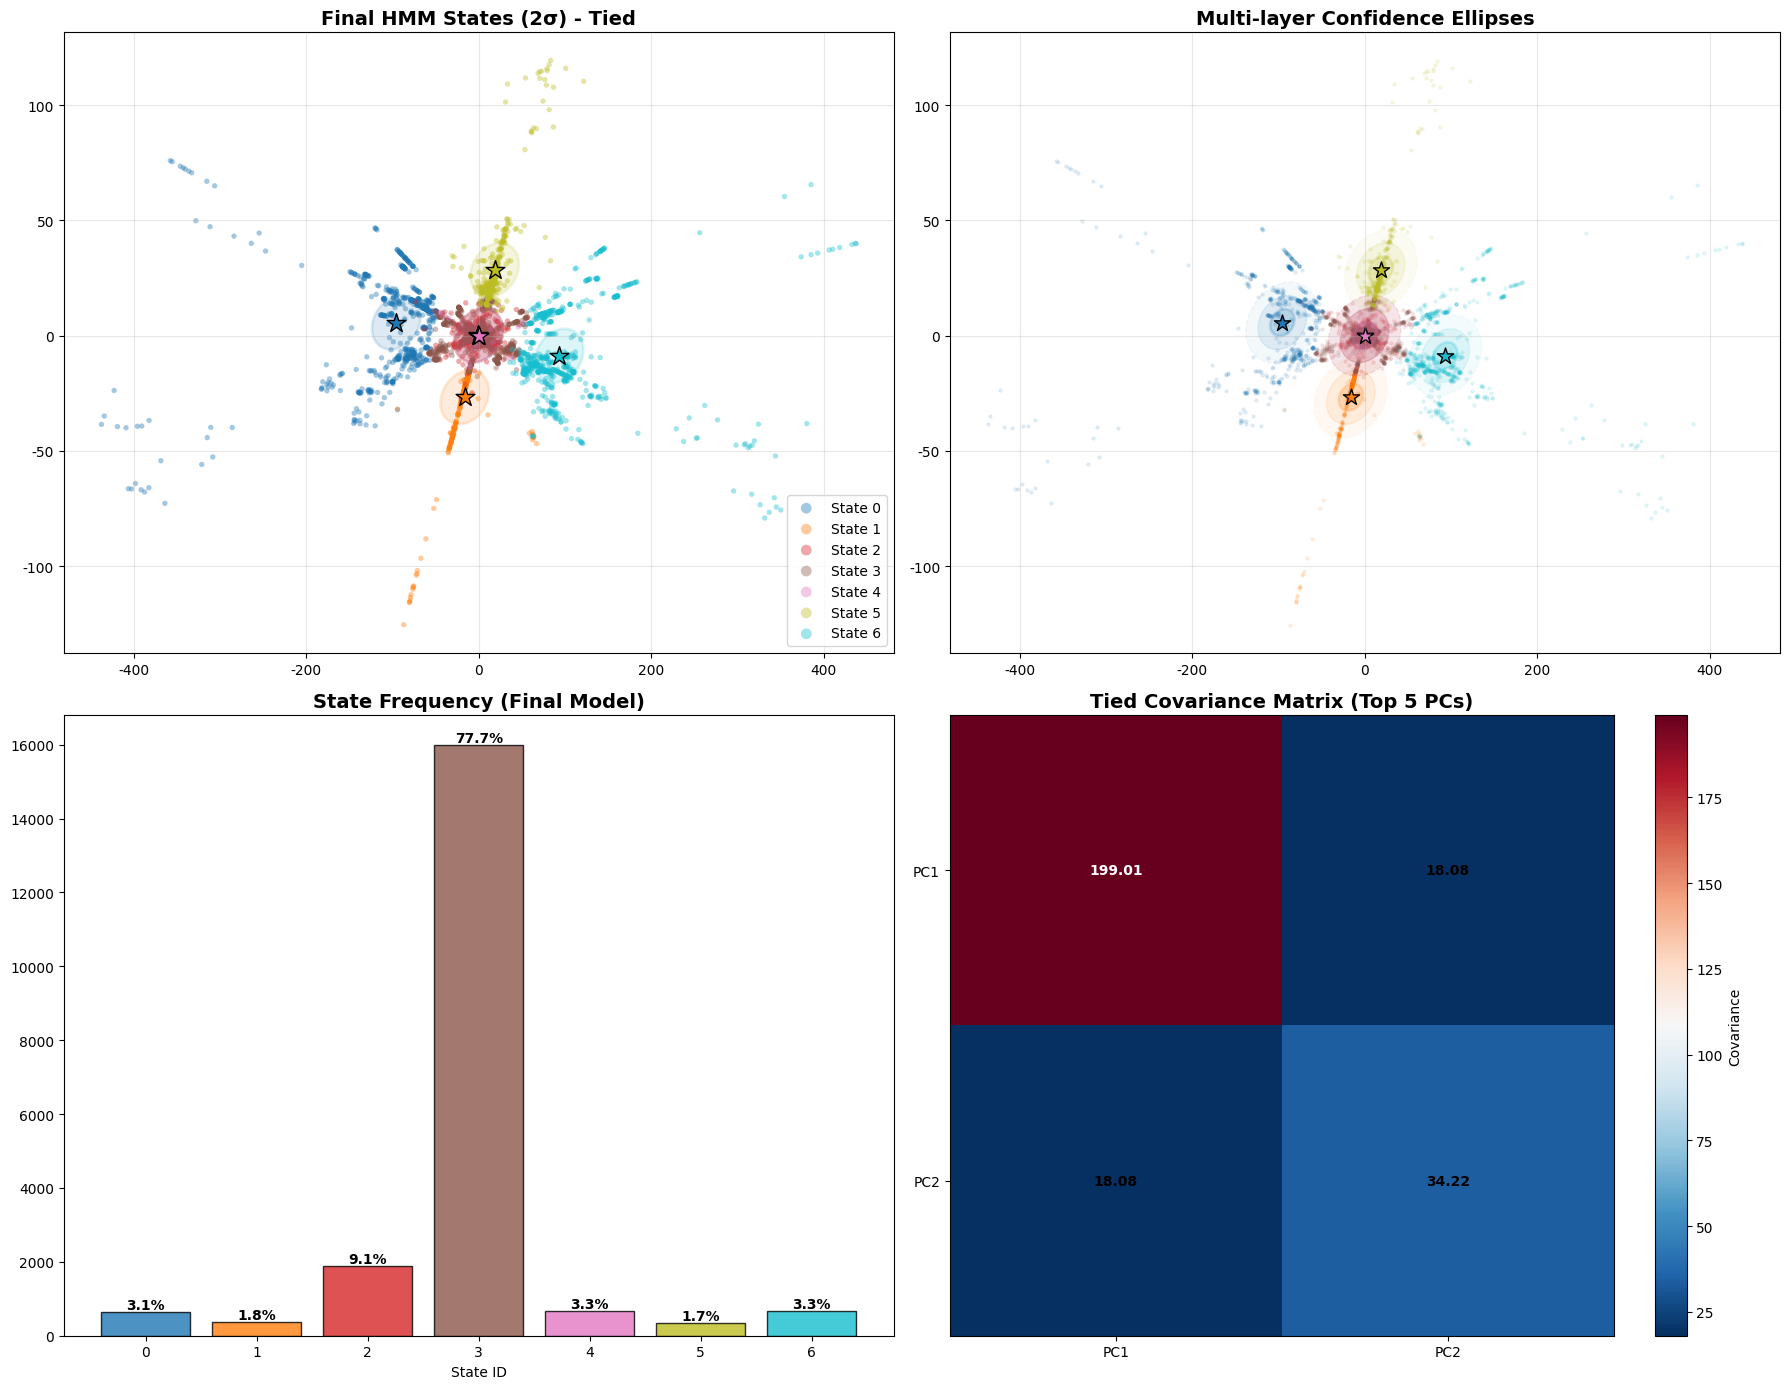

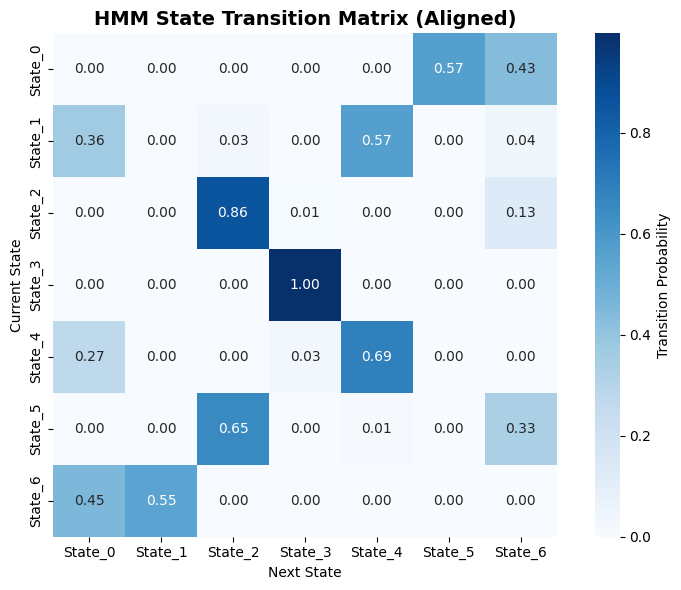

✔ 轉移矩陣已輸出: output_v全域版/hmm_transition_matrix_aligned.csv
✅ 完成！


In [8]:
# ============================================================
# Cell 8c: 擴充視窗 HMM (Expanding Window + Warm Start)
# ============================================================
# 策略變更：
# 1. 不再預先訓練全域模型。
# 2. 採用 Expanding Window：訓練資料隨著時間推進而不斷累積 (0 -> t)。
# 3. Warm Start：利用上個時刻的模型參數初始化當前模型，穩定狀態定義。
# 4. 輸出：
#    - Rolling State: 模擬當下視角，對未來(下一個Step)的預測。
#    - Final Global State: 訓練結束後，用最終模型回頭標記整段歷史。
# ============================================================

import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc
import polars as pl
from pathlib import Path
from tqdm.auto import tqdm
import copy



def log(msg): print(msg)

log("=" * 60)
log("【步驟 8c】擴充視窗 HMM (Expanding Window + Warm Start)")
log("=" * 60)

# ---------- 2. 讀取資料 ----------
log("\n【1. 讀取資料】")

out_pca_file = OUT / "step3_features_with_pca.parquet"
if not out_pca_file.exists():
    raise FileNotFoundError(f"找不到檔案: {out_pca_file}")

df_pca = pl.read_parquet(out_pca_file)

pca_cols = [c for c in df_pca.columns if c.startswith("PC")]
X_all = df_pca.select(pca_cols).fill_null(0.0).to_numpy().astype(np.float64)

log(f"✔ PCA 特徵：{pca_cols}")
log(f"✔ 樣本數：{len(X_all):,}")

# ---------- 3. 超參設定 ----------
N_STATES = 7
N_ITER_ROLLING = 100
TOL = 1e-4
COVARIANCE_TYPE = "tied"

log(f"✔ 隱狀態數：{N_STATES}")
log(f"✔ 協方差類型：{COVARIANCE_TYPE}")
log(f"✔ 訓練模式：Expanding Window (累積歷史資料)")

# ---------- 4. 滾動參數 ----------
TRADING_HOURS_PER_DAY = 5
MINUTES_PER_DAY = TRADING_HOURS_PER_DAY * 60          # 300
STEP_DAYS = 5
STEP_SIZE = STEP_DAYS * MINUTES_PER_DAY               # 1500
MIN_TRAIN_DAYS = 20
MIN_TRAIN_SIZE = MIN_TRAIN_DAYS * MINUTES_PER_DAY     # 6000

log(f"✔ 初始視窗: {MIN_TRAIN_SIZE} 筆 ({MIN_TRAIN_DAYS} 天)")
log(f"✔ 滾動步長: {STEP_SIZE} 筆 ({STEP_DAYS} 天)")

# ---------- 5. 擴充視窗訓練 ----------
log("\n" + "=" * 60)
log("【2. 開始滾動訓練】")
log("=" * 60)

rolling_states = np.full(len(X_all), -1, dtype=int)
prev_model = None
curr_idx = MIN_TRAIN_SIZE
total_steps = (len(X_all) - MIN_TRAIN_SIZE) // STEP_SIZE + 1

with tqdm(total=total_steps, desc="Expanding Training", unit="step") as pbar:
    while curr_idx < len(X_all):
        # 訓練區
        X_train = X_all[:curr_idx]
        # 預測區
        test_end = min(curr_idx + STEP_SIZE, len(X_all))
        X_test = X_all[curr_idx:test_end]
        if len(X_test) == 0:
            break

        # 建立模型
        curr_hmm = GaussianHMM(
            n_components=N_STATES,
            covariance_type=COVARIANCE_TYPE,
            n_iter=N_ITER_ROLLING,
            tol=TOL,
            random_state=42,
            verbose=0,
            init_params='stmc'
        )

        # Warm start
        if prev_model is not None:
            curr_hmm.init_params = ''
            curr_hmm.startprob_ = prev_model.startprob_.copy()
            curr_hmm.transmat_  = prev_model.transmat_.copy()
            curr_hmm.means_     = prev_model.means_.copy()
            prev_cov = prev_model.covars_
            if COVARIANCE_TYPE == 'tied' and prev_cov.ndim == 3:
                curr_hmm.covars_ = prev_cov[0].copy()
            else:
                curr_hmm.covars_ = prev_cov.copy()

        # 訓練
        try:
            curr_hmm.fit(X_train)
        except Exception as e:
            log(f"⚠ 訓練異常 (Index {curr_idx}): {e}")
            curr_idx += STEP_SIZE
            pbar.update(1)
            continue

        # 預測
        try:
            preds = curr_hmm.predict(X_test)
        except Exception as e:
            log(f"⚠ 預測異常 (Index {curr_idx}): {e}")
            curr_idx += STEP_SIZE
            pbar.update(1)
            continue

        # 狀態對齊 + 模型參數同步搬移
        means_pc1 = curr_hmm.means_[:, 0]
        if np.isnan(means_pc1).any():
            log(f"⚠ Means 含有 NaN，跳過此步 (Index {curr_idx})")
            curr_idx += STEP_SIZE
            pbar.update(1)
            continue
        sorted_indices = np.argsort(means_pc1)

        # 重新排列模型內部參數，使 state 0 永遠對應 PC1 最小
        curr_hmm.means_     = curr_hmm.means_[sorted_indices]
        curr_hmm.startprob_ = curr_hmm.startprob_[sorted_indices]
        curr_hmm.transmat_  = curr_hmm.transmat_[sorted_indices, :][:, sorted_indices]
        if COVARIANCE_TYPE != 'tied':
            curr_hmm.covars_ = curr_hmm.covars_[sorted_indices]

        # 現在 preds 已經是「對齊後」的狀態號，直接寫入
        rolling_states[curr_idx:test_end] = preds

        # 保存本輪模型
        prev_model = copy.deepcopy(curr_hmm)
        del curr_hmm
        curr_idx += STEP_SIZE
        pbar.update(1)

        # 定期 GC
        if curr_idx % (STEP_SIZE * 10) == 0:
            gc.collect()

log(f"✔ 滾動訓練完成")

# ---------- 6. 最終全域狀態 ----------
log("\n【3. 生成最終全域狀態】")
final_model = prev_model
if final_model is None:
    raise RuntimeError("模型訓練失敗，沒有產出任何模型。")

global_states_aligned = final_model.predict(X_all)
log(f"✔ 最終模型 Log-Likelihood: {final_model.score(X_all):.2f}")

# ---------- 7. 視覺化 ----------
log("\n【4. 產生視覺化報告】")


def plot_confidence_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    if cov.ndim == 3:
        cov = cov[0]
    if cov.shape != (2, 2):
        return
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ell = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(ell)


fig, axes = plt.subplots(2, 2, figsize=(18, 14))
colors = plt.cm.tab10(np.linspace(0, 1, N_STATES))

# 準備繪圖資料
df_viz = df_pca.to_pandas().copy()
df_viz["State"] = global_states_aligned

# --- 圖 1: HMM States (2σ) ---
ax = axes[0, 0]
for s in range(N_STATES):
    mask = df_viz["State"] == s
    ax.scatter(df_viz.loc[mask, "PC1"], df_viz.loc[mask, "PC2"],
               c=[colors[s]], label=f"State {s}", s=15, alpha=0.4,
               edgecolors='none', rasterized=True)

# 繪橢圓
cov_base = final_model.covars_
if cov_base.ndim == 3:
    cov_base = cov_base[0]
cov_base = cov_base[:2, :2]
for s in range(N_STATES):
    m = final_model.means_[s, :2]
    plot_confidence_ellipse(m, cov_base, ax, n_std=2.0,
                            facecolor=colors[s], alpha=0.15, edgecolor=colors[s], linewidth=2)
    ax.scatter([m[0]], [m[1]], c=[colors[s]], s=200, marker='*', edgecolors='k', zorder=10)
ax.set_title(f"Final HMM States (2σ) - Tied", fontsize=14, fontweight='bold')
ax.legend(loc='best', markerscale=2)
ax.grid(alpha=0.3)

# --- 圖 2: Multi-layer Confidence ---
ax = axes[0, 1]
for s in range(N_STATES):
    mask = df_viz["State"] == s
    ax.scatter(df_viz.loc[mask, "PC1"], df_viz.loc[mask, "PC2"],
               c=[colors[s]], s=5, alpha=0.1, rasterized=True)
    m = final_model.means_[s, :2]
    plot_confidence_ellipse(m, cov_base, ax, n_std=3.0, facecolor=colors[s], alpha=0.05, edgecolor=colors[s], ls='--')
    plot_confidence_ellipse(m, cov_base, ax, n_std=2.0, facecolor=colors[s], alpha=0.1, edgecolor=colors[s])
    plot_confidence_ellipse(m, cov_base, ax, n_std=1.0, facecolor=colors[s], alpha=0.2, edgecolor=colors[s], lw=2)
    ax.scatter([m[0]], [m[1]], c=[colors[s]], s=150, marker='*', edgecolors='k')
ax.set_title("Multi-layer Confidence Ellipses", fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# --- 圖 3: 頻率分佈 ---
ax = axes[1, 0]
counts = df_viz["State"].value_counts().sort_index()
bars = ax.bar(counts.index, counts.values, color=colors, edgecolor='k', alpha=0.8)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, h, f'{h / len(df_viz):.1%}',
            ha='center', va='bottom', fontweight='bold')
ax.set_title("State Frequency (Final Model)", fontsize=14, fontweight='bold')
ax.set_xlabel("State ID")

# --- 圖 4: 協方差矩陣 ---
ax = axes[1, 1]
cov_mat = final_model.covars_
if cov_mat.ndim == 3:
    cov_mat = cov_mat[0]
cov_top = cov_mat[:5, :5]
im = ax.imshow(cov_top, cmap='RdBu_r', aspect='auto')
plt.colorbar(im, ax=ax, label="Covariance")
for i in range(cov_top.shape[0]):
    for j in range(cov_top.shape[1]):
        ax.text(j, i, f"{cov_top[i, j]:.2f}", ha="center", va="center",
                color="white" if abs(cov_top[i, j]) > np.max(cov_top) / 2 else "black", fontweight="bold")
ax.set_title("Tied Covariance Matrix (Top 5 PCs)", fontsize=14, fontweight='bold')
ax.set_xticks(range(cov_top.shape[1]))
ax.set_xticklabels([f"PC{i + 1}" for i in range(cov_top.shape[1])])
ax.set_yticks(range(cov_top.shape[0]))
ax.set_yticklabels([f"PC{i + 1}" for i in range(cov_top.shape[0])])

plt.tight_layout()
plt.savefig(OUT / "hmm_tied_expanding.png", dpi=300)
log(f"✔ 圖片已儲存: hmm_tied_expanding.png")
del df_viz, fig, axes
gc.collect()

# ---------- 8. 輸出與存檔 ----------
log("\n【5. 輸出結果與統計】")

df_final = df_pca.with_columns([
    pl.Series("HMM_State_Final", global_states_aligned).cast(pl.Int32),
    pl.Series("HMM_State_Rolling", rolling_states).cast(pl.Int32)
])

out_parquet = OUT / "step4_features_with_hmm.parquet"
df_final.write_parquet(out_parquet)

with open(OUT / "hmm_model_final.pkl", "wb") as f:
    pickle.dump(final_model, f)

# 統計表
target_features = ["Ret_t_scaled", "Buy_pressure_t_scaled", "Emo_score_scaled"]
available_features = [f for f in target_features if f in df_final.columns]
agg_exprs = [pl.len().alias("Count"), pl.col("PC1").mean().alias("PC1_Mean")]
for feat in available_features:
    agg_exprs.extend([
        pl.col(feat).mean().alias(f"{feat}_Mean"),
        pl.col(feat).median().alias(f"{feat}_Median"),
        pl.col(feat).std().alias(f"{feat}_Std")
    ])

stats = df_final.group_by("HMM_State_Final").agg(agg_exprs).sort("HMM_State_Final")
total_count = df_final.height
stats = stats.with_columns((pl.col("Count") / total_count).alias("Ratio"))

final_cols = (["HMM_State_Final", "Count", "Ratio"] +
              [c for c in stats.columns if c != "HMM_State_Final" and c != "Count" and c != "Ratio"])
out_stats_path = OUT / "hmm_state_stats.csv"
stats.select(final_cols).write_csv(out_stats_path, float_precision=4)

log(f"✔ Parquet 輸出: {out_parquet}")
log(f"✔ 統計數據輸出: {out_stats_path}")
print(stats.select(final_cols))

# ---------- 9. 轉移矩陣 ----------
log("\n【6. 計算狀態轉移機率矩陣】")
# 因模型內部已經是 aligned 順序，直接輸出即可
df_trans = pd.DataFrame(
    final_model.transmat_,
    index=[f"State_{i}" for i in range(N_STATES)],
    columns=[f"State_{i}" for i in range(N_STATES)]
)
print("Aligned Transition Matrix:")
print(df_trans.round(4))
out_trans_path = OUT / "hmm_transition_matrix_aligned.csv"
df_trans.to_csv(out_trans_path, float_format="%.6f")

plt.figure(figsize=(8, 6))
sns.heatmap(df_trans, annot=True, fmt=".2f", cmap="Blues", square=True,
            cbar_kws={"label": "Transition Probability"})
plt.title("HMM State Transition Matrix (Aligned)", fontsize=14, fontweight="bold")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.tight_layout()
plt.savefig(OUT / "hmm_transition_matrix_aligned.png", dpi=300)
plt.show()

log(f"✔ 轉移矩陣已輸出: {out_trans_path}")
log(f"✅ 完成！")

In [9]:
# ==========================================================
# 只壓縮 → 子序列比對 → NX 抓環
# ==========================================================
import numpy as np
import networkx as nx

log("\n【7. 壓縮比對】")

# ---- 清場 ----
for _v in ['up_cnt', 'down_cnt', 'total', 'simp_chain', 'G',
          'all_cycles', 'up_like', 'down_like']:
    if _v in locals():
        del locals()[_v]

# ---------- 1. 只壓縮連續相同（零平滑） ----------
def compress_states(seq):
    out = [seq[0]]
    for s in seq[1:]:
        if s != out[-1]:
            out.append(s)
    return np.array(out, dtype=int)

simp_chain = compress_states(rolling_states)     # 只壓一次

# ---------- 2. 子序列比對 ----------
def count_subseq_simp(simp_seq, core):
    k = len(core)
    hits = 0
    idx = 0
    n = len(simp_seq)
    while idx < n:
        ptr = 0
        for j in range(idx, n):
            if simp_seq[j] == core[ptr]:
                ptr += 1
                if ptr == k:
                    hits += 1
                    idx = j + 1     # 跳過這段，不重疊
                    break
        else:
            idx += 1
    return hits

# ---------- 3. 目標核心 ----------
up_core   = [3,5,6,2,3]
down_core = [3,1,0,4,3]

up_cnt   = count_subseq_simp(simp_chain, up_core)
down_cnt = count_subseq_simp(simp_chain, down_core)
total    = up_cnt + down_cnt

log(f"原始序列壓縮後長度：{len(simp_chain)} 段")
log(f"含「3-5-6-2-3」子順序：{up_cnt} 次")
log(f"含「3-1-0-4-3」子順序：{down_cnt} 次")
if total:
    log(f"兩者合計：{total} 次（多頭佔 {up_cnt/total:.1%}）")
else:
    log("兩者合計：0 次")

# ---------- 4. NetworkX 驗證（用 simp_chain） ----------
G = nx.DiGraph()
for st, nxt in zip(simp_chain[:-1], simp_chain[1:]):
    G.add_edge(st, nxt)

all_cycles = list(nx.simple_cycles(G))
up_like    = [c for c in all_cycles if np.isin([3,5,6,2,3], c).all()]
down_like  = [c for c in all_cycles if np.isin([3,1,0,4,3], c).all()]

log(f"NX 簡單環中，含 3-5-6-2-3 子順序：{len(up_like)} 個")
log(f"NX 簡單環中，含 3-1-0-4-3 子順序：{len(down_like)} 個")


【7. 壓縮比對】
原始序列壓縮後長度：1737 段
含「3-5-6-2-3」子順序：22 次
含「3-1-0-4-3」子順序：33 次
兩者合計：55 次（多頭佔 40.0%）
NX 簡單環中，含 3-5-6-2-3 子順序：414 個
NX 簡單環中，含 3-1-0-4-3 子順序：396 個


In [10]:
# ============================================================
# Cell 9: Viterbi 解碼與互動式體制視覺化 (Interactive)
# ============================================================
# 優化項目：
# 1. 保留 Viterbi 全域解碼邏輯。
# 2. 建立日期索引清單。
# 3. 引入 ipywidgets：提供 [上一日] [下一日] 按鈕與下拉選單。
# ============================================================

import matplotlib.dates as mdates
import polars as pl
import pandas as pd
import numpy as np
import pickle
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output

# 設定路徑 (假設上層已定義 OUT)
# OUT = Path("./output")

def log(msg): print(msg)

log("=" * 60)
log("【步驟 9】Viterbi 解碼 & 互動式檢視器")
log("=" * 60)

# ===============================================================
# ⚙️ 互動控制與全域狀態
# ===============================================================
VIEW_MODE = "day"
current_idx = 0


# =========== 1. 讀取資料 ===========
hmm_file = OUT / "step4_features_with_hmm.parquet"
if not hmm_file.exists():
    raise FileNotFoundError(f"❌ 找不到檔案: {hmm_file}")

log(f"1. 讀取檔案: {hmm_file.name}")
df_step4 = pl.read_parquet(hmm_file)

# 欄位映射
COL_TIME = "SnapshotTime"
COL_PRICE = "Price"
COL_DATE_GROUP = "date_group"
COL_PCS = ["PC1", "PC2"]

# 準備全量數據 (Viterbi 需要完整的序列)
X_all = df_step4.select(COL_PCS).fill_null(0.0).to_numpy()

# =========== 2. Viterbi 解碼 (只跑一次) ===========
model_path = OUT / "hmm_model_global.pkl"
if not model_path.exists():
    model_path = OUT / "hmm_model_tied.pkl" # Fallback

if not model_path.exists():
     # 如果都沒有，嘗試讀取 final
    model_path = OUT / "hmm_model_final.pkl"

if not model_path.exists():
     raise FileNotFoundError("❌ 找不到 HMM 模型檔案 (.pkl)")

log(f"2. 載入模型: {model_path.name}")
with open(model_path, "rb") as f:
    global_hmm = pickle.load(f)

N_STATES = global_hmm.n_components

# 判斷是否需要重新計算 Viterbi (如果欄位已存在且不想重算可跳過，這裡預設重算以確保一致)
log(f"⏳ 正在計算全量 Viterbi 路徑...")
log_prob, viterbi_states = global_hmm.decode(X_all, algorithm="viterbi")

# 狀態對齊 (Alignment)
means_pc1 = global_hmm.means_[:, 0]
sort_idx = np.argsort(means_pc1)
state_map = {old: new for new, old in enumerate(sort_idx)}
viterbi_aligned = np.array([state_map[s] for s in viterbi_states])

# 更新 DataFrame
df_final = df_step4.with_columns(
    pl.Series("HMM_State_Viterbi", viterbi_aligned).cast(pl.Int32)
)
# 存檔 (選擇性)
# df_final.write_parquet(hmm_file)
log(f"✔ Viterbi 解碼完成")

# =========== 3. 準備互動所需的資料 ===========

# 取得所有唯一的日期，並排序
all_dates = sorted(df_final[COL_DATE_GROUP].unique().to_list())
log(f"📅 資料總天數: {len(all_dates)} 天")
log(f"📅 日期範圍: {all_dates[0]} ~ {all_dates[-1]}")

# 預先定義顏色 (固定顏色避免跳動)
colors = plt.cm.tab10(np.linspace(0, 1, N_STATES))

# =========== 4. 定義繪圖函數 ===========
def plot_regime_by_date(date_idx):
    global VIEW_MODE

    if date_idx < 0 or date_idx >= len(all_dates):
        print("Index out of bounds.")
        return

    # === 決定要畫哪些日期 ===
    if VIEW_MODE == "day":
        date_list = [all_dates[date_idx]]
        title_suffix = f"Date: {all_dates[date_idx]}"
    else:
        start_idx = max(0, date_idx - 4)
        date_list = all_dates[start_idx:date_idx + 1]
        title_suffix = f"Week View: {date_list[0]} → {date_list[-1]}"

    # === 篩選資料（多日）===
    df_plot = df_final.filter(pl.col(COL_DATE_GROUP).is_in(date_list))
    if len(df_plot) == 0:
        print("No data.")
        return

    # === Pandas ===
    df_pd = df_plot.select(
        [COL_TIME, COL_PRICE, "HMM_State_Viterbi", COL_DATE_GROUP]
    ).to_pandas()

    df_pd[COL_TIME] = pd.to_datetime(df_pd[COL_TIME])
    df_pd = df_pd.sort_values(COL_TIME)

    # === MA（跨日 rolling，這是週視角的重點）===
    df_pd["MA5"]  = df_pd[COL_PRICE].rolling(5,  min_periods=1).mean()
    df_pd["MA10"] = df_pd[COL_PRICE].rolling(10, min_periods=1).mean()
    df_pd["MA30"] = df_pd[COL_PRICE].rolling(30, min_periods=1).mean()

    # === 繪圖 ===
    plt.close('all')
    fig, ax = plt.subplots(figsize=(16, 6))

    # 價格
    ax.plot(df_pd[COL_TIME], df_pd[COL_PRICE],
            color='black', lw=0.8, alpha=0.4, label="Price")

    # MA
    ax.plot(df_pd[COL_TIME], df_pd["MA5"],  color='orange', lw=1.2, label="MA5")
    ax.plot(df_pd[COL_TIME], df_pd["MA10"], color='green',  lw=1.2, label="MA10")
    ax.plot(df_pd[COL_TIME], df_pd["MA30"], color='red',    lw=1.2, label="MA30")

    # 狀態點
    for s in range(N_STATES):
        mask = df_pd["HMM_State_Viterbi"] == s
        if mask.any():
            ax.scatter(
                df_pd.loc[mask, COL_TIME],
                df_pd.loc[mask, COL_PRICE],
                s=22,
                color=colors[s],
                alpha=0.85,
                label=f"State {s}",
                zorder=10,
                edgecolors='none'
            )

    ax.set_title(
        f"Market Regimes (Viterbi) | {title_suffix}",
        fontsize=14, fontweight='bold'
    )
    ax.set_ylabel("Price")
    ax.grid(True, alpha=0.3)
    ax.legend(
        loc='upper left',
        fontsize=9,
        ncol=min(N_STATES + 4, 7)
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
    plt.tight_layout()
    plt.show()



# =========== 5. 建立互動控制項 (ipywidgets) ===========

# 初始化索引 (預設最後一天)
current_idx = len(all_dates) - 1

# 建立元件
btn_prev = widgets.Button(description='◀ Previous Day', icon='arrow-left')
btn_next = widgets.Button(description='Next Day ▶', icon='arrow-right')
dropdown = widgets.Dropdown(
    options=[(date, i) for i, date in enumerate(all_dates)],
    value=current_idx,
    description='Select Date:',
)
out_plot = widgets.Output()

# 按鈕事件處理
def on_btn_click(b):
    global current_idx
    if b.description == '◀ Previous Day':
        current_idx = max(0, current_idx - 1)
    elif b.description == 'Next Day ▶':
        current_idx = min(len(all_dates) - 1, current_idx + 1)

    # 更新下拉選單的值 (會觸發 dropdown 的 observe)
    dropdown.value = current_idx

# 下拉選單事件處理
def on_dropdown_change(change):
    global current_idx
    if change['type'] == 'change' and change['name'] == 'value':
        current_idx = change['new']
        with out_plot:
            clear_output(wait=True)
            plot_regime_by_date(current_idx)

# 綁定事件
btn_prev.on_click(on_btn_click)
btn_next.on_click(on_btn_click)
dropdown.observe(on_dropdown_change)

# 初始顯示
with out_plot:
    plot_regime_by_date(current_idx)

# 顯示介面
log("\n⬇⬇⬇ 請使用下方控制項切換日期 ⬇⬇⬇")
ui = widgets.VBox([
    widgets.HBox([btn_prev, dropdown, btn_next]),
    out_plot
])
display(ui)

【步驟 9】Viterbi 解碼 & 互動式檢視器
1. 讀取檔案: step4_features_with_hmm.parquet
2. 載入模型: hmm_model_final.pkl
⏳ 正在計算全量 Viterbi 路徑...
✔ Viterbi 解碼完成
📅 資料總天數: 83 天
📅 日期範圍: 2025-09-05 ~ 2026-01-21

⬇⬇⬇ 請使用下方控制項切換日期 ⬇⬇⬇


# LCS

In [ ]:
!pip install optuna

In [7]:
# ==============================================================================
# 🛠️ 0. 全域設定與路徑
# ==============================================================================
OUT_DIR = Path("./output_v全域版")
INPUT_FILE = "step4_features_with_hmm.parquet"

[I 2026-01-31 03:28:29,248] A new study created in memory with name: no-name-635f5f3f-653e-437e-83d7-beef7b89cb19


🔹 🌱 Random Seed 已固定為: 42
🔹 1. 讀取資料: output_v全域版/step4_features_with_hmm.parquet
🔹 🧹 過濾 HMM 初始化階段 (-1) 資料: 20606 -> 14606

🕵️ 執行數據洩漏檢測 (Data Leakage Check)
📌 HMM State (Rolling) vs Ret_1m 最大相關係數: 0.0133
✅ 檢測通過：無異常線性洩漏跡象。

🔹 2. 進行特徵離散化 (針對 Scaled Data)...
🔹 📌 資料切分 (80/20): Train=5016, Test=1255

🔍 開始 Optuna 超參數搜尋 (Time Series CV)...


[I 2026-01-31 03:28:56,058] Trial 0 finished with value: 0.746068464982707 and parameters: {'population_size': 562, 'mutation_rate': 0.14310000289738825, 'beta': 0.2329984854528513, 'nu': 6, 'min_acc_threshold': 0.5324814912353949}. Best is trial 0 with value: 0.746068464982707.
[I 2026-01-31 03:29:13,628] Trial 1 finished with value: 0.803886229073252 and parameters: {'population_size': 409, 'mutation_rate': 0.018131705703547926, 'beta': 0.2665440364437338, 'nu': 6, 'min_acc_threshold': 0.5766458062236837}. Best is trial 1 with value: 0.803886229073252.
[I 2026-01-31 03:29:21,671] Trial 2 finished with value: 0.8240569903194348 and parameters: {'population_size': 314, 'mutation_rate': 0.1457873793026792, 'beta': 0.2581106602001054, 'nu': 3, 'min_acc_threshold': 0.534545997376568}. Best is trial 2 with value: 0.8240569903194348.
[I 2026-01-31 03:29:29,722] Trial 3 finished with value: 0.8216840437190841 and parameters: {'population_size': 428, 'mutation_rate': 0.05259391401433528, 'bet


✅ 最佳參數: {'population_size': 314, 'mutation_rate': 0.1457873793026792, 'beta': 0.2581106602001054, 'nu': 3}
🏆 最佳 CV 分數 (Avg): 0.8241
🎯 篩選門檻 (Accuracy Threshold): 53.45%

🚀 啟動 LCS 最終訓練 (Full Train Set)...
   Epoch 10/300 | Train Acc: 78.95%
   Epoch 20/300 | Train Acc: 79.03%
   Epoch 30/300 | Train Acc: 79.90%
   Epoch 40/300 | Train Acc: 80.84%
   Epoch 50/300 | Train Acc: 80.84%
   Epoch 60/300 | Train Acc: 77.95%
   Epoch 70/300 | Train Acc: 80.20%
   Epoch 80/300 | Train Acc: 79.78%
   Epoch 90/300 | Train Acc: 81.00%
   Epoch 100/300 | Train Acc: 81.12%
   Epoch 110/300 | Train Acc: 81.64%
   Epoch 120/300 | Train Acc: 81.94%
   Epoch 130/300 | Train Acc: 81.04%
   Epoch 140/300 | Train Acc: 81.26%
   Epoch 150/300 | Train Acc: 81.42%
   Epoch 160/300 | Train Acc: 81.52%
   Epoch 170/300 | Train Acc: 81.98%
   Epoch 180/300 | Train Acc: 80.26%
   Epoch 190/300 | Train Acc: 81.32%
   Epoch 200/300 | Train Acc: 81.24%
   Epoch 210/300 | Train Acc: 82.06%
   Epoch 220/300 | Train Acc

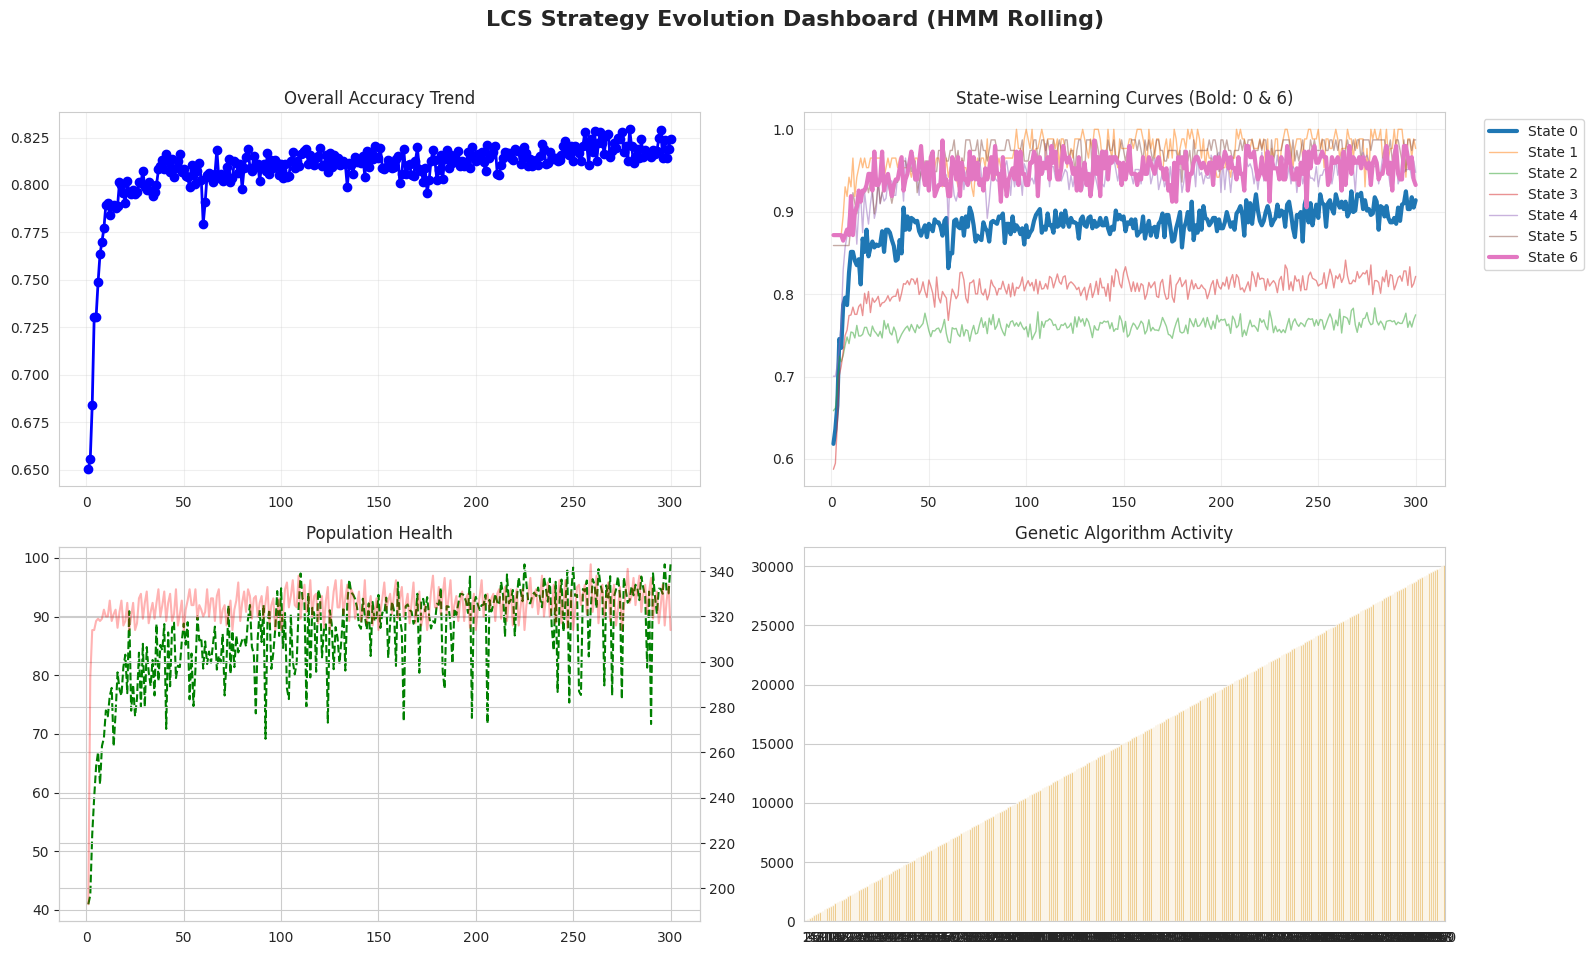

🔹 4. 訓練完成，篩選最佳規則...
💾 篩選後規則數量: 25 (Threshold: 53.45%)
🔹 ✔ 規則已匯出至: output_v全域版/lcs_optuna_rules_expanding.csv

📉 In-Sample (Train) (Rows: 5016)

📌 混淆矩陣 (Confusion Matrix):
    實際漲 (TP/FN) | 218      | 19      
    實際跌 (FP/TN) | 18       | 293     

📌 關鍵績效:
   ➤ 準確率 (Acc) : 93.25%
   ➤ 多單勝率     : 92.37%
   ➤ 空單勝率     : 93.91%
   ➤ 覆蓋率       : 10.93%
   ➤ 交易次數     : 548

📉 Out-of-Sample (Test) - Expanding Window Verification (Rows: 1255)

📌 混淆矩陣 (Confusion Matrix):
    實際漲 (TP/FN) | 53       | 23      
    實際跌 (FP/TN) | 8        | 74      

📌 關鍵績效:
   ➤ 準確率 (Acc) : 80.38%
   ➤ 多單勝率     : 86.89%
   ➤ 空單勝率     : 76.29%
   ➤ 覆蓋率       : 12.59%
   ➤ 交易次數     : 158


In [13]:
# @title LCS Strategy with Time Series Split (Complete Code)
import numpy as np
import polars as pl
import pandas as pd
import random
import logging
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import List
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit  # 新增：用於時間序列交叉驗證
from pathlib import Path

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']


logger = logging.getLogger("LCS_Trader")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter('🔹 %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

def log(msg):
    print(f"🔹 {msg}")

def set_seed(seed=42):
    """固定所有隨機種子以確保可重現性"""
    random.seed(seed)
    np.random.seed(seed)
    log(f"🌱 Random Seed 已固定為: {seed}")

# ==============================================================================
# 🕵️ 1. 防洩漏檢測模組
# ==============================================================================
def run_leakage_check(df_pl: pl.DataFrame, target_horizon=1):
    print("\n" + "="*60)
    print("🕵️ 執行數據洩漏檢測 (Data Leakage Check)")
    print("="*60)
    df = df_pl.to_pandas()
    target_col = f"Ret_{target_horizon}m"

    # 檢查 HMM State (Rolling) 與 未來回報 的相關性
    if 'hmm_state' in df.columns:
        dummies = pd.get_dummies(df['hmm_state'], prefix='State')
        check_df = pd.concat([df[[target_col]], dummies], axis=1).dropna()
        corr = check_df.corr()[target_col].drop(target_col)
        max_corr = corr.abs().max()

        print(f"📌 HMM State (Rolling) vs {target_col} 最大相關係數: {max_corr:.4f}")
        if max_corr > 0.8:
            print("⚠️ [注意] 狀態與回報相關性極高，請確認回測邏輯是否正確。")
        else:
            print("✅ 檢測通過：無異常線性洩漏跡象。")
    print("="*60 + "\n")

# ==============================================================================
# ⚙️ 2. 資料準備 (適配 HMM Step 4 輸出)
# ==============================================================================
def prepare_labeled_data(file_path: Path, horizons=[1, 3, 5], base_fee=0.0002):
    log(f"1. 讀取資料: {file_path}")
    if not file_path.exists():
        log(f"❌ 找不到檔案: {file_path}")
        return None

    try:
        df = pl.read_parquet(file_path)

        rename_map = {
            "HMM_State_Rolling": "hmm_state",
            "Buy_pressure_t_scaled": "bp_score",
            "Emo_score_scaled": "emo_score"
        }

        missing_cols = [k for k in rename_map.keys() if k not in df.columns]
        if missing_cols:
            log(f"⚠️ 警告: 缺少欄位 {missing_cols}，嘗試尋找替代名稱或檢查 HMM 輸出...")
            if "Buy_pressure_t" in df.columns: rename_map["Buy_pressure_t"] = "bp_score"
            if "Emo_score" in df.columns: rename_map["Emo_score"] = "emo_score"

        df = df.rename({k: v for k, v in rename_map.items() if k in df.columns})

        original_len = df.height
        df = df.filter(pl.col("hmm_state") != -1)
        log(f"🧹 過濾 HMM 初始化階段 (-1) 資料: {original_len} -> {df.height}")

    except Exception as e:
        log(f"❌ 讀取失敗: {e}")
        return None

    price_col = "Price" if "Price" in df.columns else "Close"
    if price_col not in df.columns:
        log("❌ 錯誤: 資料中找不到 Price 或 Close 欄位，無法計算標籤。")
        return None

    # 動態閾值設定
    df = df.with_columns(
        pl.when(pl.col("hmm_state") == 3).then(base_fee * 1.2)
          .when(pl.col("hmm_state").is_in([0, 6])).then(base_fee * 2.5)
          .otherwise(base_fee * 1.5)
          .alias("dynamic_threshold")
    )

    cols_to_keep = ["hmm_state", "bp_score", "emo_score"]

    for h in horizons:
        col_name = f"Ret_{h}m"
        label_name = f"Label_{h}m"
        df = df.with_columns((pl.col(price_col).shift(-h) / pl.col(price_col) - 1).alias(col_name))

        df = df.with_columns(
            pl.when(pl.col(col_name) > pl.col("dynamic_threshold")).then(1)
              .when(pl.col(col_name) < -pl.col("dynamic_threshold")).then(0)
              .otherwise(-1).alias(label_name)
        )
        cols_to_keep.append(col_name)
        cols_to_keep.append(label_name)

    return df.select(cols_to_keep).drop_nulls()

def discretize_features(df: pl.DataFrame) -> pd.DataFrame:
    log("2. 進行特徵離散化 (針對 Scaled Data)...")
    df_pd = df.to_pandas()
    state_col = df_pd["hmm_state"].astype(str)

    bp_bins = [-np.inf, -0.5, 0.5, np.inf]
    bp_labels = ["L", "N", "H"]
    bp_disc = pd.cut(df_pd["bp_score"], bins=bp_bins, labels=bp_labels)

    emo_bins = [-np.inf, -1.5, -0.5, 0.5, 1.5, np.inf]
    emo_labels = ["LL", "L", "N", "H", "HH"]
    emo_disc = pd.cut(df_pd["emo_score"], bins=emo_bins, labels=emo_labels)

    df_pd["Condition"] = state_col + "-" + bp_disc.astype(str) + "-" + emo_disc.astype(str)
    return df_pd

# ==============================================================================
# 🧬 3. LCS 核心類別
# ==============================================================================
@dataclass
class Classifier:
    condition: str
    action: int
    fitness: float = 50.0
    accuracy: float = 0.5
    numerosity: int = 1
    experience: int = 0
    match_count: int = 0

    def update_accuracy(self, is_correct: bool, beta: float, nu: int, weight: float = 1.0):
        reward = 1.0 if is_correct else 0.0
        weighted_beta = min(beta * weight, 0.5)

        self.experience += 1
        if is_correct: self.match_count += 1

        self.accuracy = self.accuracy + weighted_beta * (reward - self.accuracy)

        acc_factor = (self.accuracy ** nu) * 100 if self.accuracy > 0.5 else 1.0
        self.fitness = self.fitness + beta * (acc_factor - self.fitness)

class SimpleLCS:
    def __init__(self, population_size=500, mutation_rate=0.05, beta=0.1, nu=5):
        self.population: List[Classifier] = []
        self.max_pop_size = population_size
        self.mutation_rate = mutation_rate
        self.beta = beta
        self.nu = nu
        self.time_step = 0
        self.ga_count = 0

    def get_match_set(self, condition_input: str) -> List[Classifier]:
        return [cl for cl in self.population if cl.condition == condition_input]

    def cover(self, condition_input: str, label: int):
        new_cl = Classifier(condition=condition_input, action=label, fitness=10.0, accuracy=0.5)
        self.population.append(new_cl)

    def predict(self, match_set: List[Classifier]) -> int:
        if not match_set: return -1
        votes = {0: 0.0, 1: 0.0}
        for cl in match_set:
            votes[cl.action] += cl.fitness * cl.accuracy
        if votes[1] > votes[0]: return 1
        if votes[0] > votes[1]: return 0
        return random.choice([0, 1])

    def run_ga(self, match_set: List[Classifier]):
        if self.time_step % 50 != 0 or not match_set: return

        total_fit = sum(cl.fitness for cl in match_set)
        if total_fit == 0: return

        parent = random.choices(match_set, weights=[cl.fitness for cl in match_set], k=1)[0]
        child = Classifier(condition=parent.condition, action=parent.action)

        if random.random() < self.mutation_rate:
            child.action = 1 - child.action
            child.accuracy = 0.5
            child.fitness = 10.0
            child.experience = 0

        self.population.append(child)
        self.ga_count += 1

        if len(self.population) > self.max_pop_size:
            self.population.sort(key=lambda x: (x.fitness * 0.7 + x.accuracy * 0.3), reverse=True)
            self.population = self.population[:self.max_pop_size]

    def train_instance(self, condition_input: str, label: int):
        self.time_step += 1

        try:
            current_state = int(condition_input.split("-")[0])
        except:
            current_state = 3

        importance_weight = 2.0 if current_state in [0, 6] else 1.0

        match_set = self.get_match_set(condition_input)
        if not match_set:
            self.cover(condition_input, label)
            match_set = self.get_match_set(condition_input)

        prediction = self.predict(match_set)
        is_correct = (prediction == label)

        for cl in match_set:
            cl.update_accuracy(is_correct, self.beta, self.nu, weight=importance_weight)

        self.run_ga(match_set)
        return is_correct

    def get_population_stats(self):
        if not self.population: return {}
        avg_fit = sum(cl.fitness for cl in self.population) / len(self.population)
        avg_acc = sum(cl.accuracy for cl in self.population) / len(self.population)
        return {"Pop_Size": len(self.population), "Avg_Fit": avg_fit, "Avg_Acc": avg_acc, "GA_Events": self.ga_count}

# ==============================================================================
# 📊 4. 訓練儀表板 (Dashboard)
# ==============================================================================
def plot_lcs_training_history(history):
    epochs = range(1, len(history['total_acc']) + 1)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('LCS Strategy Evolution Dashboard (HMM Rolling)', fontsize=16, fontweight='bold')

    ax1 = axes[0, 0]
    ax1.plot(epochs, history['total_acc'], 'b-o', linewidth=2, label='Total Accuracy')
    ax1.set_title('Overall Accuracy Trend')
    ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    active_states = [s for s, accs in history['state_acc'].items() if len(accs) > 0]
    palette = sns.color_palette("tab10", len(active_states))

    for idx, state in enumerate(active_states):
        acc_list = history['state_acc'][state]
        if len(acc_list) != len(epochs): continue
        lw = 3 if str(state) in ['0', '6'] else 1.0
        alpha = 1.0 if str(state) in ['0', '6'] else 0.5
        ax2.plot(epochs, acc_list, marker='', linewidth=lw, alpha=alpha, label=f'State {state}', color=palette[idx])

    ax2.set_title('State-wise Learning Curves (Bold: 0 & 6)')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)

    ax3 = axes[1, 0]
    ax3.plot(epochs, history['avg_fit'], 'g--', label='Avg Fitness')
    ax3_twin = ax3.twinx()
    ax3_twin.plot(epochs, history['pop_size'], 'r-', alpha=0.3, label='Rule Count')
    ax3.set_title('Population Health')

    ax4 = axes[1, 1]
    sns.barplot(x=list(epochs), y=history['ga_events'], ax=ax4, color='orange', alpha=0.7)
    ax4.set_title('Genetic Algorithm Activity')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==============================================================================
# 🧪 5. Optuna 目標函數 (修正為 Time Series Split)
# ==============================================================================
def objective(trial, df_train_full, target_col):
    """
    使用 TimeSeriesSplit 進行交叉驗證 (Walk-Forward Validation)
    確保在驗證過程中嚴格遵守時間順序，避免未來資訊洩漏。
    """
    params = {
        'population_size': trial.suggest_int('population_size', 300, 1000),
        'mutation_rate': trial.suggest_float('mutation_rate', 0.01, 0.15),
        'beta': trial.suggest_float('beta', 0.05, 0.30),
        'nu': trial.suggest_int('nu', 2, 8)
    }

    min_acc_threshold = trial.suggest_float('min_acc_threshold', 0.52, 0.60)

    # 設定 Time Series Split，這裡切成 4 等份
    # Fold 1: Train on Seg 1, Test on Seg 2
    # Fold 2: Train on Seg 1+2, Test on Seg 3 ...
    n_splits = 4
    tscv = TimeSeriesSplit(n_splits=n_splits)

    cv_scores = []

    # 針對每一折進行訓練與驗證
    for fold_idx, (train_index, val_index) in enumerate(tscv.split(df_train_full)):

        # 建立新的 LCS 實例 (每一折都要重練，因為我們在模擬當時的情境)
        lcs = SimpleLCS(**params)

        # 取得該折的訓練與驗證數據
        fold_train_df = df_train_full.iloc[train_index]
        fold_val_df = df_train_full.iloc[val_index]

        conditions = fold_train_df["Condition"].values
        labels = fold_train_df[target_col].values

        # 訓練階段 (快速迭代 10-15 epochs 讓規則收斂)
        # 注意：雖然是 Time Series Split，但在訓練集內部可以 Shuffle 增強記憶
        indices = np.arange(len(conditions))
        for _ in range(30):
            np.random.shuffle(indices)
            for i in indices:
                lcs.train_instance(conditions[i], int(labels[i]))

        # 驗證階段 (Out-of-sample for this fold)
        valid_rules = [cl for cl in lcs.population if cl.experience >= 10 and cl.accuracy >= min_acc_threshold]

        if not valid_rules:
            cv_scores.append(0.0)
            continue

        # 建立最佳規則表
        rule_map = {}
        for cl in valid_rules:
            if cl.condition not in rule_map or cl.fitness > rule_map[cl.condition].fitness:
                rule_map[cl.condition] = cl

        correct = 0
        covered = 0
        val_conds = fold_val_df["Condition"].values
        val_lbls = fold_val_df[target_col].values

        for i in range(len(val_conds)):
            cond = val_conds[i]
            lbl = int(val_lbls[i])
            if cond in rule_map:
                pred = rule_map[cond].action
                covered += 1
                if pred == lbl: correct += 1

        if covered == 0:
            cv_scores.append(0.0)
        else:
            val_acc = correct / covered
            coverage_ratio = covered / len(fold_val_df)

            # 懲罰覆蓋率過低
            penalty = 1.0
            if coverage_ratio < 0.05:
                penalty = 0.5

            cv_scores.append(val_acc * penalty)

    # 回傳所有折數的平均分數
    final_score = np.mean(cv_scores)
    return final_score

# ==============================================================================
# 📊 6. 績效評估函數
# ==============================================================================
def evaluate_dataset(engine_map, df, target_col, title):
    print("\n" + "="*80)
    print(f"📉 {title} (Rows: {len(df)})")
    print("="*80)

    y_true, y_pred = [], []
    covered_count = 0

    for _, row in df.iterrows():
        cond = row["Condition"]
        lbl = int(row[target_col])

        if cond in engine_map:
            pred = engine_map[cond].action
            y_pred.append(pred)
            y_true.append(lbl)
            covered_count += 1

    if not y_true:
        print("⚠️ 無有效訊號觸發。")
        return

    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    tp, fn, fp, tn = cm.ravel()

    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    prec_up = tp / (tp + fp) if (tp+fp) > 0 else 0
    prec_down = tn / (tn + fn) if (tn+fn) > 0 else 0

    print("\n📌 混淆矩陣 (Confusion Matrix):")
    print(f"{'實際漲 (TP/FN)':>15} | {tp:<8} | {fn:<8}")
    print(f"{'實際跌 (FP/TN)':>15} | {fp:<8} | {tn:<8}")
    print("\n📌 關鍵績效:")
    print(f"   ➤ 準確率 (Acc) : {acc:.2%}")
    print(f"   ➤ 多單勝率     : {prec_up:.2%}")
    print(f"   ➤ 空單勝率     : {prec_down:.2%}")
    print(f"   ➤ 覆蓋率       : {covered_count/len(df):.2%}")
    print(f"   ➤ 交易次數     : {covered_count}")

# ==============================================================================
# 🚀 7. 主程式
# ==============================================================================
def main():
    # 1. 固定隨機種子
    set_seed(42)

    # 指向新的 Expanding Window HMM 檔案
    full_path = OUT_DIR / INPUT_FILE
    TARGET_HORIZON = 1

    # 2. 資料準備
    df_pl = prepare_labeled_data(full_path, horizons=[1, 3, 5])
    if df_pl is None:
        log(f"請確認檔案是否存在於: {full_path}")
        return

    # 3. 洩漏檢測
    run_leakage_check(df_pl, TARGET_HORIZON)

    # 4. 特徵離散化
    df_disc = discretize_features(df_pl)
    target_col = f"Label_{TARGET_HORIZON}m"
    df_clean = df_disc[df_disc[target_col] != -1].copy()

    # 5. 時間序列切分 (80% 訓練 / 20% 測試)
    # 這符合 Expanding Window 的邏輯：我們用過去的資料學規則，然後應用在未來
    split_idx = int(len(df_clean) * 0.8)
    train_data = df_clean.iloc[:split_idx].copy()
    test_data = df_clean.iloc[split_idx:].copy()

    log(f"📌 資料切分 (80/20): Train={len(train_data)}, Test={len(test_data)}")

    # 6. Optuna 參數搜尋 (改為 Time Series Split)
    print("\n🔍 開始 Optuna 超參數搜尋 (Time Series CV)...")

    # 將完整的訓練資料傳入 objective，內部會再進行 TimeSeriesSplit
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: objective(trial, train_data, target_col), n_trials=20)

    best_params = study.best_params
    min_acc_cutoff = best_params.pop('min_acc_threshold') # 取出並移除，不傳入 SimpleLCS
    print(f"\n✅ 最佳參數: {best_params}")
    print(f"🏆 最佳 CV 分數 (Avg): {study.best_value:.4f}")
    print(f"🎯 篩選門檻 (Accuracy Threshold): {min_acc_cutoff:.2%}")

    # 7. 最終訓練 (使用最佳參數 + 完整訓練集)
    print("\n🚀 啟動 LCS 最終訓練 (Full Train Set)...")

    final_lcs = SimpleLCS(**best_params)

    conditions = train_data["Condition"].values
    labels = train_data[target_col].values
    states_list = train_data["Condition"].apply(lambda x: x.split("-")[0]).values

    # 歷史記錄初始化
    history = {"total_acc": [], "avg_fit": [], "pop_size": [], "ga_events": [], "state_acc": {}}
    unique_states = np.unique(states_list)
    for s in unique_states: history["state_acc"][s] = []

    EPOCHS = 300 # 增加迭代次數確保收斂
    ga_start = 0

    for epoch in range(EPOCHS):
        indices = np.arange(len(conditions))
        np.random.shuffle(indices)

        epoch_correct = 0
        state_correct = {s: 0 for s in unique_states}
        state_counts = {s: 0 for s in unique_states}

        for i in indices:
            s_key = states_list[i]
            is_correct = final_lcs.train_instance(conditions[i], int(labels[i]))

            if is_correct:
                epoch_correct += 1
                state_correct[s_key] += 1
            state_counts[s_key] += 1

        # 統計數據
        pop_stats = final_lcs.get_population_stats()
        total_acc = epoch_correct / len(conditions)

        history["total_acc"].append(total_acc)
        history["avg_fit"].append(pop_stats.get('Avg_Fit', 0))
        history["pop_size"].append(pop_stats.get('Pop_Size', 0))
        history["ga_events"].append(pop_stats.get('GA_Events', 0) - ga_start)

        for s in unique_states:
            acc = state_correct[s] / state_counts[s] if state_counts[s] > 0 else 0.0
            history["state_acc"][s].append(acc)

        if (epoch+1) % 10 == 0:
            print(f"   Epoch {epoch+1}/{EPOCHS} | Train Acc: {total_acc:.2%}")

    # 8. 繪製圖表
    plot_lcs_training_history(history)

    # 9. 規則篩選與匯出
    log("4. 訓練完成，篩選最佳規則...")

    # 嚴格篩選：經驗值 > 30 且 準確率 > Optuna 找到的最佳門檻
    final_rules = [cl for cl in final_lcs.population if cl.experience >= 30 and cl.accuracy >= min_acc_cutoff]

    # 去重：相同條件保留 Fitness 最高者
    unique_rules = {}
    for cl in final_rules:
        if cl.condition not in unique_rules or cl.fitness > unique_rules[cl.condition].fitness:
            unique_rules[cl.condition] = cl

    best_rules_list = sorted(list(unique_rules.values()), key=lambda x: x.fitness, reverse=True)
    engine_map = {r.condition: r for r in best_rules_list}

    print(f"💾 篩選後規則數量: {len(best_rules_list)} (Threshold: {min_acc_cutoff:.2%})")

    rule_data = []
    for rule in best_rules_list:
        rule_data.append({
            "Condition": rule.condition,
            "Action": "BUY" if rule.action == 1 else "SELL",
            "Accuracy": rule.accuracy,
            "Fitness": rule.fitness,
            "Exp": rule.experience
        })

    out_csv = OUT_DIR / "lcs_optuna_rules_expanding.csv"
    pd.DataFrame(rule_data).to_csv(out_csv, index=False)
    log(f"✔ 規則已匯出至: {out_csv}")

    # 10. 最終評估
    evaluate_dataset(engine_map, train_data, target_col, "In-Sample (Train)")
    evaluate_dataset(engine_map, test_data, target_col, "Out-of-Sample (Test) - Expanding Window Verification")

if __name__ == "__main__":
    main()

In [14]:
# # @title LCS Strategy with Wildcards & GPU Acceleration (PyTorch)
# import numpy as np
# import polars as pl
# import pandas as pd
# import random
# import logging
# import optuna
# import torch  # 引入 PyTorch 進行 GPU 加速
# import matplotlib.pyplot as plt
# import seaborn as sns
# from dataclasses import dataclass
# from typing import List, Dict, Tuple
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import TimeSeriesSplit
# from pathlib import Path

# # 檢查 GPU 是否可用
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"🚀 Acceleration Device: {device}")
# if device.type == 'cuda':
#     print(f"   GPU Name: {torch.cuda.get_device_name(0)}")

# # 設定繪圖風格
# sns.set_style("whitegrid")
# plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']

# # 設定路徑
# try:
#     OUT_DIR
# except NameError:
#     OUT_DIR = Path("./")
# try:
#     INPUT_FILE
# except NameError:
#     INPUT_FILE = "hmm_features.parquet"

# logger = logging.getLogger("LCS_Trader")
# logger.setLevel(logging.INFO)
# if not logger.handlers:
#     handler = logging.StreamHandler()
#     formatter = logging.Formatter('🔹 %(message)s')
#     handler.setFormatter(formatter)
#     logger.addHandler(handler)

# def log(msg):
#     print(f"🔹 {msg}")

# def set_seed(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(seed)
#     log(f"🌱 Random Seed 已固定為: {seed}")

# # ==============================================================================
# # 🧩 0. GPU 編碼/解碼 輔助工具
# # ==============================================================================
# class FeatureEncoder:
#     """將字串特徵轉換為整數，以便 GPU 計算"""
#     def __init__(self):
#         # 定義映射表
#         self.bp_map = {"L": 0, "N": 1, "H": 2}
#         self.emo_map = {"LL": 0, "L": 1, "N": 2, "H": 3, "HH": 4}
#         # Wildcard 統一編碼為 -1

#     def encode_condition(self, cond_str: str) -> List[int]:
#         """將 '0-L-HH' 轉為 [0, 0, 4]"""
#         parts = cond_str.split("-")
#         res = []

#         # Part 0: State (直接轉 int, # 為 -1)
#         res.append(-1 if parts[0] == '#' else int(parts[0]))

#         # Part 1: BP
#         if parts[1] == '#': res.append(-1)
#         else: res.append(self.bp_map.get(parts[1], 1)) # 預設 N

#         # Part 2: Emo
#         if parts[2] == '#': res.append(-1)
#         else: res.append(self.emo_map.get(parts[2], 2)) # 預設 N

#         return res

#     def encode_dataframe(self, df: pd.DataFrame) -> torch.Tensor:
#         """將整個 DataFrame 轉換為 GPU Tensor (N, 3)"""
#         # 為了速度，我們向量化處理
#         # 1. 拆分 Condition
#         conds = df["Condition"].str.split("-", expand=True)

#         # 2. 轉換 State
#         state_tensor = torch.tensor(conds[0].astype(int).values, dtype=torch.int8)

#         # 3. 轉換 BP
#         bp_series = conds[1].map(self.bp_map).fillna(1).astype(int)
#         bp_tensor = torch.tensor(bp_series.values, dtype=torch.int8)

#         # 4. 轉換 Emo
#         emo_series = conds[2].map(self.emo_map).fillna(2).astype(int)
#         emo_tensor = torch.tensor(emo_series.values, dtype=torch.int8)

#         # 堆疊 (N, 3)
#         return torch.stack([state_tensor, bp_tensor, emo_tensor], dim=1).to(device)

# encoder = FeatureEncoder()

# # ==============================================================================
# # 🕵️ 1. 防洩漏檢測模組
# # ==============================================================================
# def run_leakage_check(df_pl: pl.DataFrame, target_horizon=1):
#     print("\n" + "="*60)
#     print("🕵️ 執行數據洩漏檢測")
#     df = df_pl.to_pandas()
#     target_col = f"Ret_{target_horizon}m"
#     if 'hmm_state' in df.columns:
#         dummies = pd.get_dummies(df['hmm_state'], prefix='State')
#         check_df = pd.concat([df[[target_col]], dummies], axis=1).dropna()
#         corr = check_df.corr()[target_col].drop(target_col)
#         print(f"📌 Max Corr: {corr.abs().max():.4f}")
#     print("="*60 + "\n")

# # ==============================================================================
# # ⚙️ 2. 資料準備
# # ==============================================================================
# def prepare_labeled_data(file_path: Path, horizons=[1, 3, 5], base_fee=0.0002):
#     log(f"1. 讀取資料: {file_path}")
#     if not file_path.exists():
#         log(f"❌ 找不到檔案: {file_path}")
#         return None

#     try:
#         df = pl.read_parquet(file_path)
#         rename_map = {
#             "HMM_State_Rolling": "hmm_state", "Buy_pressure_t_scaled": "bp_score", "Emo_score_scaled": "emo_score"
#         }
#         missing = [k for k in rename_map.keys() if k not in df.columns]
#         if missing:
#              if "Buy_pressure_t" in df.columns: rename_map["Buy_pressure_t"] = "bp_score"
#              if "Emo_score" in df.columns: rename_map["Emo_score"] = "emo_score"

#         df = df.rename({k: v for k, v in rename_map.items() if k in df.columns})
#         df = df.filter(pl.col("hmm_state") != -1)
#     except Exception as e:
#         log(f"❌ 讀取失敗: {e}")
#         return None

#     price_col = "Price" if "Price" in df.columns else "Close"

#     # 動態閾值
#     df = df.with_columns(
#         pl.when(pl.col("hmm_state") == 3).then(base_fee * 1.2)
#           .when(pl.col("hmm_state").is_in([0, 6])).then(base_fee * 2.5)
#           .otherwise(base_fee * 1.5).alias("dynamic_threshold")
#     )

#     cols_to_keep = ["hmm_state", "bp_score", "emo_score"]

#     for h in horizons:
#         col_name = f"Ret_{h}m"
#         label_name = f"Label_{h}m"
#         df = df.with_columns((pl.col(price_col).shift(-h) / pl.col(price_col) - 1).alias(col_name))
#         df = df.with_columns(
#             pl.when(pl.col(col_name) > pl.col("dynamic_threshold")).then(1)
#               .when(pl.col(col_name) < -pl.col("dynamic_threshold")).then(0)
#               .otherwise(-1).alias(label_name)
#         )
#         cols_to_keep.extend([col_name, label_name])

#     return df.select(cols_to_keep).drop_nulls()

# def discretize_features(df: pl.DataFrame) -> pd.DataFrame:
#     log("2. 進行特徵離散化...")
#     df_pd = df.to_pandas()
#     state_col = df_pd["hmm_state"].astype(str)

#     bp_bins = [-np.inf, -0.5, 0.5, np.inf]
#     bp_disc = pd.cut(df_pd["bp_score"], bins=bp_bins, labels=["L", "N", "H"])

#     emo_bins = [-np.inf, -1.5, -0.5, 0.5, 1.5, np.inf]
#     emo_disc = pd.cut(df_pd["emo_score"], bins=emo_bins, labels=["LL", "L", "N", "H", "HH"])

#     df_pd["Condition"] = state_col + "-" + bp_disc.astype(str) + "-" + emo_disc.astype(str)
#     return df_pd

# # ==============================================================================
# # 🧬 3. LCS 核心類別 (GPU 輔助評估)
# # ==============================================================================
# @dataclass
# class Classifier:
#     condition: List[str]
#     action: int
#     fitness: float = 10.0
#     accuracy: float = 0.5
#     numerosity: int = 1
#     experience: int = 0
#     match_count: int = 0

#     @property
#     def condition_str(self):
#         return "-".join(self.condition)

#     def matches(self, state_input: List[str]) -> bool:
#         """CPU 版本匹配 (用於訓練迴圈)"""
#         if len(self.condition) != len(state_input): return False
#         for c_rule, c_in in zip(self.condition, state_input):
#             if c_rule != '#' and c_rule != c_in: return False
#         return True

#     def update_accuracy(self, is_correct: bool, beta: float, nu: int, weight: float = 1.0):
#         reward = 1.0 if is_correct else 0.0
#         weighted_beta = min(beta * weight, 0.5)
#         self.experience += 1
#         if is_correct: self.match_count += 1
#         self.accuracy = self.accuracy + weighted_beta * (reward - self.accuracy)
#         acc_factor = (self.accuracy ** nu) * 100 if self.accuracy > 0.5 else 1.0
#         self.fitness = self.fitness + beta * (acc_factor - self.fitness)

# class SimpleLCS:
#     def __init__(self, population_size=500, mutation_rate=0.05, beta=0.1, nu=5, wildcard_prob=0.3):
#         self.population: List[Classifier] = []
#         self.max_pop_size = population_size
#         self.mutation_rate = mutation_rate
#         self.beta = beta
#         self.nu = nu
#         self.wildcard_prob = wildcard_prob
#         self.time_step = 0
#         self.ga_count = 0

#     def parse_condition(self, cond_str: str) -> List[str]:
#         return cond_str.split("-")

#     def get_match_set(self, condition_input: List[str]) -> List[Classifier]:
#         return [cl for cl in self.population if cl.matches(condition_input)]

#     def cover(self, condition_input: List[str], label: int):
#         new_cond = []
#         for i, feature in enumerate(condition_input):
#             prob = self.wildcard_prob * 0.5 if i == 0 else self.wildcard_prob
#             if random.random() < prob: new_cond.append('#')
#             else: new_cond.append(feature)

#         if all(c == '#' for c in new_cond): new_cond[0] = condition_input[0]
#         new_cl = Classifier(condition=new_cond, action=label, fitness=10.0, accuracy=0.5)
#         self.population.append(new_cl)

#     def predict(self, match_set: List[Classifier]) -> int:
#         if not match_set: return -1
#         votes = {0: 0.0, 1: 0.0}
#         for cl in match_set:
#             votes[cl.action] += cl.fitness * cl.accuracy
#         if votes[1] > votes[0]: return 1
#         if votes[0] > votes[1]: return 0
#         return random.choice([0, 1])

#     def run_ga(self, match_set: List[Classifier], state_input: List[str]):
#         if self.time_step % 50 != 0 or not match_set: return
#         total_fit = sum(cl.fitness for cl in match_set)
#         if total_fit == 0: return

#         parent = random.choices(match_set, weights=[cl.fitness for cl in match_set], k=1)[0]
#         child_cond = parent.condition[:]
#         child_action = parent.action

#         if random.random() < self.mutation_rate: child_action = 1 - child_action
#         if random.random() < self.mutation_rate:
#             idx = random.randint(0, len(child_cond) - 1)
#             if child_cond[idx] == '#': child_cond[idx] = state_input[idx]
#             else: child_cond[idx] = '#'

#         child = Classifier(condition=child_cond, action=child_action, accuracy=0.5, fitness=10.0)
#         self.population.append(child)
#         self.ga_count += 1

#         if len(self.population) > self.max_pop_size:
#             self.population.sort(key=lambda x: (x.fitness * 0.7 + x.accuracy * 0.3), reverse=True)
#             self.population = self.population[:self.max_pop_size]

#     def train_instance(self, condition_str: str, label: int):
#         # 訓練必須是逐筆的(Online Learning)，這部分維持 CPU
#         self.time_step += 1
#         cond_list = self.parse_condition(condition_str)
#         try: current_state = int(cond_list[0])
#         except: current_state = 3

#         importance_weight = 2.0 if current_state in [0, 6] else 1.0

#         match_set = self.get_match_set(cond_list)
#         if not match_set:
#             self.cover(cond_list, label)
#             match_set = self.get_match_set(cond_list)

#         prediction = self.predict(match_set)
#         is_correct = (prediction == label)
#         for cl in match_set:
#             cl.update_accuracy(is_correct, self.beta, self.nu, weight=importance_weight)

#         self.run_ga(match_set, cond_list)
#         return is_correct

#     def get_population_stats(self):
#         if not self.population: return {}
#         avg_fit = sum(cl.fitness for cl in self.population) / len(self.population)
#         avg_acc = sum(cl.accuracy for cl in self.population) / len(self.population)
#         wc_count = sum(c.count('#') for cl in self.population for c in cl.condition)
#         wc_ratio = wc_count / (len(self.population) * 3) if self.population else 0
#         return {"Pop_Size": len(self.population), "Avg_Fit": avg_fit, "Avg_Acc": avg_acc, "WC_Ratio": wc_ratio, "GA_Events": self.ga_count}

# # ==============================================================================
# # ⚡ 4. GPU 向量化評估引擎 (核心加速部分)
# # ==============================================================================
# class GPU_LCS_Evaluator:
#     def __init__(self, rules: List[Classifier]):
#         self.rules = rules
#         if not rules:
#             self.rule_tensor = None
#             return

#         # 1. 將規則條件轉為 Tensor (M, 3)
#         encoded_rules = [encoder.encode_condition(r.condition_str) for r in rules]
#         self.rule_tensor = torch.tensor(encoded_rules, dtype=torch.int8).to(device) # (M, 3)

#         # 2. 將規則屬性轉為 Tensor
#         self.actions = torch.tensor([r.action for r in rules], dtype=torch.int8).to(device) # (M,)

#         # 3. 計算投票權重 (Fitness * Accuracy)
#         weights = [r.fitness * r.accuracy for r in rules]
#         self.weights = torch.tensor(weights, dtype=torch.float32).to(device) # (M,)

#     def batch_predict(self, data_tensor: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#         """
#         data_tensor: (N, 3)
#         Returns: (Predictions, Coverage_Mask)
#         """
#         if self.rule_tensor is None:
#             return torch.zeros(len(data_tensor)).to(device), torch.zeros(len(data_tensor)).to(device)

#         N = data_tensor.shape[0]
#         M = self.rule_tensor.shape[0]

#         # 擴展維度以進行廣播 (Broadcasting)
#         # Data: (N, 1, 3)
#         D = data_tensor.unsqueeze(1)
#         # Rules: (1, M, 3)
#         R = self.rule_tensor.unsqueeze(0)

#         # 匹配邏輯: (Data == Rule) OR (Rule == -1/Wildcard)
#         # Shape: (N, M, 3) -> (N, M)
#         matches = ((D == R) | (R == -1)).all(dim=2)

#         # 計算投票
#         # Votes for 0: Sum weights where match=True AND action=0
#         votes_0 = (matches & (self.actions == 0)).float() @ self.weights
#         votes_1 = (matches & (self.actions == 1)).float() @ self.weights

#         # 預測
#         preds = torch.where(votes_1 > votes_0, 1, 0)

#         # 隨機處理平手 (向量化隨機)
#         ties = (votes_1 == votes_0)
#         random_choices = torch.randint(0, 2, (N,), device=device)
#         preds = torch.where(ties, random_choices, preds)

#         # 覆蓋率檢查 (是否有任何規則匹配)
#         is_covered = matches.any(dim=1)

#         return preds, is_covered

# # ==============================================================================
# # 📊 5. 訓練儀表板
# # ==============================================================================
# def plot_lcs_training_history(history):
#     epochs = range(1, len(history['total_acc']) + 1)
#     fig, axes = plt.subplots(2, 2, figsize=(16, 10))
#     fig.suptitle('LCS Strategy Evolution Dashboard (GPU Supported)', fontsize=16, fontweight='bold')

#     ax1 = axes[0, 0]
#     ax1.plot(epochs, history['total_acc'], 'b-', label='Total Accuracy')
#     ax1.set_title('Overall Accuracy')

#     ax2 = axes[0, 1]
#     ax2.plot(epochs, history['wc_ratio'], 'purple', label='Wildcard Ratio')
#     ax2.set_title('Generalization (# Ratio)')

#     ax3 = axes[1, 0]
#     ax3.plot(epochs, history['avg_fit'], 'g--', label='Avg Fitness')
#     ax3.set_title('Fitness')

#     ax4 = axes[1, 1]
#     sns.barplot(x=list(epochs)[::10], y=history['ga_events'][::10], ax=ax4, color='orange')
#     ax4.set_title('GA Events')

#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

# # ==============================================================================
# # 🧪 6. Optuna 目標函數 (GPU Accelerated)
# # ==============================================================================
# def objective(trial, df_train_full, target_col):
#     params = {
#         'population_size': trial.suggest_int('population_size', 300, 800),
#         'mutation_rate': trial.suggest_float('mutation_rate', 0.02, 0.15),
#         'beta': trial.suggest_float('beta', 0.05, 0.25),
#         'nu': trial.suggest_int('nu', 2, 6),
#         'wildcard_prob': trial.suggest_float('wildcard_prob', 0.1, 0.5)
#     }
#     min_acc_threshold = trial.suggest_float('min_acc_threshold', 0.51, 0.58)

#     n_splits = 4
#     tscv = TimeSeriesSplit(n_splits=n_splits)
#     cv_scores = []

#     for train_index, val_index in tscv.split(df_train_full):
#         lcs = SimpleLCS(**params)
#         fold_train = df_train_full.iloc[train_index]
#         fold_val = df_train_full.iloc[val_index]

#         # 訓練階段 (Online Learning, CPU)
#         conds = fold_train["Condition"].values
#         lbls = fold_train[target_col].values
#         indices = np.arange(len(conds))

#         # 減少 epoch 數，因為我們依賴外層 Optuna
#         for _ in range(15):
#             np.random.shuffle(indices)
#             for i in indices:
#                 lcs.train_instance(conds[i], int(lbls[i]))

#         # 驗證階段 (Batch Prediction, GPU Accelerated) 🚀
#         # 1. 準備 GPU 數據
#         val_tensor = encoder.encode_dataframe(fold_val) # (N, 3)
#         val_labels = torch.tensor(fold_val[target_col].values, device=device)

#         # 2. 篩選規則並建立 GPU Evaluator
#         active_rules = [cl for cl in lcs.population if cl.experience >= 10 and cl.accuracy >= min_acc_threshold]

#         if not active_rules:
#             cv_scores.append(0.0)
#             continue

#         gpu_eval = GPU_LCS_Evaluator(active_rules)

#         # 3. 批量預測
#         preds, is_covered = gpu_eval.batch_predict(val_tensor)

#         # 4. 計算指標 (Tensor 操作)
#         covered_indices = is_covered.nonzero().squeeze()
#         if covered_indices.numel() == 0:
#             cv_scores.append(0.0)
#         else:
#             covered_preds = preds[covered_indices]
#             covered_labels = val_labels[covered_indices]
#             correct = (covered_preds == covered_labels).sum().item()

#             acc = correct / covered_indices.numel()
#             coverage = covered_indices.numel() / len(fold_val)

#             penalty = 1.0 if coverage > 0.1 else 0.5
#             cv_scores.append(acc * penalty)

#     return np.mean(cv_scores)

# # ==============================================================================
# # 🚀 7. 主程式
# # ==============================================================================
# def main():
#     set_seed(42)
#     full_path = OUT_DIR / INPUT_FILE
#     TARGET_HORIZON = 1

#     # 1. 讀取與處理
#     df_pl = prepare_labeled_data(full_path, horizons=[1, 3, 5])
#     if df_pl is None: return
#     run_leakage_check(df_pl, TARGET_HORIZON)

#     df_disc = discretize_features(df_pl)
#     target_col = f"Label_{TARGET_HORIZON}m"
#     df_clean = df_disc[df_disc[target_col] != -1].copy()

#     split_idx = int(len(df_clean) * 0.8)
#     train_data = df_clean.iloc[:split_idx].copy()
#     test_data = df_clean.iloc[split_idx:].copy()

#     print(f"\n🖥️ 計算設備: {device}")
#     print("🔍 Optuna 搜尋中 (GPU 加速驗證)...")

#     study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
#     study.optimize(lambda trial: objective(trial, train_data, target_col), n_trials=20)

#     best_params = study.best_params
#     min_acc_cutoff = best_params.pop('min_acc_threshold')
#     print(f"\n✅ 最佳參數: {best_params}")

#     # 2. 最終訓練
#     final_lcs = SimpleLCS(**best_params)
#     conds = train_data["Condition"].values
#     lbls = train_data[target_col].values

#     history = {"total_acc": [], "avg_fit": [], "pop_size": [], "ga_events": [], "wc_ratio": []}

#     EPOCHS = 200
#     print(f"🚀 開始最終訓練 ({EPOCHS} Epochs)...")

#     for epoch in range(EPOCHS):
#         indices = np.arange(len(conds))
#         np.random.shuffle(indices)
#         correct = 0
#         for i in indices:
#             if final_lcs.train_instance(conds[i], int(lbls[i])):
#                 correct += 1

#         stats = final_lcs.get_population_stats()
#         history["total_acc"].append(correct / len(conds))
#         history["avg_fit"].append(stats.get('Avg_Fit', 0))
#         history["pop_size"].append(stats.get('Pop_Size', 0))
#         history["ga_events"].append(stats.get('GA_Events', 0))
#         history["wc_ratio"].append(stats.get('WC_Ratio', 0))

#         if (epoch+1) % 20 == 0:
#             print(f"Epoch {epoch+1}/{EPOCHS} | Acc: {history['total_acc'][-1]:.2%} | WC: {history['wc_ratio'][-1]:.2%}")

#     plot_lcs_training_history(history)

#     # 3. 規則匯出
#     final_rules = [cl for cl in final_lcs.population if cl.experience >= 50 and cl.accuracy >= min_acc_cutoff]
#     final_rules.sort(key=lambda x: x.fitness, reverse=True)
#     print(f"💾 最終保留規則數: {len(final_rules)}")

#     rule_data = []
#     for rule in final_rules:
#         rule_data.append({
#             "Condition": rule.condition_str,
#             "Action": "BUY" if rule.action == 1 else "SELL",
#             "Accuracy": round(rule.accuracy, 4),
#             "Fitness": round(rule.fitness, 2),
#             "Exp": rule.experience,
#             "Specificity": 3 - rule.condition.count('#')
#         })
#     pd.DataFrame(rule_data).to_csv(OUT_DIR / "lcs_gpu_rules.csv", index=False)

#     # 4. GPU 最終評估 (Validation)
#     print("\n" + "="*60)
#     print("🚀 GPU 最終評估 (Out-of-Sample)")
#     print("="*60)

#     test_tensor = encoder.encode_dataframe(test_data)
#     test_labels = torch.tensor(test_data[target_col].values, device=device)

#     gpu_eval = GPU_LCS_Evaluator(final_rules)
#     preds, is_covered = gpu_eval.batch_predict(test_tensor)

#     # 轉換回 CPU 進行 scikit-learn 計算
#     covered_idx = is_covered.cpu().numpy()
#     y_true = test_labels.cpu().numpy()[covered_idx]
#     y_pred = preds.cpu().numpy()[covered_idx]

#     if len(y_true) > 0:
#         cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
#         tp, fn, fp, tn = cm.ravel()
#         print(f"TP: {tp} | FP: {fp}")
#         print(f"FN: {fn} | TN: {tn}")
#         print(f"Acc: {(tp+tn)/len(y_true):.2%} | Coverage: {len(y_true)/len(test_data):.2%}")
#     else:
#         print("⚠️ 無規則覆蓋。")

# if __name__ == "__main__":
#     main()

In [15]:
# # @title LCS Strategy V4: 3-Class (Buy/Hold/Sell) with GPU Acceleration
# import numpy as np
# import polars as pl
# import pandas as pd
# import random
# import logging
# import optuna
# import torch  # PyTorch GPU 加速
# import matplotlib.pyplot as plt
# import seaborn as sns
# from dataclasses import dataclass
# from typing import List, Tuple
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.model_selection import TimeSeriesSplit
# from pathlib import Path

# # ==============================================================================
# # ⚙️ 0. 環境與 GPU 設定
# # ==============================================================================
# # 檢查 GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"🚀 Acceleration Device: {device}")
# if device.type == 'cuda':
#     print(f"   GPU Name: {torch.cuda.get_device_name(0)}")

# # 設定繪圖與路徑
# sns.set_style("whitegrid")
# plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']



# logger = logging.getLogger("LCS_Trader")
# logger.setLevel(logging.INFO)
# if not logger.handlers:
#     handler = logging.StreamHandler()
#     formatter = logging.Formatter('🔹 %(message)s')
#     handler.setFormatter(formatter)
#     logger.addHandler(handler)

# def log(msg):
#     print(f"🔹 {msg}")

# def set_seed(seed=42):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(seed)
#     log(f"🌱 Random Seed 已固定為: {seed}")

# # ==============================================================================
# # 🧩 1. GPU 編碼工具 (Feature Encoder)
# # ==============================================================================
# class FeatureEncoder:
#     """將字串特徵轉換為整數 Tensor，供 GPU 矩陣運算"""
#     def __init__(self):
#         # 定義映射表 (Mapping)
#         self.bp_map = {"L": 0, "N": 1, "H": 2}
#         self.emo_map = {"LL": 0, "L": 1, "N": 2, "H": 3, "HH": 4}
#         # Wildcard '#' 統一編碼為 -1

#     def encode_condition(self, cond_str: str) -> List[int]:
#         """單條規則編碼: '0-L-#' -> [0, 0, -1]"""
#         parts = cond_str.split("-")
#         res = []

#         # State (直接轉 int, # 為 -1)
#         res.append(-1 if parts[0] == '#' else int(parts[0]))

#         # BP
#         if parts[1] == '#': res.append(-1)
#         else: res.append(self.bp_map.get(parts[1], 1)) # 預設 N

#         # Emo
#         if parts[2] == '#': res.append(-1)
#         else: res.append(self.emo_map.get(parts[2], 2)) # 預設 N

#         return res

#     def encode_dataframe(self, df: pd.DataFrame) -> torch.Tensor:
#         """整張表編碼 (N, 3)"""
#         conds = df["Condition"].str.split("-", expand=True)

#         # 轉 State
#         state_tensor = torch.tensor(conds[0].replace('#', '-1').astype(int).values, dtype=torch.int8)

#         # 轉 BP
#         bp_series = conds[1].map(self.bp_map).fillna(1).astype(int) # Handle outliers as N
#         bp_tensor = torch.tensor(bp_series.values, dtype=torch.int8)

#         # 轉 Emo
#         emo_series = conds[2].map(self.emo_map).fillna(2).astype(int) # Handle outliers as N
#         emo_tensor = torch.tensor(emo_series.values, dtype=torch.int8)

#         return torch.stack([state_tensor, bp_tensor, emo_tensor], dim=1).to(device)

# encoder = FeatureEncoder()

# # ==============================================================================
# # ⚙️ 2. 資料準備 (三分類邏輯)
# # ==============================================================================
# def prepare_labeled_data(file_path: Path, horizons=[1, 3, 5], base_fee=0.0002):
#     log(f"1. 讀取資料: {file_path}")
#     if not file_path.exists():
#         log(f"❌ 找不到檔案: {file_path}")
#         return None

#     try:
#         df = pl.read_parquet(file_path)
#         rename_map = {
#             "HMM_State_Rolling": "hmm_state", "Buy_pressure_t_scaled": "bp_score", "Emo_score_scaled": "emo_score"
#         }
#         missing = [k for k in rename_map.keys() if k not in df.columns]
#         if missing:
#              if "Buy_pressure_t" in df.columns: rename_map["Buy_pressure_t"] = "bp_score"
#              if "Emo_score" in df.columns: rename_map["Emo_score"] = "emo_score"

#         df = df.rename({k: v for k, v in rename_map.items() if k in df.columns})
#         df = df.filter(pl.col("hmm_state") != -1)
#     except Exception as e:
#         log(f"❌ 讀取失敗: {e}")
#         return None

#     price_col = "Price" if "Price" in df.columns else "Close"

#     # 動態閾值: 根據 HMM 狀態調整 "Neutral" 的寬度
#     df = df.with_columns(
#         pl.when(pl.col("hmm_state") == 3).then(base_fee * 1.2)
#           .when(pl.col("hmm_state").is_in([0, 6])).then(base_fee * 2.5) # 震盪或極端狀態加大閾值
#           .otherwise(base_fee * 1.5).alias("dynamic_threshold")
#     )

#     cols_to_keep = ["hmm_state", "bp_score", "emo_score"]

#     for h in horizons:
#         col_name = f"Ret_{h}m"
#         label_name = f"Label_{h}m"

#         df = df.with_columns((pl.col(price_col).shift(-h) / pl.col(price_col) - 1).alias(col_name))

#         # 🔥 修改為三分類邏輯 (0: Short, 1: Neutral, 2: Long)
#         df = df.with_columns(
#             pl.when(pl.col(col_name) > pl.col("dynamic_threshold")).then(2)   # Long
#               .when(pl.col(col_name) < -pl.col("dynamic_threshold")).then(0)  # Short
#               .otherwise(1).alias(label_name)                                 # Neutral/Hold
#         )
#         cols_to_keep.extend([col_name, label_name])

#     return df.select(cols_to_keep).drop_nulls()

# def discretize_features(df: pl.DataFrame) -> pd.DataFrame:
#     log("2. 進行特徵離散化...")
#     df_pd = df.to_pandas()
#     state_col = df_pd["hmm_state"].astype(str)

#     bp_bins = [-np.inf, -0.5, 0.5, np.inf]
#     bp_disc = pd.cut(df_pd["bp_score"], bins=bp_bins, labels=["L", "N", "H"])

#     emo_bins = [-np.inf, -1.5, -0.5, 0.5, 1.5, np.inf]
#     emo_disc = pd.cut(df_pd["emo_score"], bins=emo_bins, labels=["LL", "L", "N", "H", "HH"])

#     df_pd["Condition"] = state_col + "-" + bp_disc.astype(str) + "-" + emo_disc.astype(str)
#     return df_pd

# # ==============================================================================
# # 🧬 3. LCS 核心類別 (CPU 邏輯: 訓練與演化)
# # ==============================================================================
# @dataclass
# class Classifier:
#     condition: List[str]
#     action: int # 0: Short, 1: Neutral, 2: Long
#     fitness: float = 10.0
#     accuracy: float = 0.33 # 三分類初始猜測
#     numerosity: int = 1
#     experience: int = 0
#     match_count: int = 0

#     @property
#     def condition_str(self):
#         return "-".join(self.condition)

#     def matches(self, state_input: List[str]) -> bool:
#         if len(self.condition) != len(state_input): return False
#         for c_rule, c_in in zip(self.condition, state_input):
#             if c_rule != '#' and c_rule != c_in: return False
#         return True

#     def update_accuracy(self, is_correct: bool, beta: float, nu: int, weight: float = 1.0):
#         reward = 1.0 if is_correct else 0.0
#         weighted_beta = min(beta * weight, 0.5)
#         self.experience += 1
#         if is_correct: self.match_count += 1

#         self.accuracy = self.accuracy + weighted_beta * (reward - self.accuracy)

#         # Fitness 計算
#         acc_factor = (self.accuracy ** nu) * 100 if self.accuracy > 0.33 else 1.0
#         self.fitness = self.fitness + beta * (acc_factor - self.fitness)

# class SimpleLCS:
#     def __init__(self, population_size=500, mutation_rate=0.05, beta=0.1, nu=5, wildcard_prob=0.3):
#         self.population: List[Classifier] = []
#         self.max_pop_size = population_size
#         self.mutation_rate = mutation_rate
#         self.beta = beta
#         self.nu = nu
#         self.wildcard_prob = wildcard_prob
#         self.time_step = 0
#         self.ga_count = 0

#     def parse_condition(self, cond_str: str) -> List[str]:
#         return cond_str.split("-")

#     def get_match_set(self, condition_input: List[str]) -> List[Classifier]:
#         return [cl for cl in self.population if cl.matches(condition_input)]

#     def cover(self, condition_input: List[str], label: int):
#         """Covering: 生成新規則"""
#         new_cond = []
#         for i, feature in enumerate(condition_input):
#             prob = self.wildcard_prob * 0.5 if i == 0 else self.wildcard_prob
#             if random.random() < prob: new_cond.append('#')
#             else: new_cond.append(feature)

#         if all(c == '#' for c in new_cond): new_cond[0] = condition_input[0]
#         new_cl = Classifier(condition=new_cond, action=label, fitness=10.0, accuracy=0.33)
#         self.population.append(new_cl)

#     def predict(self, match_set: List[Classifier]) -> int:
#         """CPU 版本的投票 (用於訓練過程)"""
#         if not match_set: return -1 # No prediction
#         votes = {0: 0.0, 1: 0.0, 2: 0.0} # 三分類投票箱

#         for cl in match_set:
#             votes[cl.action] += cl.fitness * cl.accuracy

#         # 回傳最高票者
#         return max(votes, key=votes.get)

#     def run_ga(self, match_set: List[Classifier], state_input: List[str]):
#         if self.time_step % 50 != 0 or not match_set: return
#         total_fit = sum(cl.fitness for cl in match_set)
#         if total_fit == 0: return

#         parent = random.choices(match_set, weights=[cl.fitness for cl in match_set], k=1)[0]
#         child_cond = parent.condition[:]
#         child_action = parent.action

#         # 1. 動作突變 (三分類)
#         if random.random() < self.mutation_rate:
#             possible_actions = [0, 1, 2]
#             possible_actions.remove(child_action)
#             child_action = random.choice(possible_actions)

#         # 2. 條件突變
#         if random.random() < self.mutation_rate:
#             idx = random.randint(0, len(child_cond) - 1)
#             if child_cond[idx] == '#': child_cond[idx] = state_input[idx]
#             else: child_cond[idx] = '#'

#         child = Classifier(condition=child_cond, action=child_action, accuracy=0.33, fitness=10.0)
#         self.population.append(child)
#         self.ga_count += 1

#         if len(self.population) > self.max_pop_size:
#             self.population.sort(key=lambda x: (x.fitness * 0.7 + x.accuracy * 0.3), reverse=True)
#             self.population = self.population[:self.max_pop_size]

#     def train_instance(self, condition_str: str, label: int):
#         self.time_step += 1
#         cond_list = self.parse_condition(condition_str)
#         try: current_state = int(cond_list[0])
#         except: current_state = 3

#         importance_weight = 2.0 if current_state in [0, 6] else 1.0

#         match_set = self.get_match_set(cond_list)
#         if not match_set:
#             self.cover(cond_list, label)
#             match_set = self.get_match_set(cond_list)

#         prediction = self.predict(match_set)
#         is_correct = (prediction == label)

#         for cl in match_set:
#             cl.update_accuracy(is_correct, self.beta, self.nu, weight=importance_weight)

#         self.run_ga(match_set, cond_list)
#         return is_correct

#     def get_population_stats(self):
#         if not self.population: return {}
#         avg_fit = sum(cl.fitness for cl in self.population) / len(self.population)
#         avg_acc = sum(cl.accuracy for cl in self.population) / len(self.population)
#         wc_count = sum(c.count('#') for cl in self.population for c in cl.condition)
#         wc_ratio = wc_count / (len(self.population) * 3) if self.population else 0
#         return {"Pop_Size": len(self.population), "Avg_Fit": avg_fit, "Avg_Acc": avg_acc, "WC_Ratio": wc_ratio, "GA_Events": self.ga_count}

# # ==============================================================================
# # ⚡ 4. GPU 向量化評估引擎 (三分類版)
# # ==============================================================================
# class GPU_LCS_Evaluator:
#     def __init__(self, rules: List[Classifier]):
#         self.rules = rules
#         if not rules:
#             self.rule_tensor = None
#             return

#         # 1. 規則條件 (M, 3)
#         encoded_rules = [encoder.encode_condition(r.condition_str) for r in rules]
#         self.rule_tensor = torch.tensor(encoded_rules, dtype=torch.int8).to(device)

#         # 2. 規則屬性
#         self.actions = torch.tensor([r.action for r in rules], dtype=torch.int8).to(device) # (M,)

#         # 3. 投票權重
#         weights = [r.fitness * r.accuracy for r in rules]
#         self.weights = torch.tensor(weights, dtype=torch.float32).to(device) # (M,)

#     def batch_predict(self, data_tensor: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#         """
#         data_tensor: (N, 3)
#         Returns:
#             preds: (N,) Tensor containing 0, 1, or 2
#             is_covered: (N,) Boolean Tensor
#         """
#         if self.rule_tensor is None:
#             return torch.zeros(len(data_tensor)).to(device), torch.zeros(len(data_tensor)).to(device)

#         N = data_tensor.shape[0]

#         # 擴展維度 (N, 1, 3) vs (1, M, 3)
#         D = data_tensor.unsqueeze(1)
#         R = self.rule_tensor.unsqueeze(0)

#         # 匹配: (Data == Rule) OR (Rule == -1/Wildcard) -> (N, M)
#         matches = ((D == R) | (R == -1)).all(dim=2)

#         # 覆蓋檢查
#         is_covered = matches.any(dim=1)

#         # 三分類投票矩陣: (N, 3)
#         # Col 0: Short Votes, Col 1: Neutral Votes, Col 2: Long Votes
#         votes = torch.zeros((N, 3), device=device)

#         for class_id in [0, 1, 2]:
#             # 找出屬於該類別的規則 Mask (M,)
#             action_mask = (self.actions == class_id)

#             if action_mask.any():
#                 # 只取該動作的權重和匹配狀況
#                 # matches[:, action_mask] -> (N, M_subset)
#                 # weights[action_mask] -> (M_subset,)
#                 # 矩陣乘法: (N, M_sub) @ (M_sub,) -> (N,)
#                 class_votes = matches[:, action_mask].float() @ self.weights[action_mask]
#                 votes[:, class_id] = class_votes

#         # 取最高票 (Argmax)
#         preds = torch.argmax(votes, dim=1)

#         return preds, is_covered

# # ==============================================================================
# # 📊 5. 訓練儀表板 (Dashboard)
# # ==============================================================================
# def plot_lcs_training_history(history):
#     epochs = range(1, len(history['total_acc']) + 1)
#     fig, axes = plt.subplots(2, 2, figsize=(16, 10))
#     fig.suptitle('LCS 3-Class Strategy Dashboard (GPU)', fontsize=16, fontweight='bold')

#     ax1 = axes[0, 0]
#     ax1.plot(epochs, history['total_acc'], 'b-', label='Total Accuracy')
#     ax1.set_title('Overall Accuracy (3-Class)')

#     ax2 = axes[0, 1]
#     ax2.plot(epochs, history['wc_ratio'], 'purple', label='Wildcard Ratio')
#     ax2.set_title('Generalization (# Ratio)')

#     ax3 = axes[1, 0]
#     ax3.plot(epochs, history['avg_fit'], 'g--', label='Avg Fitness')
#     ax3.set_title('Fitness')

#     ax4 = axes[1, 1]
#     sns.barplot(x=list(epochs)[::10], y=history['ga_events'][::10], ax=ax4, color='orange')
#     ax4.set_title('GA Events')

#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

# # ==============================================================================
# # 🧪 6. Optuna 目標函數 (GPU + 3-Class)
# # ==============================================================================
# def objective(trial, df_train_full, target_col):
#     params = {
#         'population_size': trial.suggest_int('population_size', 400, 1000),
#         'mutation_rate': trial.suggest_float('mutation_rate', 0.02, 0.15),
#         'beta': trial.suggest_float('beta', 0.05, 0.25),
#         'nu': trial.suggest_int('nu', 2, 6),
#         'wildcard_prob': trial.suggest_float('wildcard_prob', 0.1, 0.5)
#     }
#     # 三分類的隨機猜測是 33%，所以門檻要設得比 0.5 低，或者設在 0.35~0.4 左右
#     min_acc_threshold = trial.suggest_float('min_acc_threshold', 0.35, 0.45)

#     n_splits = 4
#     tscv = TimeSeriesSplit(n_splits=n_splits)
#     cv_scores = []

#     for train_index, val_index in tscv.split(df_train_full):
#         lcs = SimpleLCS(**params)
#         fold_train = df_train_full.iloc[train_index]
#         fold_val = df_train_full.iloc[val_index]

#         # 訓練 (CPU, Online)
#         conds = fold_train["Condition"].values
#         lbls = fold_train[target_col].values
#         indices = np.arange(len(conds))

#         for _ in range(15): # Fast epochs for CV
#             np.random.shuffle(indices)
#             for i in indices:
#                 lcs.train_instance(conds[i], int(lbls[i]))

#         # 驗證 (GPU, Batch)
#         val_tensor = encoder.encode_dataframe(fold_val)
#         val_labels = torch.tensor(fold_val[target_col].values, device=device)

#         active_rules = [cl for cl in lcs.population if cl.experience >= 10 and cl.accuracy >= min_acc_threshold]

#         if not active_rules:
#             cv_scores.append(0.0)
#             continue

#         gpu_eval = GPU_LCS_Evaluator(active_rules)
#         preds, is_covered = gpu_eval.batch_predict(val_tensor)

#         covered_indices = is_covered.nonzero().squeeze()
#         if covered_indices.numel() == 0:
#             cv_scores.append(0.0)
#         else:
#             covered_preds = preds[covered_indices]
#             covered_labels = val_labels[covered_indices]
#             correct = (covered_preds == covered_labels).sum().item()

#             acc = correct / covered_indices.numel()
#             coverage = covered_indices.numel() / len(fold_val)

#             # 懲罰覆蓋率過低
#             penalty = 1.0 if coverage > 0.1 else 0.5
#             cv_scores.append(acc * penalty)

#     return np.mean(cv_scores)

# # ==============================================================================
# # 🚀 7. 主程式
# # ==============================================================================
# def main():
#     set_seed(42)
#     full_path = OUT_DIR / INPUT_FILE
#     TARGET_HORIZON = 1

#     # 1. 讀取與處理 (產生 0, 1, 2 標籤)
#     df_pl = prepare_labeled_data(full_path, horizons=[1, 3, 5])
#     if df_pl is None: return

#     df_disc = discretize_features(df_pl)
#     target_col = f"Label_{TARGET_HORIZON}m"
#     # 三分類不需過濾 -1，因為 1 現在代表 Neutral/Hold
#     df_clean = df_disc.copy()

#     split_idx = int(len(df_clean) * 0.8)
#     train_data = df_clean.iloc[:split_idx].copy()
#     test_data = df_clean.iloc[split_idx:].copy()

#     print(f"\n🖥️ 計算設備: {device}")
#     print(f"📊 標籤分佈 (Train):\n{train_data[target_col].value_counts(normalize=True)}")
#     print("🔍 Optuna 搜尋中 (3-Class + GPU)...")

#     study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
#     study.optimize(lambda trial: objective(trial, train_data, target_col), n_trials=20)

#     best_params = study.best_params
#     min_acc_cutoff = best_params.pop('min_acc_threshold')
#     print(f"\n✅ 最佳參數: {best_params}")
#     print(f"🎯 準確率門檻: {min_acc_cutoff:.2%}")

#     # 2. 最終訓練
#     final_lcs = SimpleLCS(**best_params)
#     conds = train_data["Condition"].values
#     lbls = train_data[target_col].values

#     history = {"total_acc": [], "avg_fit": [], "pop_size": [], "ga_events": [], "wc_ratio": []}

#     EPOCHS = 200
#     print(f"🚀 開始最終訓練 ({EPOCHS} Epochs)...")

#     for epoch in range(EPOCHS):
#         indices = np.arange(len(conds))
#         np.random.shuffle(indices)
#         correct = 0
#         for i in indices:
#             if final_lcs.train_instance(conds[i], int(lbls[i])):
#                 correct += 1

#         stats = final_lcs.get_population_stats()
#         history["total_acc"].append(correct / len(conds))
#         history["avg_fit"].append(stats.get('Avg_Fit', 0))
#         history["pop_size"].append(stats.get('Pop_Size', 0))
#         history["ga_events"].append(stats.get('GA_Events', 0))
#         history["wc_ratio"].append(stats.get('WC_Ratio', 0))

#         if (epoch+1) % 20 == 0:
#             print(f"Epoch {epoch+1}/{EPOCHS} | Acc: {history['total_acc'][-1]:.2%} | WC: {history['wc_ratio'][-1]:.2%}")

#     plot_lcs_training_history(history)

#     # 3. 規則匯出
#     # 注意：三分類下，經驗值門檻可能需要根據數據量微調
#     final_rules = [cl for cl in final_lcs.population if cl.experience >= 30 and cl.accuracy >= min_acc_cutoff]
#     final_rules.sort(key=lambda x: x.fitness, reverse=True)
#     print(f"💾 最終保留規則數: {len(final_rules)}")

#     rule_data = []
#     action_map = {0: "SHORT", 1: "NEUTRAL", 2: "LONG"}

#     for rule in final_rules:
#         rule_data.append({
#             "Condition": rule.condition_str,
#             "Action": action_map[rule.action],
#             "Accuracy": round(rule.accuracy, 4),
#             "Fitness": round(rule.fitness, 2),
#             "Exp": rule.experience,
#             "Specificity": 3 - rule.condition.count('#')
#         })
#     pd.DataFrame(rule_data).to_csv(OUT_DIR / "lcs_3class_gpu_rules.csv", index=False)

#     # 4. GPU 最終評估
#     print("\n" + "="*60)
#     print("🚀 GPU 最終評估 (Out-of-Sample)")
#     print("="*60)

#     test_tensor = encoder.encode_dataframe(test_data)
#     test_labels = torch.tensor(test_data[target_col].values, device=device)

#     gpu_eval = GPU_LCS_Evaluator(final_rules)
#     preds, is_covered = gpu_eval.batch_predict(test_tensor)

#     covered_idx = is_covered.cpu().numpy()
#     y_true = test_labels.cpu().numpy()[covered_idx]
#     y_pred = preds.cpu().numpy()[covered_idx]

#     if len(y_true) > 0:
#         print("\n📌 Classification Report (0=Short, 1=Neutral, 2=Long):")
#         print(classification_report(y_true, y_pred, labels=[0, 1, 2], target_names=["SHORT", "NEUTRAL", "LONG"]))

#         print(f"\nCoverage: {len(y_true)/len(test_data):.2%} ({len(y_true)}/{len(test_data)})")
#     else:
#         print("⚠️ 無規則覆蓋。")

# if __name__ == "__main__":
#     main()

[I 2026-01-31 03:33:38,864] A new study created in memory with name: no-name-b253a32a-366b-43a9-9d76-050ab6b026a1


🔹 🌱 Random Seed 已固定為: 42
🔹 1. 讀取資料: output_v全域版/step4_features_with_hmm.parquet

🕵️ 執行數據洩漏檢測 (Data Leakage Check)
📌 HMM State (Rolling) vs Ret_1m 最大相關係數: 0.0133
✅ 檢測通過：無異常線性洩漏跡象。

🔹 2. 進行特徵離散化 (Scaled Data)...
🔹 📌 資料切分: Train=11680, Test=2921

🔍 開始 Optuna 參數搜尋 (3-Class Optimization)...


[I 2026-01-31 03:34:14,758] Trial 0 finished with value: 0.5285401908958324 and parameters: {'population_size': 487, 'mutation_rate': 0.19260714596148742, 'beta': 0.31959818254342154, 'nu': 6, 'min_acc_threshold': 0.4234027960663655}. Best is trial 0 with value: 0.5285401908958324.
[I 2026-01-31 03:34:33,228] Trial 1 finished with value: 0.5712382262317593 and parameters: {'population_size': 378, 'mutation_rate': 0.05871254182522992, 'beta': 0.3598528437324806, 'nu': 6, 'min_acc_threshold': 0.5062108866694068}. Best is trial 1 with value: 0.5712382262317593.
[I 2026-01-31 03:34:44,111] Trial 2 finished with value: 0.522060781947881 and parameters: {'population_size': 310, 'mutation_rate': 0.19548647782429918, 'beta': 0.34973279224012654, 'nu': 4, 'min_acc_threshold': 0.42727374508106514}. Best is trial 1 with value: 0.5712382262317593.
[I 2026-01-31 03:34:55,906] Trial 3 finished with value: 0.5845615239952445 and parameters: {'population_size': 391, 'mutation_rate': 0.0956363364439306


✅ 最佳參數: {'population_size': 391, 'mutation_rate': 0.09563633644393066, 'beta': 0.2574269294896714, 'nu': 5}
🎯 篩選門檻: 44.37%

🚀 啟動 LCS 最終訓練...
   Epoch 20/200 | Acc: 57.89%
   Epoch 40/200 | Acc: 63.61%
   Epoch 60/200 | Acc: 70.97%
   Epoch 80/200 | Acc: 65.96%
   Epoch 100/200 | Acc: 67.76%
   Epoch 120/200 | Acc: 73.42%
   Epoch 140/200 | Acc: 73.51%
   Epoch 160/200 | Acc: 69.63%
   Epoch 180/200 | Acc: 71.28%


   Epoch 200/200 | Acc: 72.00%


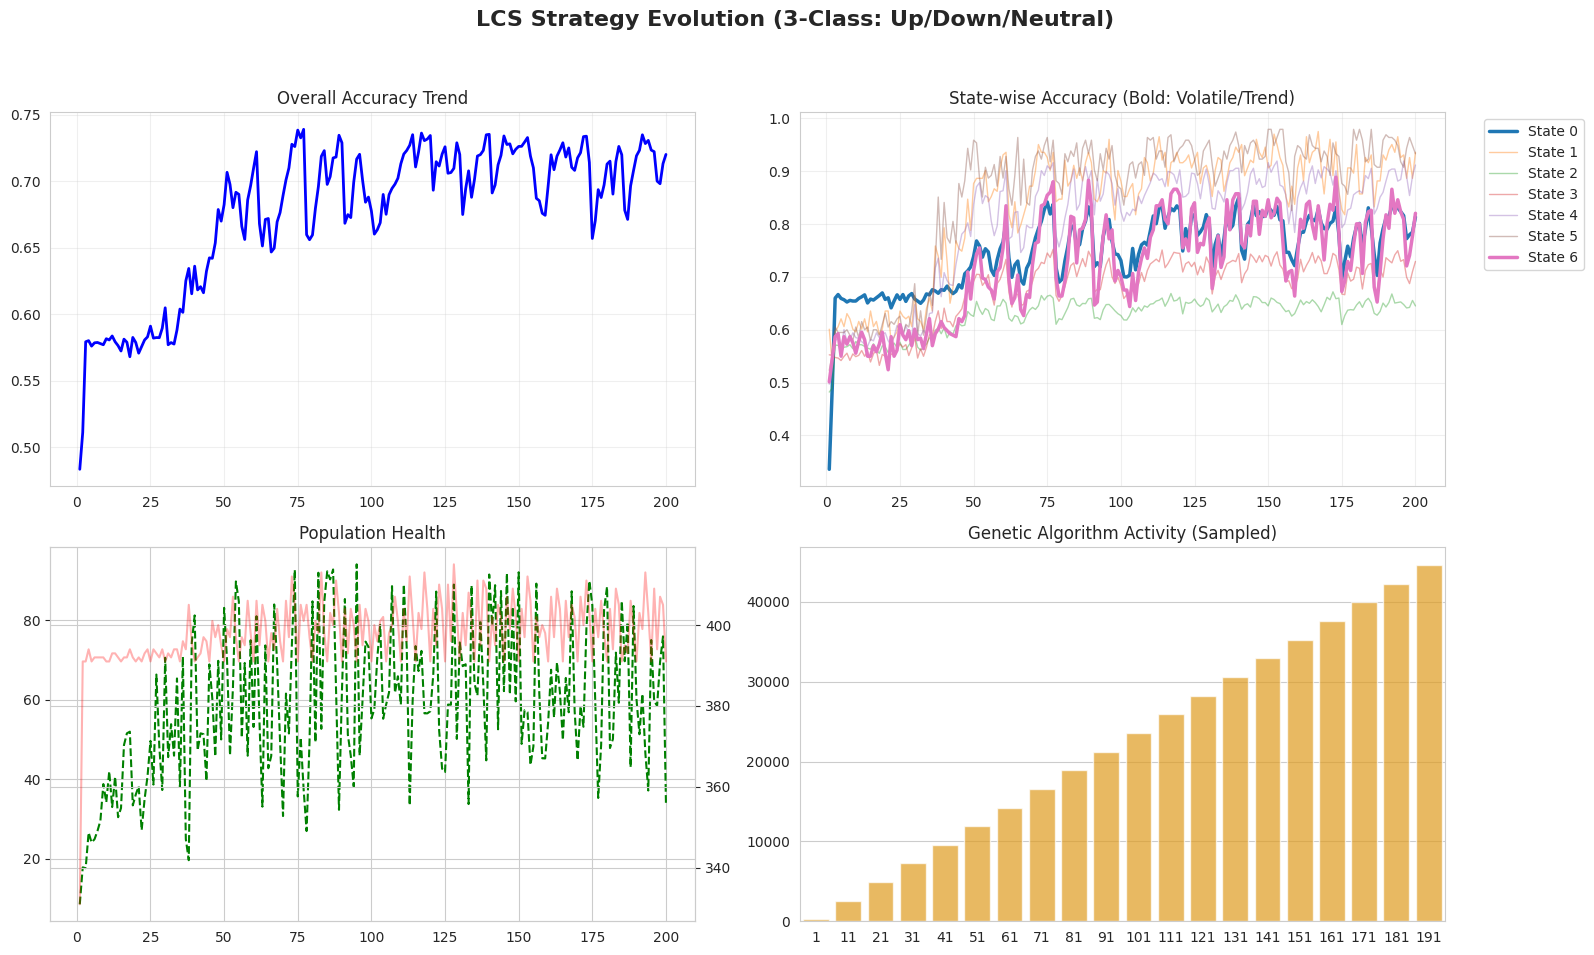

💾 最終規則數: 11

📉 In-Sample (Train) (Rows: 11680) - 3-Class Evaluation

📌 詳細分類報告:
              precision    recall  f1-score   support

 Neutral (0)     0.8717    1.0000    0.9315       367
      Up (1)     1.0000    0.1600    0.2759        25
    Down (2)     1.0000    0.0294    0.0571        34

    accuracy                         0.8732       426
   macro avg     0.9572    0.3965    0.4215       426
weighted avg     0.8895    0.8732    0.8232       426


📌 混淆矩陣 (Row=True, Col=Pred):
             |   Neu    |    Up    |   Down  
----------------------------------------------
    True Neu |   367    |    0     |    0    
     True Up |    21    |    4     |    0    
   True Down |    33    |    0     |    1    

📌 交易關鍵指標 (Precision):
   ➤ 做多準確率 (Up Precision)   : 100.00%
   ➤ 做空準確率 (Down Precision) : 100.00%
   ➤ 覆蓋率 (Coverage)           : 3.65% (426/11680)

📉 Out-of-Sample (Test) (Rows: 2921) - 3-Class Evaluation

📌 詳細分類報告:
              precision    recall  f1-score   support

 Neutr

In [16]:
# @title LCS Strategy (Ternary Classification: Up/Down/Neutral)
import numpy as np
import polars as pl
import pandas as pd
import random
import logging
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import List, Dict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit
from pathlib import Path

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']

# 設定路徑
try:
    OUT_DIR
except NameError:
    OUT_DIR = Path("./")
try:
    INPUT_FILE
except NameError:
    INPUT_FILE = "hmm_features.parquet"

logger = logging.getLogger("LCS_Trader")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter('🔹 %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

def log(msg):
    print(f"🔹 {msg}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    log(f"🌱 Random Seed 已固定為: {seed}")

# ==============================================================================
# 🕵️ 1. 防洩漏檢測模組
# ==============================================================================
def run_leakage_check(df_pl: pl.DataFrame, target_horizon=1):
    print("\n" + "="*60)
    print("🕵️ 執行數據洩漏檢測 (Data Leakage Check)")
    print("="*60)
    df = df_pl.to_pandas()
    target_col = f"Ret_{target_horizon}m"

    if 'hmm_state' in df.columns:
        dummies = pd.get_dummies(df['hmm_state'], prefix='State')
        check_df = pd.concat([df[[target_col]], dummies], axis=1).dropna()
        corr = check_df.corr()[target_col].drop(target_col)
        max_corr = corr.abs().max()

        print(f"📌 HMM State (Rolling) vs {target_col} 最大相關係數: {max_corr:.4f}")
        if max_corr > 0.8:
            print("⚠️ [注意] 狀態與回報相關性極高，請確認回測邏輯是否正確。")
        else:
            print("✅ 檢測通過：無異常線性洩漏跡象。")
    print("="*60 + "\n")

# ==============================================================================
# ⚙️ 2. 資料準備 (三分類改修版)
# ==============================================================================
def prepare_labeled_data(file_path: Path, horizons=[1, 3, 5], base_fee=0.0002):
    """
    修改為三分類邏輯：
    Label 1: 漲 (Up)   -> Return > threshold
    Label 2: 跌 (Down) -> Return < -threshold
    Label 0: 盤整 (Neutral) -> otherwise
    """
    log(f"1. 讀取資料: {file_path}")
    if not file_path.exists():
        log(f"❌ 找不到檔案: {file_path}")
        return None

    try:
        df = pl.read_parquet(file_path)

        # 欄位映射
        rename_map = {
            "HMM_State_Rolling": "hmm_state",
            "Buy_pressure_t_scaled": "bp_score",
            "Emo_score_scaled": "emo_score"
        }

        # 兼容性檢查
        if "Buy_pressure_t" in df.columns and "bp_score" not in rename_map.values():
             rename_map["Buy_pressure_t"] = "bp_score"
        if "Emo_score" in df.columns and "emo_score" not in rename_map.values():
             rename_map["Emo_score"] = "emo_score"

        df = df.rename({k: v for k, v in rename_map.items() if k in df.columns})
        df = df.filter(pl.col("hmm_state") != -1)

    except Exception as e:
        log(f"❌ 讀取失敗: {e}")
        return None

    price_col = "Price" if "Price" in df.columns else "Close"

    # 動態閾值設定 (可根據波動率調整倍數)
    df = df.with_columns(
        pl.when(pl.col("hmm_state") == 3).then(base_fee * 1.5)      # 震盪態提高門檻
          .when(pl.col("hmm_state").is_in([0, 6])).then(base_fee * 2.5) # 極端態大幅提高門檻
          .otherwise(base_fee * 1.8)
          .alias("dynamic_threshold")
    )

    cols_to_keep = ["hmm_state", "bp_score", "emo_score"]

    for h in horizons:
        col_name = f"Ret_{h}m"
        label_name = f"Label_{h}m"

        # 計算未來回報率
        df = df.with_columns((pl.col(price_col).shift(-h) / pl.col(price_col) - 1).alias(col_name))

        # 三分類標註邏輯
        # 1: 漲, 2: 跌, 0: 盤整
        df = df.with_columns(
            pl.when(pl.col(col_name) > pl.col("dynamic_threshold")).then(1)
              .when(pl.col(col_name) < -pl.col("dynamic_threshold")).then(2)
              .otherwise(0).alias(label_name)
        )
        cols_to_keep.append(col_name)
        cols_to_keep.append(label_name)

    return df.select(cols_to_keep).drop_nulls()

def discretize_features(df: pl.DataFrame) -> pd.DataFrame:
    log("2. 進行特徵離散化 (Scaled Data)...")
    df_pd = df.to_pandas()
    state_col = df_pd["hmm_state"].astype(str)

    # 這裡的 bins 依據標準化數據分布設定
    bp_bins = [-np.inf, -0.5, 0.5, np.inf]
    bp_labels = ["L", "N", "H"]
    bp_disc = pd.cut(df_pd["bp_score"], bins=bp_bins, labels=bp_labels)

    emo_bins = [-np.inf, -1.5, -0.5, 0.5, 1.5, np.inf]
    emo_labels = ["LL", "L", "N", "H", "HH"]
    emo_disc = pd.cut(df_pd["emo_score"], bins=emo_bins, labels=emo_labels)

    df_pd["Condition"] = state_col + "-" + bp_disc.astype(str) + "-" + emo_disc.astype(str)
    return df_pd

# ==============================================================================
# 🧬 3. LCS 核心類別 (支援三分類)
# ==============================================================================
@dataclass
class Classifier:
    condition: str
    action: int  # 0: Neutral, 1: Up, 2: Down
    fitness: float = 50.0
    accuracy: float = 0.5
    numerosity: int = 1
    experience: int = 0
    match_count: int = 0

    def update_accuracy(self, is_correct: bool, beta: float, nu: int, weight: float = 1.0):
        reward = 1.0 if is_correct else 0.0
        weighted_beta = min(beta * weight, 0.5)

        self.experience += 1
        if is_correct: self.match_count += 1

        # MAM (Moyenne Adaptative Modifiée) 類似更新
        self.accuracy = self.accuracy + weighted_beta * (reward - self.accuracy)

        # Fitness 依賴於 Accuracy 的冪次，強化高準確規則
        acc_factor = (self.accuracy ** nu) * 100 if self.accuracy > 0.33 else 1.0 # 0.33 是隨機猜測基線
        self.fitness = self.fitness + beta * (acc_factor - self.fitness)

class SimpleLCS:
    def __init__(self, population_size=500, mutation_rate=0.05, beta=0.1, nu=5):
        self.population: List[Classifier] = []
        self.max_pop_size = population_size
        self.mutation_rate = mutation_rate
        self.beta = beta
        self.nu = nu
        self.time_step = 0
        self.ga_count = 0
        self.actions = [0, 1, 2] # 定義動作空間

    def get_match_set(self, condition_input: str) -> List[Classifier]:
        return [cl for cl in self.population if cl.condition == condition_input]

    def cover(self, condition_input: str, label: int):
        # 覆蓋機制：產生一個符合當前標籤的規則
        # 也可以隨機產生，這裡選擇直接產生正確答案以加速收斂
        new_cl = Classifier(condition=condition_input, action=label, fitness=10.0, accuracy=0.5)
        self.population.append(new_cl)

    def predict(self, match_set: List[Classifier]) -> int:
        if not match_set: return 0 # 預設盤整

        votes = {0: 0.0, 1: 0.0, 2: 0.0}
        for cl in match_set:
            votes[cl.action] += cl.fitness * cl.accuracy

        # 找出票數最高的動作
        return max(votes, key=votes.get)

    def run_ga(self, match_set: List[Classifier]):
        if self.time_step % 50 != 0 or not match_set: return

        total_fit = sum(cl.fitness for cl in match_set)
        if total_fit == 0: return

        # 輪盤賭選擇父母
        parent = random.choices(match_set, weights=[cl.fitness for cl in match_set], k=1)[0]
        child = Classifier(condition=parent.condition, action=parent.action)

        # 突變：隨機變成其他動作
        if random.random() < self.mutation_rate:
            possible_actions = list(set(self.actions) - {child.action})
            child.action = random.choice(possible_actions)
            child.accuracy = 0.5
            child.fitness = 10.0
            child.experience = 0

        self.population.append(child)
        self.ga_count += 1

        # 刪除機制 (基於適應度與準確率)
        if len(self.population) > self.max_pop_size:
            self.population.sort(key=lambda x: (x.fitness * 0.7 + x.accuracy * 0.3), reverse=True)
            self.population = self.population[:self.max_pop_size]

    def train_instance(self, condition_input: str, label: int):
        self.time_step += 1

        try:
            current_state = int(condition_input.split("-")[0])
        except:
            current_state = 3

        # 給予特定狀態更高的學習權重
        importance_weight = 1.5 if current_state in [0, 6] else 1.0

        match_set = self.get_match_set(condition_input)
        if not match_set:
            self.cover(condition_input, label)
            match_set = self.get_match_set(condition_input)

        prediction = self.predict(match_set)
        is_correct = (prediction == label)

        for cl in match_set:
            cl.update_accuracy(is_correct, self.beta, self.nu, weight=importance_weight)

        self.run_ga(match_set)
        return is_correct

    def get_population_stats(self):
        if not self.population: return {}
        avg_fit = sum(cl.fitness for cl in self.population) / len(self.population)
        avg_acc = sum(cl.accuracy for cl in self.population) / len(self.population)
        return {"Pop_Size": len(self.population), "Avg_Fit": avg_fit, "Avg_Acc": avg_acc, "GA_Events": self.ga_count}

# ==============================================================================
# 📊 4. 訓練儀表板 (Dashboard)
# ==============================================================================
def plot_lcs_training_history(history):
    epochs = range(1, len(history['total_acc']) + 1)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('LCS Strategy Evolution (3-Class: Up/Down/Neutral)', fontsize=16, fontweight='bold')

    ax1 = axes[0, 0]
    ax1.plot(epochs, history['total_acc'], 'b-', linewidth=2, label='Total Accuracy')
    ax1.set_title('Overall Accuracy Trend')
    ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    active_states = [s for s, accs in history['state_acc'].items() if len(accs) > 0]
    palette = sns.color_palette("tab10", len(active_states))

    for idx, state in enumerate(active_states):
        acc_list = history['state_acc'][state]
        if len(acc_list) != len(epochs): continue
        lw = 2.5 if str(state) in ['0', '6'] else 1.0
        alpha = 1.0 if str(state) in ['0', '6'] else 0.4
        ax2.plot(epochs, acc_list, linewidth=lw, alpha=alpha, label=f'State {state}', color=palette[idx])

    ax2.set_title('State-wise Accuracy (Bold: Volatile/Trend)')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)

    ax3 = axes[1, 0]
    ax3.plot(epochs, history['avg_fit'], 'g--', label='Avg Fitness')
    ax3_twin = ax3.twinx()
    ax3_twin.plot(epochs, history['pop_size'], 'r-', alpha=0.3, label='Rule Count')
    ax3.set_title('Population Health')

    ax4 = axes[1, 1]
    sns.barplot(x=list(epochs)[::10], y=history['ga_events'][::10], ax=ax4, color='orange', alpha=0.7)
    ax4.set_title('Genetic Algorithm Activity (Sampled)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==============================================================================
# 🧪 5. Optuna 目標函數 (適配三分類)
# ==============================================================================
def objective(trial, df_train_full, target_col):
    params = {
        'population_size': trial.suggest_int('population_size', 300, 800),
        'mutation_rate': trial.suggest_float('mutation_rate', 0.05, 0.20),
        'beta': trial.suggest_float('beta', 0.1, 0.4),
        'nu': trial.suggest_int('nu', 3, 8)
    }

    # 由於是三分類，隨機猜測是 0.33，所以門檻要設高一點
    min_acc_threshold = trial.suggest_float('min_acc_threshold', 0.40, 0.55)

    n_splits = 3
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = []

    for fold_idx, (train_index, val_index) in enumerate(tscv.split(df_train_full)):
        lcs = SimpleLCS(**params)
        fold_train_df = df_train_full.iloc[train_index]
        fold_val_df = df_train_full.iloc[val_index]

        conditions = fold_train_df["Condition"].values
        labels = fold_train_df[target_col].values

        # 快速訓練
        indices = np.arange(len(conditions))
        for _ in range(20): # Epochs per fold
            np.random.shuffle(indices)
            for i in indices:
                lcs.train_instance(conditions[i], int(labels[i]))

        # 規則篩選
        rule_map = {}
        valid_rules = [cl for cl in lcs.population if cl.experience >= 10 and cl.accuracy >= min_acc_threshold]
        for cl in valid_rules:
            if cl.condition not in rule_map or cl.fitness > rule_map[cl.condition].fitness:
                rule_map[cl.condition] = cl

        # 驗證
        correct = 0
        covered = 0
        val_conds = fold_val_df["Condition"].values
        val_lbls = fold_val_df[target_col].values

        for i in range(len(val_conds)):
            cond = val_conds[i]
            lbl = int(val_lbls[i])
            if cond in rule_map:
                pred = rule_map[cond].action
                covered += 1
                if pred == lbl: correct += 1

        if covered == 0:
            cv_scores.append(0.0)
        else:
            acc = correct / covered
            # 懲罰覆蓋率過低 (如果規則太少導致沒訊號)
            penalty = 0.5 if (covered / len(fold_val_df)) < 0.1 else 1.0
            cv_scores.append(acc * penalty)

    return np.mean(cv_scores)

# ==============================================================================
# 📊 6. 績效評估函數 (三分類矩陣)
# ==============================================================================
def evaluate_dataset(engine_map, df, target_col, title):
    print("\n" + "="*80)
    print(f"📉 {title} (Rows: {len(df)}) - 3-Class Evaluation")
    print("="*80)

    y_true, y_pred = [], []
    covered_count = 0

    for _, row in df.iterrows():
        cond = row["Condition"]
        lbl = int(row[target_col])

        if cond in engine_map:
            pred = engine_map[cond].action
            y_pred.append(pred)
            y_true.append(lbl)
            covered_count += 1
        else:
            # 未覆蓋的資料通常視為 Neutral (0) 或不交易，這裡為了矩陣對齊，只統計有覆蓋的
            pass

    if not y_true:
        print("⚠️ 無有效訊號觸發。")
        return

    # 標籤定義：0=Neutral, 1=Up, 2=Down
    target_names = ['Neutral (0)', 'Up (1)', 'Down (2)']

    # 確保分類報告能處理缺漏的類別 (例如只預測了 Up 和 Neutral)
    labels_present = sorted(list(set(y_true) | set(y_pred)))
    target_names_present = [target_names[i] for i in labels_present]

    print("\n📌 詳細分類報告:")
    print(classification_report(y_true, y_pred, labels=labels_present, target_names=target_names_present, digits=4))

    # 混淆矩陣
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    print("\n📌 混淆矩陣 (Row=True, Col=Pred):")
    print(f"{'':>12} | {'Neu':^8} | {'Up':^8} | {'Down':^8}")
    print("-" * 46)
    print(f"{'True Neu':>12} | {cm[0,0]:^8} | {cm[0,1]:^8} | {cm[0,2]:^8}")
    print(f"{'True Up':>12} | {cm[1,0]:^8} | {cm[1,1]:^8} | {cm[1,2]:^8}")
    print(f"{'True Down':>12} | {cm[2,0]:^8} | {cm[2,1]:^8} | {cm[2,2]:^8}")

    # 交易者關注指標
    up_precision = cm[1,1] / (cm[0,1] + cm[1,1] + cm[2,1]) if (cm[0,1] + cm[1,1] + cm[2,1]) > 0 else 0
    down_precision = cm[2,2] / (cm[0,2] + cm[1,2] + cm[2,2]) if (cm[0,2] + cm[1,2] + cm[2,2]) > 0 else 0

    print("\n📌 交易關鍵指標 (Precision):")
    print(f"   ➤ 做多準確率 (Up Precision)   : {up_precision:.2%}")
    print(f"   ➤ 做空準確率 (Down Precision) : {down_precision:.2%}")
    print(f"   ➤ 覆蓋率 (Coverage)           : {covered_count/len(df):.2%} ({covered_count}/{len(df)})")

# ==============================================================================
# 🚀 7. 主程式
# ==============================================================================
def main():
    set_seed(42)
    full_path = OUT_DIR / INPUT_FILE
    TARGET_HORIZON = 1

    # 1. 資料準備 (三分類)
    df_pl = prepare_labeled_data(full_path, horizons=[1, 3, 5])
    if df_pl is None: return

    run_leakage_check(df_pl, TARGET_HORIZON)

    # 2. 特徵離散化
    df_disc = discretize_features(df_pl)
    target_col = f"Label_{TARGET_HORIZON}m"

    # 移除標籤計算失敗的資料 (Label -1 若存在)
    df_clean = df_disc.copy()

    # 3. 切分資料
    split_idx = int(len(df_clean) * 0.8)
    train_data = df_clean.iloc[:split_idx].copy()
    test_data = df_clean.iloc[split_idx:].copy()

    log(f"📌 資料切分: Train={len(train_data)}, Test={len(test_data)}")

    # 4. Optuna 搜尋
    print("\n🔍 開始 Optuna 參數搜尋 (3-Class Optimization)...")
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: objective(trial, train_data, target_col), n_trials=15) # 試驗次數可調整

    best_params = study.best_params
    min_acc_cutoff = best_params.pop('min_acc_threshold')
    print(f"\n✅ 最佳參數: {best_params}")
    print(f"🎯 篩選門檻: {min_acc_cutoff:.2%}")

    # 5. 最終訓練
    print("\n🚀 啟動 LCS 最終訓練...")
    final_lcs = SimpleLCS(**best_params)

    conditions = train_data["Condition"].values
    labels = train_data[target_col].values
    states_list = train_data["Condition"].apply(lambda x: x.split("-")[0]).values

    history = {"total_acc": [], "avg_fit": [], "pop_size": [], "ga_events": [], "state_acc": {}}
    unique_states = np.unique(states_list)
    for s in unique_states: history["state_acc"][s] = []

    EPOCHS = 200
    for epoch in range(EPOCHS):
        indices = np.arange(len(conditions))
        np.random.shuffle(indices)

        epoch_correct = 0
        state_correct = {s: 0 for s in unique_states}
        state_counts = {s: 0 for s in unique_states}

        for i in indices:
            s_key = states_list[i]
            is_correct = final_lcs.train_instance(conditions[i], int(labels[i]))
            if is_correct:
                epoch_correct += 1
                state_correct[s_key] += 1
            state_counts[s_key] += 1

        total_acc = epoch_correct / len(conditions)
        pop_stats = final_lcs.get_population_stats()

        history["total_acc"].append(total_acc)
        history["avg_fit"].append(pop_stats.get('Avg_Fit', 0))
        history["pop_size"].append(pop_stats.get('Pop_Size', 0))
        history["ga_events"].append(pop_stats.get('GA_Events', 0))

        for s in unique_states:
            acc = state_correct[s] / state_counts[s] if state_counts[s] > 0 else 0.0
            history["state_acc"][s].append(acc)

        if (epoch+1) % 20 == 0:
            print(f"   Epoch {epoch+1}/{EPOCHS} | Acc: {total_acc:.2%}")

    plot_lcs_training_history(history)

    # 6. 匯出規則
    final_rules = [cl for cl in final_lcs.population if cl.experience >= 20 and cl.accuracy >= min_acc_cutoff]
    unique_rules = {}
    for cl in final_rules:
        if cl.condition not in unique_rules or cl.fitness > unique_rules[cl.condition].fitness:
            unique_rules[cl.condition] = cl

    best_rules_list = sorted(list(unique_rules.values()), key=lambda x: x.fitness, reverse=True)
    engine_map = {r.condition: r for r in best_rules_list}

    print(f"💾 最終規則數: {len(best_rules_list)}")

    rule_data = []
    action_map = {0: "NEUTRAL", 1: "BUY", 2: "SELL"}
    for rule in best_rules_list:
        rule_data.append({
            "Condition": rule.condition,
            "Action": action_map[rule.action],
            "Accuracy": rule.accuracy,
            "Fitness": rule.fitness,
            "Exp": rule.experience
        })

    pd.DataFrame(rule_data).to_csv(OUT_DIR / "lcs_rules_ternary.csv", index=False)

    # 7. 評估
    evaluate_dataset(engine_map, train_data, target_col, "In-Sample (Train)")
    evaluate_dataset(engine_map, test_data, target_col, "Out-of-Sample (Test)")

if __name__ == "__main__":
    main()

In [21]:
# @title LCS Strategy (Ternary Classification: Up/Down/Neutral)
import numpy as np
import polars as pl
import pandas as pd
import random
import logging
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import List
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit
from pathlib import Path

sns.set_style("whitegrid")



def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)

# ==============================================================================
# 1. 資料準備（三分類 + 狀態專屬 threshold）
# ==============================================================================
def prepare_labeled_data(file_path: Path, horizons=[1], base_fee=0.0001):  # ★ MOD
    df = pl.read_parquet(file_path)

    df = df.rename({
        "HMM_State_Rolling": "hmm_state",
        "Buy_pressure_t_scaled": "bp_score",
        "Emo_score_scaled": "emo_score"
    })

    df = df.filter(pl.col("hmm_state") != -1)

    price_col = "Price" if "Price" in df.columns else "Close"

    # ★ MOD：狀態專屬 threshold（趨勢態更容易出手）
    df = df.with_columns(
        pl.when(pl.col("hmm_state").is_in([0, 6])).then(base_fee * 0.8)
        .when(pl.col("hmm_state") == 3).then(base_fee * 2.5)
        .otherwise(base_fee * 1.2)
        .alias("dynamic_threshold")
    )

    for h in horizons:
        ret_col = f"Ret_{h}m"
        lbl_col = f"Label_{h}m"

        df = df.with_columns(
            (pl.col(price_col).shift(-h) / pl.col(price_col) - 1).alias(ret_col)
        )

        df = df.with_columns(
            pl.when(pl.col(ret_col) > pl.col("dynamic_threshold")).then(1)
            .when(pl.col(ret_col) < -pl.col("dynamic_threshold")).then(2)
            .otherwise(0)
            .alias(lbl_col)
        )

    return df.select(["hmm_state", "bp_score", "emo_score", "Label_1m"]).drop_nulls()

# ==============================================================================
# 2. 離散化（縮小 condition space → 提升 coverage）
# ==============================================================================
def discretize_features(df: pl.DataFrame) -> pd.DataFrame:
    df = df.to_pandas()
    df["Condition"] = (
        df["hmm_state"].astype(str)
        + "-" + pd.cut(df["bp_score"], [-np.inf, 0, np.inf], labels=["L", "H"]).astype(str)
        + "-" + pd.cut(df["emo_score"], [-np.inf, -0.5, 0.5, np.inf], labels=["L", "N", "H"]).astype(str)
    )
    return df

# ==============================================================================
# 3. LCS 核心（僅加權，不改結構）
# ==============================================================================
@dataclass
class Classifier:
    condition: str
    action: int
    fitness: float = 10.0
    accuracy: float = 0.5
    experience: int = 0

    def update(self, is_correct, beta, nu, weight):
        reward = 1.0 if is_correct else 0.0
        self.experience += 1
        self.accuracy += beta * weight * (reward - self.accuracy)
        self.fitness += beta * ((self.accuracy ** nu) * 100 - self.fitness)

class SimpleLCS:
    def __init__(self, population_size=600, mutation_rate=0.1, beta=0.2, nu=5):
        self.population = []
        self.max_pop = population_size
        self.mutation_rate = mutation_rate
        self.beta = beta
        self.nu = nu
        self.actions = [0, 1, 2]

    def get_match(self, cond):
        return [c for c in self.population if c.condition == cond]

    def cover(self, cond, label):
        self.population.append(Classifier(cond, label))

    def predict(self, match):
        votes = {0: 0, 1: 0, 2: 0}
        for c in match:
            votes[c.action] += c.fitness * c.accuracy
        return max(votes, key=votes.get)

    def train_instance(self, cond, label):
        match = self.get_match(cond)
        if not match:
            self.cover(cond, label)
            match = self.get_match(cond)

        pred = self.predict(match)
        is_correct = pred == label

        # ★ MOD：猜對漲跌給更高權重
        weight = 1.0
        if label in [1, 2] and is_correct:
            weight = 1.5

        for c in match:
            c.update(is_correct, self.beta, self.nu, weight)

# ==============================================================================
# 4. 主程式
# ==============================================================================
def main():
    set_seed(42)

    df_pl = prepare_labeled_data(OUT_DIR / INPUT_FILE)
    df = discretize_features(df_pl)

    train = df.iloc[: int(len(df) * 0.8)]
    test = df.iloc[int(len(df) * 0.8):]

    lcs = SimpleLCS()

    for _ in range(150):
        for _, r in train.iterrows():
            lcs.train_instance(r["Condition"], int(r["Label_1m"]))

    rules = {
        c.condition: c
        for c in lcs.population
        if c.experience >= 20 and c.accuracy >= 0.55
    }

    def eval(df, name):
        y_t, y_p = [], []
        for _, r in df.iterrows():
            if r["Condition"] in rules:
                y_t.append(r["Label_1m"])
                y_p.append(rules[r["Condition"]].action)

        print(f"\n{name} coverage: {len(y_t)/len(df):.2%}")
        print(classification_report(y_t, y_p, digits=4))

    eval(train, "Train")
    eval(test, "Test")

if __name__ == "__main__":
    main()



Train coverage: 17.10%
              precision    recall  f1-score   support

           0     0.4919    0.7045    0.5793       819
           1     0.5028    0.1609    0.2438       553
           2     0.5833    0.6038    0.5934       626

    accuracy                         0.5225      1998
   macro avg     0.5260    0.4898    0.4722      1998
weighted avg     0.5236    0.5225    0.4909      1998


Test coverage: 20.77%
              precision    recall  f1-score   support

           0     0.5918    0.5874    0.5896       269
           1     0.5263    0.1351    0.2151       148
           2     0.4636    0.7368    0.5691       190

    accuracy                         0.5239       607
   macro avg     0.5272    0.4864    0.4579       607
weighted avg     0.5357    0.5239    0.4918       607



[I 2026-01-31 04:03:02,215] A new study created in memory with name: no-name-c19eed68-57d5-429e-a9df-f84f3385c295


🔹 🌱 Random Seed 已固定為: 42
🔹 1. 讀取資料: output_v全域版/step4_features_with_hmm.parquet

🕵️ 執行數據洩漏檢測 (Data Leakage Check)
📌 HMM State (Rolling) vs Ret_1m 最大相關係數: 0.0133
✅ 檢測通過：無異常線性洩漏跡象。

🔹 2. 進行特徵離散化 (Quantile Binning)...

🔍 Optuna 參數搜尋中...


[I 2026-01-31 04:03:22,116] Trial 0 finished with value: 0.5166717956811206 and parameters: {'population_size': 1057, 'mutation_rate': 0.2051054737798978, 'beta': 0.3785971702058152, 'nu': 8, 'min_acc_threshold': 0.4479761268208974}. Best is trial 0 with value: 0.5166717956811206.
[I 2026-01-31 04:03:35,952] Trial 1 finished with value: 0.5195797100208175 and parameters: {'population_size': 1114, 'mutation_rate': 0.1726446772661426, 'beta': 0.3810062477954967, 'nu': 5, 'min_acc_threshold': 0.3962283204228834}. Best is trial 1 with value: 0.5195797100208175.
[I 2026-01-31 04:03:49,560] Trial 2 finished with value: 0.5210453333720956 and parameters: {'population_size': 1065, 'mutation_rate': 0.1847622490243332, 'beta': 0.3957030267044175, 'nu': 9, 'min_acc_threshold': 0.41566295976216683}. Best is trial 2 with value: 0.5210453333720956.
[I 2026-01-31 04:04:01,823] Trial 3 finished with value: 0.5145436688424909 and parameters: {'population_size': 964, 'mutation_rate': 0.1658715970828264,


✅ 最佳參數: {'population_size': 898, 'mutation_rate': 0.11739703407130508, 'beta': 0.4499330196023774, 'nu': 10}, 門檻: 44.01%


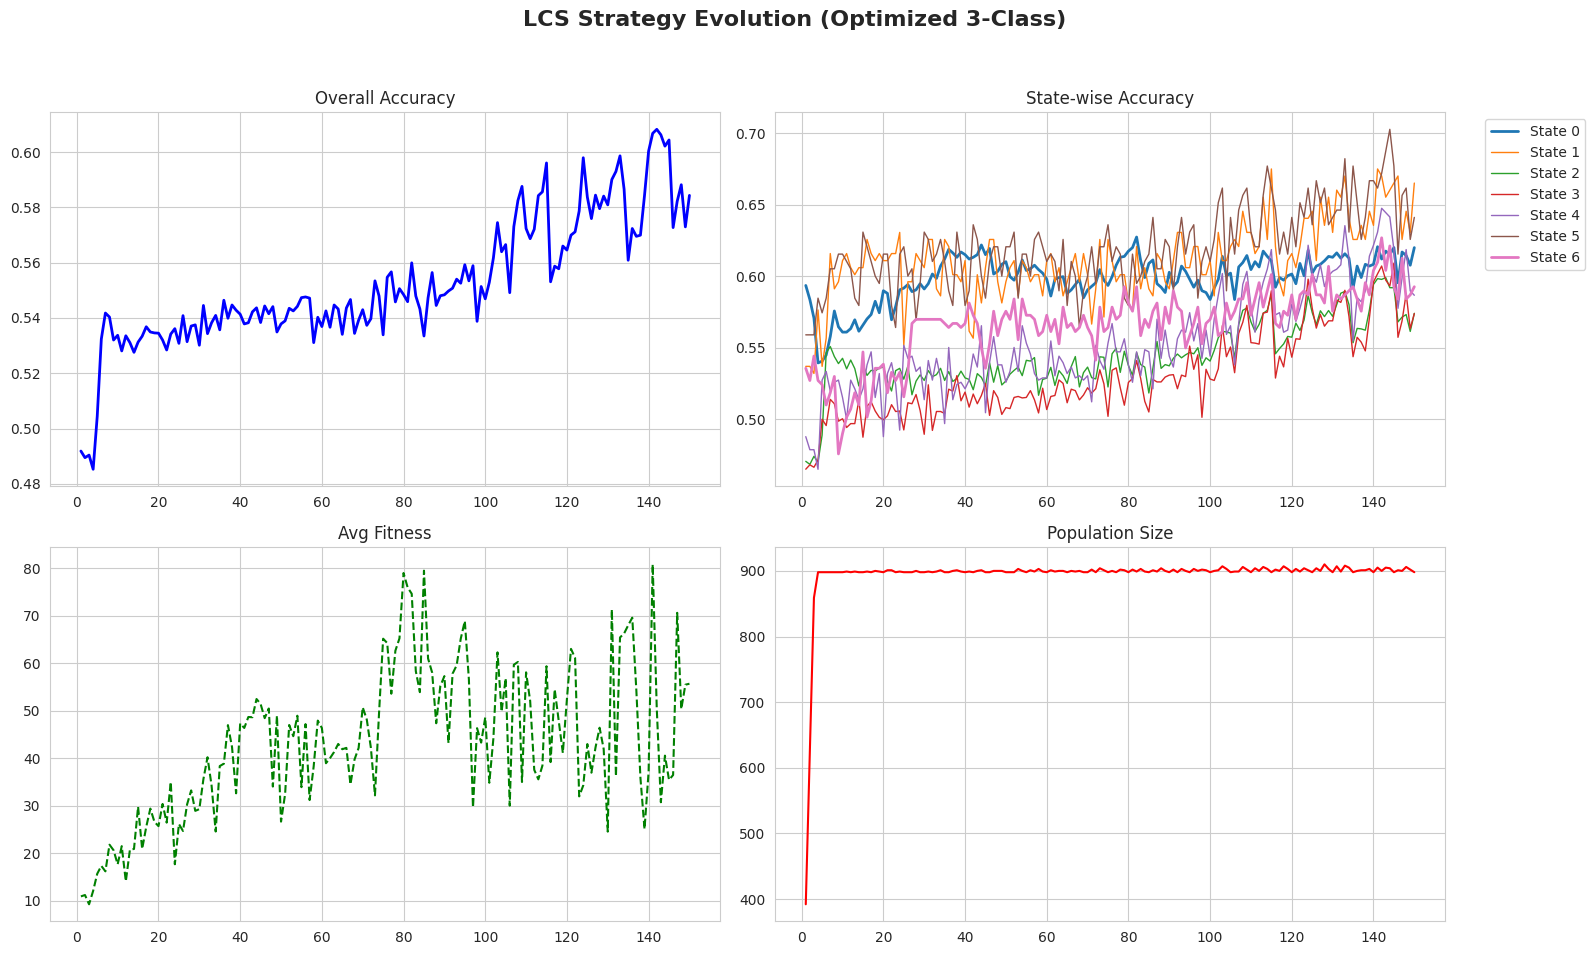


📉 In-Sample (Rows: 11680)

📌 分類報告:
              precision    recall  f1-score   support

 Neutral (0)     0.6365    0.6820    0.6584       978
      Up (1)     0.1355    0.2101    0.1647       238
    Down (2)     0.2222    0.0095    0.0183       210

    accuracy                         0.5042      1426
   macro avg     0.3314    0.3005    0.2805      1426
weighted avg     0.4918    0.5042    0.4818      1426

➤ 做多準確率: 13.55%
➤ 做空準確率: 22.22%
➤ 覆蓋率: 12.21% (1426/11680)

📉 Out-of-Sample (Rows: 2921)

📌 分類報告:
              precision    recall  f1-score   support

 Neutral (0)     0.5742    0.9319    0.7106       191
      Up (1)     0.4348    0.1316    0.2020        76
    Down (2)     0.0000    0.0000    0.0000        68

    accuracy                         0.5612       335
   macro avg     0.3363    0.3545    0.3042       335
weighted avg     0.4260    0.5612    0.4510       335

➤ 做多準確率: 43.48%
➤ 做空準確率: 0.00%
➤ 覆蓋率: 11.47% (335/2921)

🛡️ 實戰過濾門檻調整為 Accuracy >= 50.50%


In [23]:
# @title LCS Strategy (Ternary Classification: Up/Down/Neutral) - Optimized Version
import numpy as np
import polars as pl
import pandas as pd
import random
import logging
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import List, Dict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit
from pathlib import Path

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']

# 設定路徑
try:
    OUT_DIR
except NameError:
    OUT_DIR = Path("./")
try:
    INPUT_FILE
except NameError:
    INPUT_FILE = "hmm_features.parquet"

logger = logging.getLogger("LCS_Trader")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter('🔹 %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

def log(msg):
    print(f"🔹 {msg}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    log(f"🌱 Random Seed 已固定為: {seed}")

# ==============================================================================
# 🕵️ 1. 防洩漏檢測模組
# ==============================================================================
def run_leakage_check(df_pl: pl.DataFrame, target_horizon=1):
    print("\n" + "="*60)
    print("🕵️ 執行數據洩漏檢測 (Data Leakage Check)")
    print("="*60)
    df = df_pl.to_pandas()
    target_col = f"Ret_{target_horizon}m"

    if 'hmm_state' in df.columns:
        dummies = pd.get_dummies(df['hmm_state'], prefix='State')
        check_df = pd.concat([df[[target_col]], dummies], axis=1).dropna()
        corr = check_df.corr()[target_col].drop(target_col)
        max_corr = corr.abs().max()

        print(f"📌 HMM State (Rolling) vs {target_col} 最大相關係數: {max_corr:.4f}")
        if max_corr > 0.8:
            print("⚠️ [注意] 狀態與回報相關性極高，請確認回測邏輯是否正確。")
        else:
            print("✅ 檢測通過：無異常線性洩漏跡象。")
    print("="*60 + "\n")

# ==============================================================================
# ⚙️ 2. 資料準備 (修正版：增加樣本筆數)
# ==============================================================================
def prepare_labeled_data(file_path: Path, horizons=[1, 3, 5], base_fee=0.0002):
    log(f"1. 讀取資料: {file_path}")
    if not file_path.exists():
        log(f"❌ 找不到檔案: {file_path}")
        return None

    try:
        df = pl.read_parquet(file_path)
        rename_map = {
            "HMM_State_Rolling": "hmm_state",
            "Buy_pressure_t_scaled": "bp_score",
            "Emo_score_scaled": "emo_score"
        }
        if "Buy_pressure_t" in df.columns and "bp_score" not in rename_map.values():
             rename_map["Buy_pressure_t"] = "bp_score"
        if "Emo_score" in df.columns and "emo_score" not in rename_map.values():
             rename_map["Emo_score"] = "emo_score"

        df = df.rename({k: v for k, v in rename_map.items() if k in df.columns})
        df = df.filter(pl.col("hmm_state") != -1)
    except Exception as e:
        log(f"❌ 讀取失敗: {e}")
        return None

    price_col = "Price" if "Price" in df.columns else "Close"

    # 【調整】降低門檻，讓非盤整標籤出現機率增加
    df = df.with_columns(
        pl.when(pl.col("hmm_state") == 3).then(base_fee * 1.1)
          .when(pl.col("hmm_state").is_in([0, 6])).then(base_fee * 1.5)
          .otherwise(base_fee * 1.3)
          .alias("dynamic_threshold")
    )

    cols_to_keep = ["hmm_state", "bp_score", "emo_score"]
    for h in horizons:
        col_name = f"Ret_{h}m"
        label_name = f"Label_{h}m"
        df = df.with_columns((pl.col(price_col).shift(-h) / pl.col(price_col) - 1).alias(col_name))
        df = df.with_columns(
            pl.when(pl.col(col_name) > pl.col("dynamic_threshold")).then(1)
              .when(pl.col(col_name) < -pl.col("dynamic_threshold")).then(2)
              .otherwise(0).alias(label_name)
        )
        cols_to_keep.append(col_name)
        cols_to_keep.append(label_name)

    return df.select(cols_to_keep).drop_nulls()

def discretize_features(df: pl.DataFrame) -> pd.DataFrame:
    log("2. 進行特徵離散化 (Quantile Binning)...")
    df_pd = df.to_pandas()
    state_col = df_pd["hmm_state"].astype(str)

    # 【修正】改用 qcut (分位數切分)，將數據強制等分為 5 份
    # Labels: Very Low, Low, Neutral, High, Very High
    # 這樣可以確保極端值被獨立出來，不會混在中間
    try:
        bp_disc = pd.qcut(df_pd["bp_score"], q=5, labels=["VL", "L", "N", "H", "VH"])
    except ValueError: # 防止數據過度集中導致無法切分
        bp_disc = pd.cut(df_pd["bp_score"], bins=5, labels=["VL", "L", "N", "H", "VH"])

    try:
        emo_disc = pd.qcut(df_pd["emo_score"], q=5, labels=["VL", "L", "N", "H", "VH"])
    except ValueError:
        emo_disc = pd.cut(df_pd["emo_score"], bins=5, labels=["VL", "L", "N", "H", "VH"])

    df_pd["Condition"] = state_col + "-" + bp_disc.astype(str) + "-" + emo_disc.astype(str)
    return df_pd

# ==============================================================================
# 🧬 3. LCS 核心類別 (修正版：漲跌加分邏輯)
# ==============================================================================
@dataclass
class Classifier:
    condition: str
    action: int  # 0: Neutral, 1: Up, 2: Down
    fitness: float = 50.0
    accuracy: float = 0.5
    numerosity: int = 1
    experience: int = 0
    match_count: int = 0

    def update_accuracy(self, is_correct: bool, beta: float, nu: int, weight: float = 1.0):
        reward = 1.0 if is_correct else 0.0

        # 如果猜錯 (reward=0) 且動作不是盤整 (Action != 0)，給予懲罰權重
        # 這會讓隨便亂喊單的規則加速死亡
        penalty_weight = 1.5 if (not is_correct and self.action != 0) else 1.0

        weighted_beta = min(beta * weight * penalty_weight, 1.0) # 限制最大不超過 1

        self.experience += 1
        if is_correct: self.match_count += 1

        self.accuracy = self.accuracy + weighted_beta * (reward - self.accuracy)

        # 猜對漲跌加分 (保持原樣)
        action_bonus = 1.2 if (is_correct and self.action in [1, 2]) else 1.0

        # 【新增】猜錯懲罰：如果猜錯，適應度打折
        fitness_penalty = 0.8 if (not is_correct and self.action != 0) else 1.0

        acc_factor = (self.accuracy ** nu) * 100 if self.accuracy > 0.33 else 1.0

        # 套用 bonus 和 penalty
        target_fitness = acc_factor * action_bonus * fitness_penalty
        self.fitness = self.fitness + beta * (target_fitness - self.fitness)

class SimpleLCS:
    def __init__(self, population_size=500, mutation_rate=0.05, beta=0.1, nu=5):
        self.population: List[Classifier] = []
        self.max_pop_size = population_size
        self.mutation_rate = mutation_rate
        self.beta = beta
        self.nu = nu
        self.time_step = 0
        self.ga_count = 0
        self.actions = [0, 1, 2]

    def get_match_set(self, condition_input: str) -> List[Classifier]:
        return [cl for cl in self.population if cl.condition == condition_input]

    def cover(self, condition_input: str, label: int):
        new_cl = Classifier(condition=condition_input, action=label, fitness=10.0, accuracy=0.5)
        self.population.append(new_cl)

    def predict(self, match_set: List[Classifier]) -> int:
        if not match_set: return 0
        votes = {0: 0.0, 1: 0.0, 2: 0.0}
        for cl in match_set:
            votes[cl.action] += cl.fitness * cl.accuracy
        return max(votes, key=votes.get)

    def run_ga(self, match_set: List[Classifier]):
        if self.time_step % 50 != 0 or not match_set: return
        total_fit = sum(cl.fitness for cl in match_set)
        if total_fit == 0: return

        parent = random.choices(match_set, weights=[cl.fitness for cl in match_set], k=1)[0]
        child = Classifier(condition=parent.condition, action=parent.action)

        if random.random() < self.mutation_rate:
            possible_actions = list(set(self.actions) - {child.action})
            child.action = random.choice(possible_actions)
            child.accuracy = 0.5
            child.fitness = 10.0
            child.experience = 0

        self.population.append(child)
        self.ga_count += 1

        if len(self.population) > self.max_pop_size:
            self.population.sort(key=lambda x: (x.fitness * 0.8 + x.accuracy * 0.2), reverse=True)
            self.population = self.population[:self.max_pop_size]

    def train_instance(self, condition_input: str, label: int):
        self.time_step += 1
        try:
            current_state = int(condition_input.split("-")[0])
        except:
            current_state = 3
        importance_weight = 1.5 if current_state in [0, 6] else 1.0
        match_set = self.get_match_set(condition_input)
        if not match_set:
            self.cover(condition_input, label)
            match_set = self.get_match_set(condition_input)

        prediction = self.predict(match_set)
        is_correct = (prediction == label)
        for cl in match_set:
            cl.update_accuracy(is_correct, self.beta, self.nu, weight=importance_weight)
        self.run_ga(match_set)
        return is_correct

    def get_population_stats(self):
        if not self.population: return {}
        avg_fit = sum(cl.fitness for cl in self.population) / len(self.population)
        avg_acc = sum(cl.accuracy for cl in self.population) / len(self.population)
        return {"Pop_Size": len(self.population), "Avg_Fit": avg_fit, "Avg_Acc": avg_acc, "GA_Events": self.ga_count}

# ==============================================================================
# 📊 4. 訓練儀表板 (Dashboard)
# ==============================================================================
def plot_lcs_training_history(history):
    epochs = range(1, len(history['total_acc']) + 1)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('LCS Strategy Evolution (Optimized 3-Class)', fontsize=16, fontweight='bold')
    ax1 = axes[0, 0]
    ax1.plot(epochs, history['total_acc'], 'b-', linewidth=2)
    ax1.set_title('Overall Accuracy')
    ax2 = axes[0, 1]
    active_states = [s for s, accs in history['state_acc'].items() if len(accs) > 0]
    palette = sns.color_palette("tab10", len(active_states))
    for idx, state in enumerate(active_states):
        acc_list = history['state_acc'][state]
        if len(acc_list) != len(epochs): continue
        lw = 2.0 if str(state) in ['0', '6'] else 1.0
        ax2.plot(epochs, acc_list, linewidth=lw, label=f'State {state}', color=palette[idx])
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.set_title('State-wise Accuracy')
    ax3 = axes[1, 0]
    ax3.plot(epochs, history['avg_fit'], 'g--')
    ax3.set_title('Avg Fitness')
    ax4 = axes[1, 1]
    ax4.plot(epochs, history['pop_size'], 'r-')
    ax4.set_title('Population Size')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==============================================================================
# 🧪 5. Optuna 目標函數 (修正區間)
# ==============================================================================
def objective(trial, df_train_full, target_col):
    params = {
        'population_size': trial.suggest_int('population_size', 500, 1200),
        'mutation_rate': trial.suggest_float('mutation_rate', 0.08, 0.25),
        'beta': trial.suggest_float('beta', 0.15, 0.45),
        'nu': trial.suggest_int('nu', 4, 10)
    }

    # 【修正】下修門檻區間，增加規則通過的可能性
    min_acc_threshold = trial.suggest_float('min_acc_threshold', 0.35, 0.48)

    tscv = TimeSeriesSplit(n_splits=3)
    cv_scores = []

    for fold_idx, (train_index, val_index) in enumerate(tscv.split(df_train_full)):
        lcs = SimpleLCS(**params)
        fold_train_df = df_train_full.iloc[train_index]
        fold_val_df = df_train_full.iloc[val_index]
        conditions = fold_train_df["Condition"].values
        labels = fold_train_df[target_col].values

        indices = np.arange(len(conditions))
        for _ in range(15): # 每折訓練輪數
            np.random.shuffle(indices)
            for i in indices:
                lcs.train_instance(conditions[i], int(labels[i]))

        rule_map = {}
        # 經驗值門檻下修至 10
        valid_rules = [cl for cl in lcs.population if cl.experience >= 10 and cl.accuracy >= min_acc_threshold]
        for cl in valid_rules:
            if cl.condition not in rule_map or cl.fitness > rule_map[cl.condition].fitness:
                rule_map[cl.condition] = cl

        correct, covered = 0, 0
        val_conds, val_lbls = fold_val_df["Condition"].values, fold_val_df[target_col].values
        for i in range(len(val_conds)):
            cond = val_conds[i]
            lbl = int(val_lbls[i])
            if cond in rule_map:
                pred = rule_map[cond].action
                covered += 1
                if pred == lbl: correct += 1

        if covered == 0:
            cv_scores.append(0.0)
        else:
            acc = correct / covered
            # 覆蓋率懲罰稍微放寬
            coverage_rate = covered / len(fold_val_df)
            penalty = 1.0 if coverage_rate > 0.05 else (coverage_rate * 20)
            cv_scores.append(acc * penalty)

    return np.mean(cv_scores)

# ==============================================================================
# 📊 6. 績效評估函數
# ==============================================================================
def evaluate_dataset(engine_map, df, target_col, title):
    print("\n" + "="*80)
    print(f"📉 {title} (Rows: {len(df)})")
    print("="*80)

    y_true, y_pred = [], []
    covered_count = 0
    for _, row in df.iterrows():
        cond = row["Condition"]
        lbl = int(row[target_col])
        if cond in engine_map:
            y_pred.append(engine_map[cond].action)
            y_true.append(lbl)
            covered_count += 1

    if not y_true:
        print("⚠️ 無有效訊號。")
        return

    target_names = ['Neutral (0)', 'Up (1)', 'Down (2)']
    labels_present = sorted(list(set(y_true) | set(y_pred)))
    target_names_present = [target_names[i] for i in labels_present]

    print("\n📌 分類報告:")
    print(classification_report(y_true, y_pred, labels=labels_present, target_names=target_names_present, digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    up_precision = cm[1,1] / cm[:,1].sum() if cm[:,1].sum() > 0 else 0
    down_precision = cm[2,2] / cm[:,2].sum() if cm[:,2].sum() > 0 else 0

    print(f"➤ 做多準確率: {up_precision:.2%}")
    print(f"➤ 做空準確率: {down_precision:.2%}")
    print(f"➤ 覆蓋率: {covered_count/len(df):.2%} ({covered_count}/{len(df)})")

# ==============================================================================
# 🚀 7. 主程式
# ==============================================================================
def main():
    set_seed(42)
    full_path = OUT_DIR / INPUT_FILE
    TARGET_HORIZON = 1

    df_pl = prepare_labeled_data(full_path, horizons=[1, 3, 5])
    if df_pl is None: return
    run_leakage_check(df_pl, TARGET_HORIZON)

    df_disc = discretize_features(df_pl)
    target_col = f"Label_{TARGET_HORIZON}m"

    split_idx = int(len(df_disc) * 0.8)
    train_data = df_disc.iloc[:split_idx].copy()
    test_data = df_disc.iloc[split_idx:].copy()

    print("\n🔍 Optuna 參數搜尋中...")
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, train_data, target_col), n_trials=20)

    best_params = study.best_params
    min_acc_cutoff = best_params.pop('min_acc_threshold')
    print(f"\n✅ 最佳參數: {best_params}, 門檻: {min_acc_cutoff:.2%}")

    final_lcs = SimpleLCS(**best_params)
    conditions = train_data["Condition"].values
    labels = train_data[target_col].values
    states_list = train_data["Condition"].apply(lambda x: x.split("-")[0]).values

    unique_states = np.unique(states_list)
    history = {"total_acc": [], "avg_fit": [], "pop_size": [], "state_acc": {s: [] for s in unique_states}}

    EPOCHS = 150 # 稍微縮短訓練，靠權重加強
    for epoch in range(EPOCHS):
        indices = np.arange(len(conditions))
        np.random.shuffle(indices)
        correct, s_correct, s_counts = 0, {s: 0 for s in unique_states}, {s: 0 for s in unique_states}

        for i in indices:
            res = final_lcs.train_instance(conditions[i], int(labels[i]))
            s_key = states_list[i]
            if res:
                correct += 1
                s_correct[s_key] += 1
            s_counts[s_key] += 1

        history["total_acc"].append(correct / len(conditions))
        stats = final_lcs.get_population_stats()
        history["avg_fit"].append(stats['Avg_Fit'])
        history["pop_size"].append(stats['Pop_Size'])
        for s in unique_states:
            history["state_acc"][s].append(s_correct[s]/s_counts[s] if s_counts[s]>0 else 0)

    plot_lcs_training_history(history)

    # 匯出規則 (放寬門檻)
    final_rules = [cl for cl in final_lcs.population if cl.experience >= 10 and cl.accuracy >= min_acc_cutoff]
    unique_rules = {}
    for cl in final_rules:
        if cl.condition not in unique_rules or cl.fitness > unique_rules[cl.condition].fitness:
            unique_rules[cl.condition] = cl

    engine_map = {r.condition: r for r in unique_rules.values()}
    evaluate_dataset(engine_map, train_data, target_col, "In-Sample")
    evaluate_dataset(engine_map, test_data, target_col, "Out-of-Sample")

    trading_threshold = max(min_acc_cutoff, 0.505)
    print(f"\n🛡️ 實戰過濾門檻調整為 Accuracy >= {trading_threshold:.2%}")

    final_rules = [cl for cl in final_lcs.population if cl.experience >= 15 and cl.accuracy >= trading_threshold]

if __name__ == "__main__":
    main()

[I 2026-01-31 04:34:54,615] A new study created in memory with name: no-name-16284448-e47b-476e-8486-eb853a14af32


🔹 🌱 Random Seed 已固定為: 42
🔹 1. 讀取資料: output_v全域版/step4_features_with_hmm.parquet

🕵️ 執行數據洩漏檢測 (Data Leakage Check)
📌 HMM State (Rolling) vs Ret_1m 最大相關係數: 0.0133
✅ 檢測通過：無異常線性洩漏跡象。

🔹 2. 進行特徵離散化 (Quantile Binning)...

🔍 Optuna 參數搜尋中 (High Precision Optimization)...


[I 2026-01-31 04:35:20,987] Trial 0 finished with value: 0.5133264674382968 and parameters: {'population_size': 1497, 'mutation_rate': 0.11766930912107008, 'beta': 0.2655974166879968, 'nu': 8, 'min_acc_threshold': 0.46110849711420215}. Best is trial 0 with value: 0.5133264674382968.
[I 2026-01-31 04:35:33,432] Trial 1 finished with value: 0.5135783405822737 and parameters: {'population_size': 1009, 'mutation_rate': 0.05721612073881454, 'beta': 0.36633446468895825, 'nu': 9, 'min_acc_threshold': 0.35783541129606544}. Best is trial 1 with value: 0.5135783405822737.
[I 2026-01-31 04:35:43,700] Trial 2 finished with value: 0.5187029168076812 and parameters: {'population_size': 808, 'mutation_rate': 0.11795531009555792, 'beta': 0.32324578699891693, 'nu': 10, 'min_acc_threshold': 0.4773567077003644}. Best is trial 2 with value: 0.5187029168076812.
[I 2026-01-31 04:35:57,591] Trial 3 finished with value: 0.5181261954824623 and parameters: {'population_size': 1178, 'mutation_rate': 0.1035445242


✅ 最佳參數: {'population_size': 812, 'mutation_rate': 0.1013199566559662, 'beta': 0.2120608308948199, 'nu': 9}
🎯 訓練篩選門檻: 38.47%

🚀 啟動 LCS 最終訓練 (Epochs: 150)...


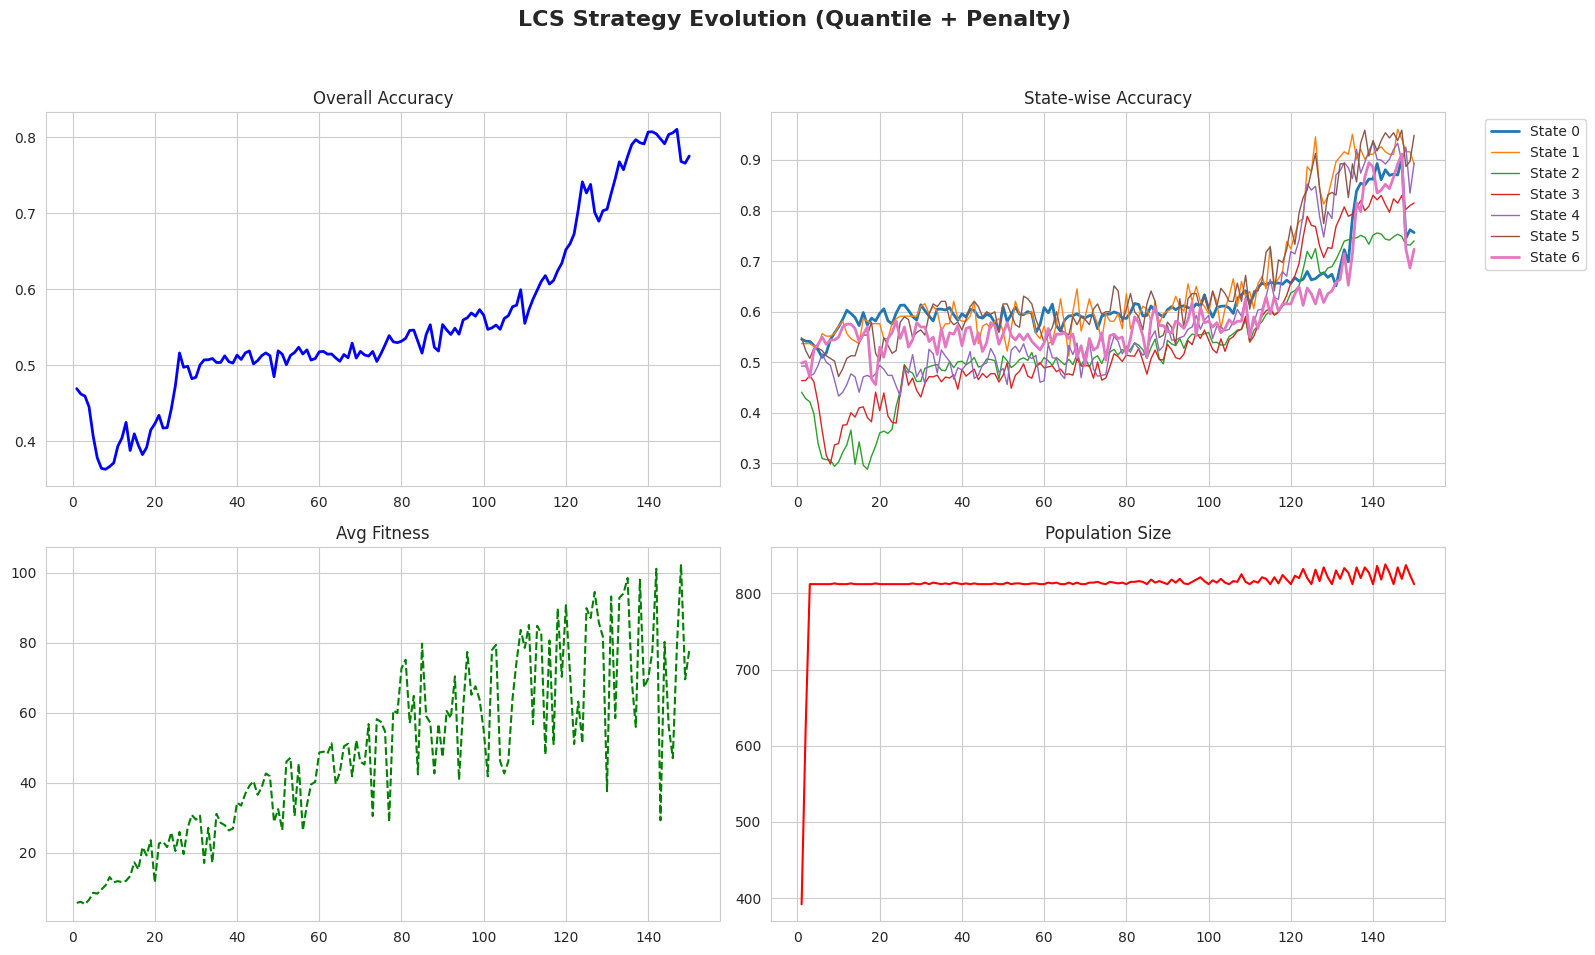


🛡️ 實戰規則過濾門檻設定為 Accuracy >= 50.50%
💾 最終可用規則數: 16

📉 In-Sample (Rows: 11680)

📌 分類報告:
              precision    recall  f1-score   support

 Neutral (0)     0.8378    0.2784    0.4180       334
      Up (1)     0.0385    0.5000    0.0714        20
    Down (2)     1.0000    0.1053    0.1905        19

    accuracy                         0.2815       373
   macro avg     0.6254    0.2946    0.2266       373
weighted avg     0.8032    0.2815    0.3878       373

➤ 做多準確率 (Up Precision)   : 3.85% (Pred: 260)
➤ 做空準確率 (Down Precision) : 100.00% (Pred: 2)
➤ 覆蓋率 (Coverage)           : 3.19% (373/11680)

📉 Out-of-Sample (Rows: 2921)

📌 分類報告:
              precision    recall  f1-score   support

 Neutral (0)     0.5455    0.6667    0.6000         9
      Up (1)     0.0000    0.0000    0.0000         0
    Down (2)     0.0000    0.0000    0.0000         5

    accuracy                         0.4286        14
   macro avg     0.1818    0.2222    0.2000        14
weighted avg     0.3506    0.428

In [26]:
# @title LCS Strategy (Ternary: Up/Down/Neutral) - High Precision Mode
import numpy as np
import polars as pl
import pandas as pd
import random
import logging
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import List, Dict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit
from pathlib import Path

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']

# 設定路徑
try:
    OUT_DIR
except NameError:
    OUT_DIR = Path("./")
try:
    INPUT_FILE
except NameError:
    INPUT_FILE = "hmm_features.parquet"

logger = logging.getLogger("LCS_Trader")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter('🔹 %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

def log(msg):
    print(f"🔹 {msg}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    log(f"🌱 Random Seed 已固定為: {seed}")

# ==============================================================================
# 🕵️ 1. 防洩漏檢測模組
# ==============================================================================
def run_leakage_check(df_pl: pl.DataFrame, target_horizon=1):
    print("\n" + "="*60)
    print("🕵️ 執行數據洩漏檢測 (Data Leakage Check)")
    print("="*60)
    df = df_pl.to_pandas()
    target_col = f"Ret_{target_horizon}m"

    if 'hmm_state' in df.columns:
        dummies = pd.get_dummies(df['hmm_state'], prefix='State')
        check_df = pd.concat([df[[target_col]], dummies], axis=1).dropna()
        corr = check_df.corr()[target_col].drop(target_col)
        max_corr = corr.abs().max()

        print(f"📌 HMM State (Rolling) vs {target_col} 最大相關係數: {max_corr:.4f}")
        if max_corr > 0.8:
            print("⚠️ [注意] 狀態與回報相關性極高，請確認回測邏輯是否正確。")
        else:
            print("✅ 檢測通過：無異常線性洩漏跡象。")
    print("="*60 + "\n")

# ==============================================================================
# ⚙️ 2. 資料準備 (維持上一版：降低門檻以增加樣本)
# ==============================================================================
def prepare_labeled_data(file_path: Path, horizons=[1, 3, 5], base_fee=0.0002):
    log(f"1. 讀取資料: {file_path}")
    if not file_path.exists():
        log(f"❌ 找不到檔案: {file_path}")
        return None

    try:
        df = pl.read_parquet(file_path)
        rename_map = {
            "HMM_State_Rolling": "hmm_state",
            "Buy_pressure_t_scaled": "bp_score",
            "Emo_score_scaled": "emo_score"
        }
        if "Buy_pressure_t" in df.columns and "bp_score" not in rename_map.values():
             rename_map["Buy_pressure_t"] = "bp_score"
        if "Emo_score" in df.columns and "emo_score" not in rename_map.values():
             rename_map["Emo_score"] = "emo_score"

        df = df.rename({k: v for k, v in rename_map.items() if k in df.columns})
        df = df.filter(pl.col("hmm_state") != -1)
    except Exception as e:
        log(f"❌ 讀取失敗: {e}")
        return None

    price_col = "Price" if "Price" in df.columns else "Close"

    # 動態調整門檻：降低門檻讓模型更容易捕捉到非盤整狀態
    df = df.with_columns(
        pl.when(pl.col("hmm_state") == 3).then(base_fee * 1.1)
          .when(pl.col("hmm_state").is_in([0, 6])).then(base_fee * 1.5)
          .otherwise(base_fee * 1.3)
          .alias("dynamic_threshold")
    )

    cols_to_keep = ["hmm_state", "bp_score", "emo_score"]
    for h in horizons:
        col_name = f"Ret_{h}m"
        label_name = f"Label_{h}m"
        df = df.with_columns((pl.col(price_col).shift(-h) / pl.col(price_col) - 1).alias(col_name))
        df = df.with_columns(
            pl.when(pl.col(col_name) > pl.col("dynamic_threshold")).then(1)
              .when(pl.col(col_name) < -pl.col("dynamic_threshold")).then(2)
              .otherwise(0).alias(label_name)
        )
        cols_to_keep.append(col_name)
        cols_to_keep.append(label_name)

    return df.select(cols_to_keep).drop_nulls()

# ==============================================================================
# 🧩 2.1 特徵離散化 (Update: 改用 Quantile 切分)
# ==============================================================================
def discretize_features(df: pl.DataFrame) -> pd.DataFrame:
    log("2. 進行特徵離散化 (Quantile Binning)...")
    df_pd = df.to_pandas()
    state_col = df_pd["hmm_state"].astype(str)

    # 使用 qcut (分位數切分) 將數據分為 5 等份：VL(極低), L(低), N(中), H(高), VH(極高)
    # 這樣能更有效地分離極端值，提升精準度
    try:
        bp_disc = pd.qcut(df_pd["bp_score"], q=5, labels=["VL", "L", "N", "H", "VH"])
    except ValueError:
        # 如果數據過於集中無法分位，退回使用等距切分
        bp_disc = pd.cut(df_pd["bp_score"], bins=5, labels=["VL", "L", "N", "H", "VH"])

    try:
        emo_disc = pd.qcut(df_pd["emo_score"], q=5, labels=["VL", "L", "N", "H", "VH"])
    except ValueError:
        emo_disc = pd.cut(df_pd["emo_score"], bins=5, labels=["VL", "L", "N", "H", "VH"])

    df_pd["Condition"] = state_col + "-" + bp_disc.astype(str) + "-" + emo_disc.astype(str)
    return df_pd

# ==============================================================================
# 🧬 3. LCS 核心類別 (Update: 加入錯誤懲罰機制)
# ==============================================================================
@dataclass
class Classifier:
    condition: str
    action: int  # 0: Neutral, 1: Up, 2: Down
    fitness: float = 50.0
    accuracy: float = 0.5
    numerosity: int = 1
    experience: int = 0
    match_count: int = 0

    def update_accuracy(self, is_correct: bool, beta: float, nu: int, weight: float = 1.0):
        reward = 1.0 if is_correct else 0.0

        # 【修正】懲罰權重：如果猜錯且不是盤整 (亂喊單)，加重更新幅度，讓準確率快速下降
        penalty_weight = 1.5 if (not is_correct and self.action != 0) else 1.0
        weighted_beta = min(beta * weight * penalty_weight, 1.0)

        self.experience += 1
        if is_correct: self.match_count += 1

        self.accuracy = self.accuracy + weighted_beta * (reward - self.accuracy)

        # 【修正】Fitness 更新邏輯
        # 1. Action Bonus: 猜對漲跌給予獎勵
        action_bonus = 1.25 if (is_correct and self.action in [1, 2]) else 1.0

        # 2. Fitness Penalty: 猜錯漲跌給予懲罰 (適應度打折)
        fitness_penalty = 0.8 if (not is_correct and self.action != 0) else 1.0

        # 準確率冪次放大
        acc_factor = (self.accuracy ** nu) * 100 if self.accuracy > 0.33 else 1.0

        target_fitness = acc_factor * action_bonus * fitness_penalty
        self.fitness = self.fitness + beta * (target_fitness - self.fitness)

class SimpleLCS:
    def __init__(self, population_size=1000, mutation_rate=0.1, beta=0.1, nu=5):
        self.population: List[Classifier] = []
        self.max_pop_size = population_size
        self.mutation_rate = mutation_rate
        self.beta = beta
        self.nu = nu
        self.time_step = 0
        self.ga_count = 0
        self.actions = [0, 1, 2]

    def get_match_set(self, condition_input: str) -> List[Classifier]:
        return [cl for cl in self.population if cl.condition == condition_input]

    def cover(self, condition_input: str, label: int):
        new_cl = Classifier(condition=condition_input, action=label, fitness=10.0, accuracy=0.5)
        self.population.append(new_cl)

    def predict(self, match_set: List[Classifier]) -> int:
        if not match_set: return 0
        votes = {0: 0.0, 1: 0.0, 2: 0.0}
        for cl in match_set:
            votes[cl.action] += cl.fitness * cl.accuracy
        return max(votes, key=votes.get)

    def run_ga(self, match_set: List[Classifier]):
        if self.time_step % 50 != 0 or not match_set: return
        total_fit = sum(cl.fitness for cl in match_set)
        if total_fit == 0: return

        parent = random.choices(match_set, weights=[cl.fitness for cl in match_set], k=1)[0]
        child = Classifier(condition=parent.condition, action=parent.action)

        if random.random() < self.mutation_rate:
            possible_actions = list(set(self.actions) - {child.action})
            child.action = random.choice(possible_actions)
            child.accuracy = 0.5
            child.fitness = 10.0
            child.experience = 0

        self.population.append(child)
        self.ga_count += 1

        if len(self.population) > self.max_pop_size:
            self.population.sort(key=lambda x: (x.fitness * 0.8 + x.accuracy * 0.2), reverse=True)
            self.population = self.population[:self.max_pop_size]

    def train_instance(self, condition_input: str, label: int):
        self.time_step += 1
        try:
            current_state = int(condition_input.split("-")[0])
        except:
            current_state = 3

        # 針對極端狀態加強學習
        importance_weight = 1.5 if current_state in [0, 6] else 1.0

        match_set = self.get_match_set(condition_input)
        if not match_set:
            self.cover(condition_input, label)
            match_set = self.get_match_set(condition_input)

        prediction = self.predict(match_set)
        is_correct = (prediction == label)

        for cl in match_set:
            cl.update_accuracy(is_correct, self.beta, self.nu, weight=importance_weight)

        self.run_ga(match_set)
        return is_correct

    def get_population_stats(self):
        if not self.population: return {}
        avg_fit = sum(cl.fitness for cl in self.population) / len(self.population)
        avg_acc = sum(cl.accuracy for cl in self.population) / len(self.population)
        return {"Pop_Size": len(self.population), "Avg_Fit": avg_fit, "Avg_Acc": avg_acc, "GA_Events": self.ga_count}

# ==============================================================================
# 📊 4. 訓練儀表板
# ==============================================================================
def plot_lcs_training_history(history):
    epochs = range(1, len(history['total_acc']) + 1)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('LCS Strategy Evolution (Quantile + Penalty)', fontsize=16, fontweight='bold')

    ax1 = axes[0, 0]
    ax1.plot(epochs, history['total_acc'], 'b-', linewidth=2)
    ax1.set_title('Overall Accuracy')

    ax2 = axes[0, 1]
    active_states = [s for s, accs in history['state_acc'].items() if len(accs) > 0]
    palette = sns.color_palette("tab10", len(active_states))
    for idx, state in enumerate(active_states):
        acc_list = history['state_acc'][state]
        if len(acc_list) != len(epochs): continue
        lw = 2.0 if str(state) in ['0', '6'] else 1.0
        ax2.plot(epochs, acc_list, linewidth=lw, label=f'State {state}', color=palette[idx])
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.set_title('State-wise Accuracy')

    ax3 = axes[1, 0]
    ax3.plot(epochs, history['avg_fit'], 'g--')
    ax3.set_title('Avg Fitness')

    ax4 = axes[1, 1]
    ax4.plot(epochs, history['pop_size'], 'r-')
    ax4.set_title('Population Size')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==============================================================================
# 🧪 5. Optuna 目標函數 (Update: 調整參數區間)
# ==============================================================================
def objective(trial, df_train_full, target_col):
    params = {
        # 加大族群以容納更細緻的 Quantile 特徵
        'population_size': trial.suggest_int('population_size', 800, 1500),
        # 降低突變率上限，避免破壞好不容易學到的精確規則
        'mutation_rate': trial.suggest_float('mutation_rate', 0.05, 0.15),
        'beta': trial.suggest_float('beta', 0.15, 0.40),
        'nu': trial.suggest_int('nu', 5, 10)
    }

    min_acc_threshold = trial.suggest_float('min_acc_threshold', 0.35, 0.48)

    tscv = TimeSeriesSplit(n_splits=3)
    cv_scores = []

    for fold_idx, (train_index, val_index) in enumerate(tscv.split(df_train_full)):
        lcs = SimpleLCS(**params)
        fold_train_df = df_train_full.iloc[train_index]
        fold_val_df = df_train_full.iloc[val_index]
        conditions = fold_train_df["Condition"].values
        labels = fold_train_df[target_col].values

        indices = np.arange(len(conditions))
        for _ in range(15):
            np.random.shuffle(indices)
            for i in indices:
                lcs.train_instance(conditions[i], int(labels[i]))

        rule_map = {}
        # 經驗值門檻 10
        valid_rules = [cl for cl in lcs.population if cl.experience >= 10 and cl.accuracy >= min_acc_threshold]
        for cl in valid_rules:
            if cl.condition not in rule_map or cl.fitness > rule_map[cl.condition].fitness:
                rule_map[cl.condition] = cl

        correct, covered = 0, 0
        val_conds, val_lbls = fold_val_df["Condition"].values, fold_val_df[target_col].values

        for i in range(len(val_conds)):
            cond = val_conds[i]
            lbl = int(val_lbls[i])
            if cond in rule_map:
                pred = rule_map[cond].action
                covered += 1
                if pred == lbl: correct += 1

        if covered == 0:
            cv_scores.append(0.0)
        else:
            acc = correct / covered
            coverage_rate = covered / len(fold_val_df)
            penalty = 1.0 if coverage_rate > 0.05 else (coverage_rate * 20)
            cv_scores.append(acc * penalty)

    return np.mean(cv_scores)

# ==============================================================================
# 📊 6. 績效評估函數
# ==============================================================================
def evaluate_dataset(engine_map, df, target_col, title):
    print("\n" + "="*80)
    print(f"📉 {title} (Rows: {len(df)})")
    print("="*80)

    y_true, y_pred = [], []
    covered_count = 0
    for _, row in df.iterrows():
        cond = row["Condition"]
        lbl = int(row[target_col])
        if cond in engine_map:
            y_pred.append(engine_map[cond].action)
            y_true.append(lbl)
            covered_count += 1

    if not y_true:
        print("⚠️ 無有效訊號。")
        return

    target_names = ['Neutral (0)', 'Up (1)', 'Down (2)']
    labels_present = sorted(list(set(y_true) | set(y_pred)))
    target_names_present = [target_names[i] for i in labels_present]

    print("\n📌 分類報告:")
    print(classification_report(y_true, y_pred, labels=labels_present, target_names=target_names_present, digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

    # 避免分母為 0
    up_total_pred = cm[:,1].sum()
    down_total_pred = cm[:,2].sum()

    up_precision = cm[1,1] / up_total_pred if up_total_pred > 0 else 0
    down_precision = cm[2,2] / down_total_pred if down_total_pred > 0 else 0

    print(f"➤ 做多準確率 (Up Precision)   : {up_precision:.2%} (Pred: {up_total_pred})")
    print(f"➤ 做空準確率 (Down Precision) : {down_precision:.2%} (Pred: {down_total_pred})")
    print(f"➤ 覆蓋率 (Coverage)           : {covered_count/len(df):.2%} ({covered_count}/{len(df)})")

# ==============================================================================
# 🚀 7. 主程式 (Update: 提高最終規則篩選門檻)
# ==============================================================================
def main():
    set_seed(42)
    full_path = OUT_DIR / INPUT_FILE
    TARGET_HORIZON = 1

    df_pl = prepare_labeled_data(full_path, horizons=[1, 3, 5])
    if df_pl is None: return
    run_leakage_check(df_pl, TARGET_HORIZON)

    # 特徵離散化 (Quantile)
    df_disc = discretize_features(df_pl)
    target_col = f"Label_{TARGET_HORIZON}m"

    split_idx = int(len(df_disc) * 0.8)
    train_data = df_disc.iloc[:split_idx].copy()
    test_data = df_disc.iloc[split_idx:].copy()

    print("\n🔍 Optuna 參數搜尋中 (High Precision Optimization)...")
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, train_data, target_col), n_trials=20)

    best_params = study.best_params
    min_acc_cutoff = best_params.pop('min_acc_threshold')
    print(f"\n✅ 最佳參數: {best_params}")
    print(f"🎯 訓練篩選門檻: {min_acc_cutoff:.2%}")

    final_lcs = SimpleLCS(**best_params)
    conditions = train_data["Condition"].values
    labels = train_data[target_col].values
    states_list = train_data["Condition"].apply(lambda x: x.split("-")[0]).values

    unique_states = np.unique(states_list)
    history = {"total_acc": [], "avg_fit": [], "pop_size": [], "state_acc": {s: [] for s in unique_states}}

    EPOCHS = 150
    # EPOCHS = 150
    print(f"\n🚀 啟動 LCS 最終訓練 (Epochs: {EPOCHS})...")

    for epoch in range(EPOCHS):
        indices = np.arange(len(conditions))
        np.random.shuffle(indices)
        correct, s_correct, s_counts = 0, {s: 0 for s in unique_states}, {s: 0 for s in unique_states}

        for i in indices:
            res = final_lcs.train_instance(conditions[i], int(labels[i]))
            s_key = states_list[i]
            if res:
                correct += 1
                s_correct[s_key] += 1
            s_counts[s_key] += 1

        history["total_acc"].append(correct / len(conditions))
        stats = final_lcs.get_population_stats()
        history["avg_fit"].append(stats['Avg_Fit'])
        history["pop_size"].append(stats['Pop_Size'])
        for s in unique_states:
            history["state_acc"][s].append(s_correct[s]/s_counts[s] if s_counts[s]>0 else 0)

    plot_lcs_training_history(history)

    # 【修正】最終規則匯出邏輯：提高門檻，確保實戰規則是準的
    # 即使訓練時允許低準確率規則存在以保持多樣性，匯出時只取精華
    trading_threshold = max(min_acc_cutoff, 0.505)
    print(f"\n🛡️ 實戰規則過濾門檻設定為 Accuracy >= {trading_threshold:.2%}")

    final_rules = [cl for cl in final_lcs.population if cl.experience >= 15 and cl.accuracy >= trading_threshold]
    unique_rules = {}
    for cl in final_rules:
        if cl.condition not in unique_rules or cl.fitness > unique_rules[cl.condition].fitness:
            unique_rules[cl.condition] = cl

    engine_map = {r.condition: r for r in unique_rules.values()}
    print(f"💾 最終可用規則數: {len(engine_map)}")

    # 匯出規則到 CSV
    rule_data = []
    action_map = {0: "NEUTRAL", 1: "BUY", 2: "SELL"}
    for rule in unique_rules.values():
        rule_data.append({
            "Condition": rule.condition,
            "Action": action_map[rule.action],
            "Accuracy": rule.accuracy,
            "Fitness": rule.fitness,
            "Exp": rule.experience
        })
    pd.DataFrame(rule_data).to_csv(OUT_DIR / "lcs_rules_high_precision.csv", index=False)

    evaluate_dataset(engine_map, train_data, target_col, "In-Sample")
    evaluate_dataset(engine_map, test_data, target_col, "Out-of-Sample")

if __name__ == "__main__":
    main()

In [8]:
# @title LCS Strategy (Zombie Killer Edition: Post-Validation)
import numpy as np
import polars as pl
import pandas as pd
import random
import logging
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import List, Dict
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit
from pathlib import Path

# 設定繪圖風格
sns.set_style("whitegrid")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']

# 設定路徑
try:
    OUT_DIR
except NameError:
    OUT_DIR = Path("./")
try:
    INPUT_FILE
except NameError:
    INPUT_FILE = "hmm_features.parquet"

logger = logging.getLogger("LCS_Trader")
logger.setLevel(logging.INFO)
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter('🔹 %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

def log(msg):
    print(f"🔹 {msg}")

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    log(f"🌱 Random Seed 已固定為: {seed}")

# ==============================================================================
# 🕵️ 1. 防洩漏檢測
# ==============================================================================
def run_leakage_check(df_pl: pl.DataFrame, target_horizon=1):
    # (維持不變)
    print("\n" + "="*60)
    print("🕵️ 執行數據洩漏檢測 (Data Leakage Check)")
    print("="*60)
    df = df_pl.to_pandas()
    target_col = f"Ret_{target_horizon}m"

    if 'hmm_state' in df.columns:
        dummies = pd.get_dummies(df['hmm_state'], prefix='State')
        check_df = pd.concat([df[[target_col]], dummies], axis=1).dropna()
        corr = check_df.corr()[target_col].drop(target_col)
        max_corr = corr.abs().max()

        print(f"📌 HMM State (Rolling) vs {target_col} 最大相關係數: {max_corr:.4f}")
        if max_corr > 0.8:
            print("⚠️ [注意] 狀態與回報相關性極高，請確認回測邏輯是否正確。")
        else:
            print("✅ 檢測通過：無異常線性洩漏跡象。")
    print("="*60 + "\n")

# ==============================================================================
# ⚙️ 2. 資料準備
# ==============================================================================
def prepare_labeled_data(file_path: Path, horizons=[1, 3, 5], base_fee=0.0002):
    log(f"1. 讀取資料: {file_path}")
    if not file_path.exists():
        log(f"❌ 找不到檔案: {file_path}")
        return None

    try:
        df = pl.read_parquet(file_path)
        rename_map = {
            "HMM_State_Rolling": "hmm_state",
            "Buy_pressure_t_scaled": "bp_score",
            "Emo_score_scaled": "emo_score"
        }
        if "Buy_pressure_t" in df.columns and "bp_score" not in rename_map.values():
             rename_map["Buy_pressure_t"] = "bp_score"
        if "Emo_score" in df.columns and "emo_score" not in rename_map.values():
             rename_map["Emo_score"] = "emo_score"

        df = df.rename({k: v for k, v in rename_map.items() if k in df.columns})
        df = df.filter(pl.col("hmm_state") != -1)
    except Exception as e:
        log(f"❌ 讀取失敗: {e}")
        return None

    price_col = "Price" if "Price" in df.columns else "Close"

    # 維持較低的門檻，確保有足夠的 Label 1/2
    df = df.with_columns(
        pl.when(pl.col("hmm_state") == 3).then(base_fee * 1.1)
          .when(pl.col("hmm_state").is_in([0, 6])).then(base_fee * 1.5)
          .otherwise(base_fee * 1.3)
          .alias("dynamic_threshold")
    )

    cols_to_keep = ["hmm_state", "bp_score", "emo_score"]
    for h in horizons:
        col_name = f"Ret_{h}m"
        label_name = f"Label_{h}m"
        df = df.with_columns((pl.col(price_col).shift(-h) / pl.col(price_col) - 1).alias(col_name))
        df = df.with_columns(
            pl.when(pl.col(col_name) > pl.col("dynamic_threshold")).then(1)
              .when(pl.col(col_name) < -pl.col("dynamic_threshold")).then(2)
              .otherwise(0).alias(label_name)
        )
        cols_to_keep.append(col_name)
        cols_to_keep.append(label_name)

    return df.select(cols_to_keep).drop_nulls()

def discretize_features(df: pl.DataFrame) -> pd.DataFrame:
    log("2. 進行特徵離散化 (Quantile Binning)...")
    df_pd = df.to_pandas()
    state_col = df_pd["hmm_state"].astype(str)

    # 使用 qcut (分位數切分)，若失敗則退回 cut
    try:
        bp_disc = pd.qcut(df_pd["bp_score"], q=5, labels=["VL", "L", "N", "H", "VH"])
    except ValueError:
        bp_disc = pd.cut(df_pd["bp_score"], bins=5, labels=["VL", "L", "N", "H", "VH"])

    try:
        emo_disc = pd.qcut(df_pd["emo_score"], q=5, labels=["VL", "L", "N", "H", "VH"])
    except ValueError:
        emo_disc = pd.cut(df_pd["emo_score"], bins=5, labels=["VL", "L", "N", "H", "VH"])

    df_pd["Condition"] = state_col + "-" + bp_disc.astype(str) + "-" + emo_disc.astype(str)
    return df_pd

# ==============================================================================
# 🧬 3. LCS 核心類別 (稍微放寬懲罰)
# ==============================================================================
@dataclass
class Classifier:
    condition: str
    action: int  # 0: Neutral, 1: Up, 2: Down
    fitness: float = 50.0
    accuracy: float = 0.5
    numerosity: int = 1
    experience: int = 0
    match_count: int = 0
    
    # 新增欄位：用於存儲全量驗證後的真實準確率
    true_accuracy: float = 0.0 

    def update_accuracy(self, is_correct: bool, beta: float, nu: int, weight: float = 1.0):
        reward = 1.0 if is_correct else 0.0
        
        # 【放寬】懲罰權重從 1.5 降至 1.2，避免殺太快
        penalty_weight = 1.2 if (not is_correct and self.action != 0) else 1.0
        weighted_beta = min(beta * weight * penalty_weight, 1.0)

        self.experience += 1
        if is_correct: self.match_count += 1

        self.accuracy = self.accuracy + weighted_beta * (reward - self.accuracy)

        # 【放寬】Fitness Penalty 從 0.8 回升到 0.9
        action_bonus = 1.25 if (is_correct and self.action in [1, 2]) else 1.0
        fitness_penalty = 0.9 if (not is_correct and self.action != 0) else 1.0

        acc_factor = (self.accuracy ** nu) * 100 if self.accuracy > 0.33 else 1.0
        target_fitness = acc_factor * action_bonus * fitness_penalty
        self.fitness = self.fitness + beta * (target_fitness - self.fitness)

class SimpleLCS:
    def __init__(self, population_size=1000, mutation_rate=0.1, beta=0.1, nu=5):
        self.population: List[Classifier] = []
        self.max_pop_size = population_size
        self.mutation_rate = mutation_rate
        self.beta = beta
        self.nu = nu
        self.time_step = 0
        self.ga_count = 0
        self.actions = [0, 1, 2]

    def get_match_set(self, condition_input: str) -> List[Classifier]:
        return [cl for cl in self.population if cl.condition == condition_input]

    def cover(self, condition_input: str, label: int):
        new_cl = Classifier(condition=condition_input, action=label, fitness=10.0, accuracy=0.5)
        self.population.append(new_cl)

    def predict(self, match_set: List[Classifier]) -> int:
        if not match_set: return 0
        votes = {0: 0.0, 1: 0.0, 2: 0.0}
        for cl in match_set:
            votes[cl.action] += cl.fitness * cl.accuracy
        return max(votes, key=votes.get)

    def run_ga(self, match_set: List[Classifier]):
        if self.time_step % 50 != 0 or not match_set: return
        total_fit = sum(cl.fitness for cl in match_set)
        if total_fit == 0: return

        parent = random.choices(match_set, weights=[cl.fitness for cl in match_set], k=1)[0]
        child = Classifier(condition=parent.condition, action=parent.action)

        if random.random() < self.mutation_rate:
            possible_actions = list(set(self.actions) - {child.action})
            child.action = random.choice(possible_actions)
            child.accuracy = 0.5
            child.fitness = 10.0
            child.experience = 0

        self.population.append(child)
        self.ga_count += 1

        if len(self.population) > self.max_pop_size:
            self.population.sort(key=lambda x: (x.fitness * 0.8 + x.accuracy * 0.2), reverse=True)
            self.population = self.population[:self.max_pop_size]

    def train_instance(self, condition_input: str, label: int):
        self.time_step += 1
        try:
            current_state = int(condition_input.split("-")[0])
        except:
            current_state = 3
        
        importance_weight = 1.5 if current_state in [0, 6] else 1.0
        
        match_set = self.get_match_set(condition_input)
        if not match_set:
            self.cover(condition_input, label)
            match_set = self.get_match_set(condition_input)

        prediction = self.predict(match_set)
        is_correct = (prediction == label)
        
        for cl in match_set:
            cl.update_accuracy(is_correct, self.beta, self.nu, weight=importance_weight)
        
        self.run_ga(match_set)
        return is_correct

    def get_population_stats(self):
        if not self.population: return {}
        avg_fit = sum(cl.fitness for cl in self.population) / len(self.population)
        avg_acc = sum(cl.accuracy for cl in self.population) / len(self.population)
        return {"Pop_Size": len(self.population), "Avg_Fit": avg_fit, "Avg_Acc": avg_acc, "GA_Events": self.ga_count}

# ==============================================================================
# 🕵️ 新增：全量驗證函數 (Zombie Killer)
# ==============================================================================
def validate_population(lcs: SimpleLCS, df_data: pd.DataFrame, target_col: str):
    """
    對所有規則進行一次全量掃描，計算其真實準確率 (True Accuracy)。
    """
    print("🕵️ 執行全量規則驗證 (Calculating True Accuracy)...")
    
    # 建立 Condition -> 規則列表 的映射，加速查找
    # 注意：同一個 Condition 可能有多個 Action 的規則，需要分別驗證
    rule_map = {}
    unique_rules = []
    
    # 先去重，保留 Fitness 最高的
    temp_map = {}
    for cl in lcs.population:
        key = (cl.condition, cl.action)
        if key not in temp_map or cl.fitness > temp_map[key].fitness:
            temp_map[key] = cl
    unique_rules = list(temp_map.values())

    # 重置計數器
    stats = {cl: {'correct': 0, 'total': 0} for cl in unique_rules}
    
    # 建立查找表
    cond_to_rules = {}
    for cl in unique_rules:
        if cl.condition not in cond_to_rules:
            cond_to_rules[cl.condition] = []
        cond_to_rules[cl.condition].append(cl)

    # 掃描數據
    conditions = df_data["Condition"].values
    labels = df_data[target_col].values
    
    for i in range(len(conditions)):
        cond = conditions[i]
        lbl = int(labels[i])
        
        if cond in cond_to_rules:
            for cl in cond_to_rules[cond]:
                stats[cl]['total'] += 1
                if cl.action == lbl:
                    stats[cl]['correct'] += 1
    
    # 更新規則的 true_accuracy
    validated_rules = []
    for cl in unique_rules:
        s = stats[cl]
        if s['total'] > 0:
            cl.true_accuracy = s['correct'] / s['total']
            # 將 Experience 更新為真實覆蓋數
            cl.experience = s['total'] 
            validated_rules.append(cl)
            
    print(f"✅ 驗證完成，共 {len(validated_rules)} 條規則參與評估")
    return validated_rules

# ==============================================================================
# 📊 訓練儀表板
# ==============================================================================
def plot_lcs_training_history(history):
    epochs = range(1, len(history['total_acc']) + 1)
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('LCS Strategy Evolution (With Validation)', fontsize=16, fontweight='bold')
    
    ax1 = axes[0, 0]
    ax1.plot(epochs, history['total_acc'], 'b-', linewidth=2)
    ax1.set_title('Overall Accuracy')
    
    ax2 = axes[0, 1]
    active_states = [s for s, accs in history['state_acc'].items() if len(accs) > 0]
    palette = sns.color_palette("tab10", len(active_states))
    for idx, state in enumerate(active_states):
        acc_list = history['state_acc'][state]
        if len(acc_list) != len(epochs): continue
        lw = 2.0 if str(state) in ['0', '6'] else 1.0
        ax2.plot(epochs, acc_list, linewidth=lw, label=f'State {state}', color=palette[idx])
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.set_title('State-wise Accuracy')
    
    ax3 = axes[1, 0]
    ax3.plot(epochs, history['avg_fit'], 'g--')
    ax3.set_title('Avg Fitness')
    
    ax4 = axes[1, 1]
    ax4.plot(epochs, history['pop_size'], 'r-')
    ax4.set_title('Population Size')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ==============================================================================
# 🧪 Optuna (目標函數也需要使用驗證後的準確率)
# ==============================================================================
def objective(trial, df_train_full, target_col):
    params = {
        'population_size': trial.suggest_int('population_size', 800, 1500),
        'mutation_rate': trial.suggest_float('mutation_rate', 0.05, 0.15),
        'beta': trial.suggest_float('beta', 0.2, 0.45), # 加快學習速度
        'nu': trial.suggest_int('nu', 5, 10)
    }

    # 訓練篩選門檻 (對應 True Accuracy)
    min_acc_threshold = trial.suggest_float('min_acc_threshold', 0.40, 0.50)

    tscv = TimeSeriesSplit(n_splits=3)
    cv_scores = []

    for fold_idx, (train_index, val_index) in enumerate(tscv.split(df_train_full)):
        lcs = SimpleLCS(**params)
        fold_train_df = df_train_full.iloc[train_index]
        fold_val_df = df_train_full.iloc[val_index]
        conditions = fold_train_df["Condition"].values
        labels = fold_train_df[target_col].values

        indices = np.arange(len(conditions))
        for _ in range(12): # 稍微減少 Epochs，依賴 Beta 加速
            np.random.shuffle(indices)
            for i in indices:
                lcs.train_instance(conditions[i], int(labels[i]))

        # 【關鍵】在 CV 中也使用全量驗證
        validated_rules = validate_population(lcs, fold_train_df, target_col)
        
        # 使用 True Accuracy 進行篩選
        rule_map = {}
        valid_rules = [cl for cl in validated_rules if cl.experience >= 10 and cl.true_accuracy >= min_acc_threshold]
        
        for cl in valid_rules:
            # 如果同個條件有多個動作，選 True Accuracy 最高的
            if cl.condition not in rule_map or cl.true_accuracy > rule_map[cl.condition].true_accuracy:
                rule_map[cl.condition] = cl

        correct, covered = 0, 0
        val_conds, val_lbls = fold_val_df["Condition"].values, fold_val_df[target_col].values
        
        for i in range(len(val_conds)):
            cond = val_conds[i]
            lbl = int(val_lbls[i])
            if cond in rule_map:
                pred = rule_map[cond].action
                covered += 1
                if pred == lbl: correct += 1

        if covered == 0:
            cv_scores.append(0.0)
        else:
            acc = correct / covered
            coverage_rate = covered / len(fold_val_df)
            penalty = 1.0 if coverage_rate > 0.05 else (coverage_rate * 20)
            cv_scores.append(acc * penalty)

    return np.mean(cv_scores)

# ==============================================================================
# 📊 績效評估
# ==============================================================================
def evaluate_dataset(engine_map, df, target_col, title):
    print("\n" + "="*80)
    print(f"📉 {title} (Rows: {len(df)})")
    print("="*80)

    y_true, y_pred = [], []
    covered_count = 0
    for _, row in df.iterrows():
        cond = row["Condition"]
        lbl = int(row[target_col])
        if cond in engine_map:
            y_pred.append(engine_map[cond].action)
            y_true.append(lbl)
            covered_count += 1

    if not y_true:
        print("⚠️ 無有效訊號。")
        return

    target_names = ['Neutral (0)', 'Up (1)', 'Down (2)']
    labels_present = sorted(list(set(y_true) | set(y_pred)))
    target_names_present = [target_names[i] for i in labels_present]

    print("\n📌 分類報告:")
    print(classification_report(y_true, y_pred, labels=labels_present, target_names=target_names_present, digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    up_total = cm[:,1].sum()
    down_total = cm[:,2].sum()
    
    up_precision = cm[1,1] / up_total if up_total > 0 else 0
    down_precision = cm[2,2] / down_total if down_total > 0 else 0

    print(f"➤ 做多準確率 (Up Precision)   : {up_precision:.2%} (Pred: {up_total})")
    print(f"➤ 做空準確率 (Down Precision) : {down_precision:.2%} (Pred: {down_total})")
    print(f"➤ 覆蓋率 (Coverage)           : {covered_count/len(df):.2%} ({covered_count}/{len(df)})")

# ==============================================================================
# 🚀 主程式
# ==============================================================================
def main():
    set_seed(42)
    full_path = OUT_DIR / INPUT_FILE
    TARGET_HORIZON = 1

    df_pl = prepare_labeled_data(full_path, horizons=[1, 3, 5])
    if df_pl is None: return
    run_leakage_check(df_pl, TARGET_HORIZON)

    df_disc = discretize_features(df_pl)
    target_col = f"Label_{TARGET_HORIZON}m"
    
    split_idx = int(len(df_disc) * 0.8)
    train_data = df_disc.iloc[:split_idx].copy()
    test_data = df_disc.iloc[split_idx:].copy()

    print("\n🔍 Optuna 參數搜尋中 (With Validation Step)...")
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, train_data, target_col), n_trials=15)

    best_params = study.best_params
    min_acc_cutoff = best_params.pop('min_acc_threshold')
    print(f"\n✅ 最佳參數: {best_params}")
    print(f"🎯 訓練篩選門檻 (True Acc): {min_acc_cutoff:.2%}")

    final_lcs = SimpleLCS(**best_params)
    conditions = train_data["Condition"].values
    labels = train_data[target_col].values
    states_list = train_data["Condition"].apply(lambda x: x.split("-")[0]).values
    
    unique_states = np.unique(states_list)
    history = {"total_acc": [], "avg_fit": [], "pop_size": [], "state_acc": {s: [] for s in unique_states}}

    EPOCHS = 100
    print(f"\n🚀 啟動 LCS 最終訓練 (Epochs: {EPOCHS})...")
    
    for epoch in range(EPOCHS):
        indices = np.arange(len(conditions))
        np.random.shuffle(indices)
        correct, s_correct, s_counts = 0, {s: 0 for s in unique_states}, {s: 0 for s in unique_states}

        for i in indices:
            res = final_lcs.train_instance(conditions[i], int(labels[i]))
            s_key = states_list[i]
            if res:
                correct += 1
                s_correct[s_key] += 1
            s_counts[s_key] += 1

        history["total_acc"].append(correct / len(conditions))
        stats = final_lcs.get_population_stats()
        history["avg_fit"].append(stats['Avg_Fit'])
        history["pop_size"].append(stats['Pop_Size'])
        for s in unique_states:
            history["state_acc"][s].append(s_correct[s]/s_counts[s] if s_counts[s]>0 else 0)

    plot_lcs_training_history(history)

    # ==========================================================================
    # 🛡️ 最終規則過濾：使用全量驗證數據
    # ==========================================================================
    validated_rules = validate_population(final_lcs, train_data, target_col)
    
    # 實戰門檻：只接受真實準確率 > 48% 的規則 (稍微低於 50% 以換取覆蓋率，因為已通過全量驗證)
    trading_threshold = max(min_acc_cutoff, 0.48)
    print(f"\n🛡️ 實戰規則過濾門檻設定為 True Accuracy >= {trading_threshold:.2%}")

    final_rules = [cl for cl in validated_rules if cl.experience >= 15 and cl.true_accuracy >= trading_threshold]
    
    # 解決衝突：同條件取最準的
    unique_rules = {}
    for cl in final_rules:
        if cl.condition not in unique_rules or cl.true_accuracy > unique_rules[cl.condition].true_accuracy:
            unique_rules[cl.condition] = cl
    
    engine_map = {r.condition: r for r in unique_rules.values()}
    print(f"💾 最終可用規則數: {len(engine_map)}")
    
    # 匯出規則
    rule_data = []
    action_map = {0: "NEUTRAL", 1: "BUY", 2: "SELL"}
    for rule in unique_rules.values():
        rule_data.append({
            "Condition": rule.condition,
            "Action": action_map[rule.action],
            "True_Accuracy": rule.true_accuracy, # 匯出真實準確率
            "Train_Accuracy": rule.accuracy,     # 參考用
            "Fitness": rule.fitness,
            "Exp": rule.experience
        })
    pd.DataFrame(rule_data).to_csv(OUT_DIR / "lcs_rules_validated.csv", index=False)

    evaluate_dataset(engine_map, train_data, target_col, "In-Sample (Validated)")
    evaluate_dataset(engine_map, test_data, target_col, "Out-of-Sample (Test)")

if __name__ == "__main__":
    main()

[I 2026-01-31 15:15:01,975] A new study created in memory with name: no-name-2364191e-4215-4b2b-b52d-aaee7b8beb57


🔹 🌱 Random Seed 已固定為: 42
🔹 1. 讀取資料: output_v全域版\step4_features_with_hmm.parquet

🕵️ 執行數據洩漏檢測 (Data Leakage Check)
📌 HMM State (Rolling) vs Ret_1m 最大相關係數: 0.0133
✅ 檢測通過：無異常線性洩漏跡象。

🔹 2. 進行特徵離散化 (Quantile Binning)...

🔍 Optuna 參數搜尋中 (With Validation Step)...


[W 2026-01-31 15:15:02,840] Trial 0 failed with parameters: {'population_size': 1193, 'mutation_rate': 0.127761404378705, 'beta': 0.22299309540301926, 'nu': 10, 'min_acc_threshold': 0.4341574969525174} because of the following error: TypeError("unhashable type: 'Classifier'").
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\user\AppData\Local\Temp\ipykernel_18048\1368083138.py", line 470, in <lambda>
    study.optimize(lambda trial: objective(trial, train_data, target_col), n_trials=15)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\AppData\Local\Temp\ipykernel_18048\1368083138.py", line 377, in objective
    validated_rules = validate_population(lcs, fold_train_df, target_col)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users

🕵️ 執行全量規則驗證 (Calculating True Accuracy)...


TypeError: unhashable type: 'Classifier'